In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoModelForSequenceClassification, TrainingArguments
import pandas as pd

# Generate Adversarial Text

### Get Token Gradients, Prediction and Confidence

In [ ]:
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("MarieAngeA13/Sentiment-Analysis-BERT")
model = TFAutoModelForSequenceClassification.from_pretrained("./gdrive/MyDrive/tweet_classification")

def get_gradients(text, model, tokenizer, target_class):
    embedding_matrix = model.bert.embeddings.weights[0]
    encoded_tokens = tokenizer(text, return_tensors="tf")
    token_ids = list(encoded_tokens["input_ids"].numpy()[0])
    vocab_size = embedding_matrix.get_shape()[0]

    # convert token ids to one hot
    token_ids_tensor = tf.constant([token_ids], dtype='int32')
    token_ids_tensor_one_hot = tf.one_hot(token_ids_tensor, vocab_size)

    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(token_ids_tensor_one_hot)

        # multiply input model embedding matrix
        inputs_embeds = tf.matmul(token_ids_tensor_one_hot, embedding_matrix)

        # get model predictions
        pred_scores = model({"inputs_embeds": inputs_embeds, "attention_mask": encoded_tokens["attention_mask"]}).logits

        normalized_scores = tf.nn.softmax(pred_scores, axis=-1)

        # calculate loss using ground truth class
        loss = tf.keras.losses.sparse_categorical_crossentropy([target_class], normalized_scores)[0]

        print(target_class, normalized_scores)
        print(loss)

        gradient_tensor = tape.gradient(loss, token_ids_tensor_one_hot)
        gradient_non_normalized = tf.norm(gradient_tensor, axis=2)

        gradient_tensor_normalized = (
            gradient_non_normalized / tf.reduce_max(gradient_non_normalized)
        )

        gradients = gradient_tensor_normalized[0].numpy().tolist()
        token_words = tokenizer.convert_ids_to_tokens(token_ids)

        max_class = tf.argmax(pred_scores, axis=1).numpy()[0]

        prediction_label = {0: "Negative", 1: "Neutral", 2: "Positive"}[max_class]

        confidence = tf.nn.softmax(pred_scores, axis=1).numpy()[0][max_class]

    return gradients, token_words, prediction_label, confidence

# Set the ground truth class for the target
ground_truth_class = 2

gradients, token_words, prediction_label, confidence = get_gradients("I love this movie", model, tokenizer, ground_truth_class)
gradients, token_words, prediction_label, confidence

tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


2 tf.Tensor([[3.649026e-04 7.786557e-04 9.988564e-01]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0011442312, shape=(), dtype=float32)


([0.2700539827346802,
  0.2793349027633667,
  1.0,
  0.4235500395298004,
  0.9565824270248413,
  0.7232142686843872],
 ['[CLS]', 'i', 'love', 'this', 'movie', '[SEP]'],
 'Positive',
 0.9988564)

In [ ]:
original_text = pre_process_text([" What is sad is that I actualy had to google that term. That scks, tho."])[0]
print(original_text)

gradients, token_words, prediction_label, confidence = get_gradients(original_text, model, tokenizer, 1)
for i in range(len(gradients)):
    print(gradients[i], token_words[i])
print(prediction_label, confidence)

 what is sad is that i actually had to google that term. that sucks, though. 
1 tf.Tensor([[0.996693   0.00192455 0.00138243]], shape=(1, 3), dtype=float32)
tf.Tensor(6.2530656, shape=(), dtype=float32)
0.17515680193901062 [CLS]
0.6564893126487732 what
0.4736500084400177 is
0.8452067971229553 sad
0.37501123547554016 is
0.3128608167171478 that
0.20067737996578217 i
0.43822258710861206 actually
0.22422820329666138 had
0.23552575707435608 to
1.0 google
0.2384571135044098 that
0.5015300512313843 term
0.30294156074523926 .
0.24807631969451904 that
0.838816225528717 sucks
0.34793809056282043 ,
0.81784987449646 though
0.3333778381347656 .
0.28883129358291626 [SEP]
Negative 0.996693


## Finding Keywords

In [ ]:
# TODO: remove stopwords and punctuation while generating adversarial text
import nltk
nltk.download('stopwords')

import string
stop_words = set(nltk.corpus.stopwords.words('english'))
punctuation = set(string.punctuation)

print("Stop words:")
print(stop_words)

print("\nPunctuation characters:")
print(punctuation)

Stop words:
{'through', 'isn', 'it', 'am', 'of', 'doesn', 'up', "doesn't", 'in', 'itself', 'such', 'him', 't', 's', 'other', "you'll", 'some', 'should', 'by', 'than', "mustn't", 'is', 'do', 'we', 'their', 'them', 'as', 'here', 'having', 'what', 'wasn', 'was', 'me', 've', 'own', 'haven', 'shan', 'there', 'during', 'the', 'our', 'against', 'ours', 'to', 'over', 'your', "mightn't", 'now', 'all', 'both', 'off', 'any', 'or', 'further', 'doing', 'didn', 'yours', 'that', 'about', 'then', 'ain', "you're", 'at', "weren't", 'they', 'has', 'nor', "shan't", 'wouldn', 'so', 'o', 're', 'before', 'ma', "won't", 'did', 'those', 'after', 'hadn', 'each', 'from', 'where', 'won', 'above', 'while', 'll', 'most', 'weren', 'yourself', 'he', "didn't", 'yourselves', 'too', 'being', "she's", 'who', 'once', 'between', 'when', 'no', 'd', "isn't", 'have', "wouldn't", 'were', 'these', 'just', 'under', 'you', 'be', "haven't", "that'll", 'had', 'mustn', "hasn't", 'aren', 'this', "hadn't", 'hers', 'an', 'her', 'will',

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
spelling_corrected_text

' What`s sad is that I actually had to google that term. That sucks, though.'

In [ ]:
# Usage example
def get_token_scores(text, label):
    gradients, token_words, prediction_label, confidence = get_gradients(text, model, tokenizer, label)
    importance_scores = {token_word: gradient for gradient, token_word in zip(gradients, token_words)}

    return importance_scores, prediction_label, confidence

importance_scores, prediction_label, confidence = get_token_scores("Nooooo! Its going to rain on my birthday", 0)
print("importance_scores", importance_scores)
print("Prediction Label:", prediction_label)
print("Confidence negative:", confidence)

0 tf.Tensor([[0.99534804 0.00301025 0.00164171]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0046628313, shape=(), dtype=float32)
importance_scores {'[CLS]': 0.18169963359832764, 'no': 0.3422609865665436, '##oo': 0.2829962372779846, '!': 0.3029031455516815, 'its': 0.3184511363506317, 'going': 0.31005343794822693, 'to': 0.25491535663604736, 'rain': 1.0, 'on': 0.30348503589630127, 'my': 0.25298023223876953, 'birthday': 0.5549947023391724, '[SEP]': 0.28591153025627136}
Prediction Label: Negative
Confidence negative: 0.99534804


In [ ]:
# Aggregate token scores into word scores
def get_word_scores(importance_scores):
    word_scores = {}
    current_word = ""
    word_count = 1
    current_score = 0

    for token, score in importance_scores.items():
        if token.startswith("##"):
            current_word += token[2:]
            current_score += score
            word_count += 1
        else:
            if current_word:
                word_scores[current_word] = current_score / word_count
                word_count = 1
            current_word = token
            current_score = score
    word_scores[current_word] = current_score / word_count

    return word_scores

word_scores = get_word_scores(importance_scores)
print(word_scores)

{'[CLS]': 0.18169963359832764, 'nooo': 0.3126286119222641, '!': 0.3029031455516815, 'its': 0.3184511363506317, 'going': 0.31005343794822693, 'to': 0.25491535663604736, 'rain': 1.0, 'on': 0.30348503589630127, 'my': 0.25298023223876953, 'birthday': 0.5549947023391724, '[SEP]': 0.28591153025627136}


In [ ]:
MIN_WORD_SCORE = 0.35

def get_keywords(word_scores):
    keywords = sorted(word_scores.items(), key=lambda x: x[0], reverse=True)
    keywords = [word for word, score in word_scores.items() if score >= MIN_WORD_SCORE]
    return keywords

keywords = get_keywords(word_scores)
keywords

['rain', 'birthday']

In [ ]:
special_tokens = {"[CLS]", "[SEP]", "[UNK]"}

def filterKeywords(keywords):
    return [keyword for keyword in keywords if keyword not in stop_words and
         keyword not in punctuation and keyword not in special_tokens]

filtered_keywords = filterKeywords(keywords)
filtered_keywords

['rain', 'birthday']

# Get Synonyms

## Get Synonyms from Datamuse API

In [ ]:
import requests

URL = "https://api.datamuse.com/words?ml="

def get_synonyms_datamuse(word, pos, limit=20):

    try:
        response = requests.get(URL + word)

        if response.status_code != 200:
            raise Exception("Bad Response")

        json_data = response.json()
        result = []

        for data in json_data:
            if pos == "UNK" or pos in data["tags"]:
                result.append(data["word"])

            if len(result) == limit:
                break
        return result
    except Exception as e:
        print(e)
        return []



In [ ]:
get_synonyms_datamuse("can", "v")

['may',
 'might',
 'get',
 'stern',
 'terminate',
 'put up',
 'throne',
 'dismiss',
 'give the axe',
 'give notice',
 'seat',
 'send away',
 'force out',
 'rear',
 'arse',
 'keister',
 'butt',
 'bum',
 'sack',
 'stool']

## POS check (Part-Of-Speech using SPACY)

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")


POS_MAP = {
    'ADJ': 'adj',
    'ADV': 'adv',
    'AUX': 'v',
    'NOUN': 'n',
    'PRON': 'p',
    'PROPN': 'n',
    'VERB': 'v',
}


def get_sentence_pos(sentence):
    # Process the sentence
    doc = next(nlp.pipe([sentence]))

    result = []

    for token in doc:
        if token.pos_ not in POS_MAP:
            result.append([token.text, "UNK"])
        else:
            result.append([token.text, POS_MAP[token.pos_]])

    return result

In [ ]:
st = "I cannot bear it. I cannot."

In [ ]:
pre_process_text([st])

['i cannot bear it. i cannot. ']

In [ ]:
get_sentence_pos(st)

[['I', 'p'],
 ['can', 'v'],
 ['not', 'UNK'],
 ['bear', 'v'],
 ['it', 'p'],
 ['.', 'UNK'],
 ['I', 'p'],
 ['can', 'v'],
 ['not', 'UNK'],
 ['.', 'UNK']]

In [ ]:
get_gradients(pre_process_text([st]), model, tokenizer, 0)

0 tf.Tensor([[0.99670476 0.00183682 0.00145847]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003300697, shape=(), dtype=float32)


([0.35529768466949463,
  0.17743945121765137,
  0.8309158682823181,
  0.7703294157981873,
  0.44107764959335327,
  0.3113049864768982,
  0.49574390053749084,
  1.0,
  0.35134071111679077,
  0.2952234745025635],
 ['[CLS]', 'i', 'cannot', 'bear', 'it', '.', 'i', 'cannot', '.', '[SEP]'],
 'Negative',
 0.99670476)

## Semantic Similarity Checking

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

# Load the Universal Sentence Encoder model
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def sentence_similarity(X, Xadv):
    # Encode the original sentence and adversarial examples into USE embeddings
    embedding_X = use_model([X])
    embeddings_Xadv = use_model([Xadv])

    # Calculate the cosine similarity between the original sentence and adversarial examples
    cosine_similarity = np.dot(embeddings_Xadv, np.transpose(embedding_X)) / (np.linalg.norm(embeddings_Xadv, axis=1)[:, np.newaxis] * np.linalg.norm(embedding_X))

    return cosine_similarity

In [ ]:
original_text

' what is sad is that i actually had to google that term. that sucks, though. '

In [ ]:
sentence_similarity(original_text,
    " What is lamentable is that I actually had to google that term. That scks, though.")

array([[0.80374825]], dtype=float32)

## Generate Adversarial Text

In [ ]:
import os
import pickle
from collections import defaultdict

DUMP_DIR = "./gdrive/MyDrive/dumps"

if not os.path.exists(DUMP_DIR):
    os.makedirs(DUMP_DIR, exist_ok = True)

from pathlib import Path

paths = [   DUMP_DIR + '/replaced-freq.dat',
            DUMP_DIR + '/keyword-freq.dat',
            DUMP_DIR + '/triggered-freq.dat'
        ]

retrievedFiles = []

for path in paths:
    if not Path(path).is_file():
        retrievedFiles.append(defaultdict(int))
    else:
        with open(path, "rb") as f:
            retrievedFiles.append(pickle.load(f))

replacedWordFreq = retrievedFiles[0]
keywordFreq = retrievedFiles[1]
triggeredFreq = retrievedFiles[2]


In [ ]:
retrievedFiles

[defaultdict(int,
             {'unhappy': 45,
              'clemente': 1,
              'acquittance': 1,
              'brought': 3,
              'errand': 4,
              'ludicrously': 1,
              'forward': 6,
              'singing': 1,
              'wednesday': 17,
              'forgotten': 5,
              'ahh': 25,
              'humph': 1,
              'hold': 10,
              'intriguing': 2,
              'out': 10,
              'keep': 15,
              'full': 7,
              'peninsular': 1,
              'major power': 3,
              'slice': 3,
              'succour': 1,
              'felt': 4,
              'honoured': 1,
              'bred': 2,
              'brooklyn': 1,
              'sojourn': 1,
              'louisiana': 1,
              'notwithstanding': 3,
              'giggle': 4,
              'incubation': 1,
              'yada': 4,
              'realises': 15,
              'feel': 17,
              'workplace': 6,
              'a

In [ ]:
print(id(replacedWordFreq), id(retrievedFiles[0]), id(replacedWordFreq) == id(retrievedFiles[0]))

132306055185248 132306055185248 True


In [ ]:
SIM_THRESHOLD = .9
CONFIDENCE_THRESHOLD = .5

def tokenize(text):
    return tokenizer(text, padding="max_length", max_length=128, truncation=True, return_tensors="tf")

def predict(model, tokenizer, text):
    embedding_matrix = model.bert.embeddings.weights[0]
    encoded_tokens = tokenizer(text, return_tensors="tf")
    token_ids = list(encoded_tokens["input_ids"].numpy()[0])
    vocab_size = embedding_matrix.get_shape()[0]

    # convert token ids to one hot
    token_ids_tensor = tf.constant([token_ids], dtype='int32')
    token_ids_tensor_one_hot = tf.one_hot(token_ids_tensor, vocab_size)

    inputs_embeds = tf.matmul(token_ids_tensor_one_hot, embedding_matrix)
    pred_scores = model({"inputs_embeds": inputs_embeds, "attention_mask": encoded_tokens["attention_mask"]}).logits
    max_class = tf.argmax(pred_scores, axis=1).numpy()[0]
    confidence = tf.nn.softmax(pred_scores, axis=1).numpy()[0][0]

    return max_class, confidence

from collections import defaultdict


def generate_adversarial_text(model, tokenizer, text, label, negative_confidence):
    print(f"\n\nProcessing \n {text}")
    print(f"Neg Confidence: {negative_confidence}")
    print(f"Label: {label}")
    xadv = text
    if label != 0 and negative_confidence < CONFIDENCE_THRESHOLD:
        raise Exception("Given sentence is already non-negative")

    importance_scores = get_word_scores(get_token_scores(xadv, label)[0])

    keywords = get_keywords(importance_scores)
    keywords = filterKeywords(keywords)

    print("Importance keywords: ", keywords)

    num_words_repalced = 0

    part_of_speech = [i for i in get_sentence_pos(text) if i[0] in keywords]

    # filter part of speech


    for word, pos in zip(keywords, part_of_speech):
        keywordFreq[word] += 1

        negWord = False

        if word.endswith("not"):
            negWord = True

        synonyms = get_synonyms_datamuse(word, pos[1])

        print(word, synonyms, pos)

        generated_confidences = {}
        print(f"Processing {word}")

        for candidate in synonyms:

            if negWord:
                xadv_new = xadv.replace(word, candidate + " not", 1)
            else:
                xadv_new = xadv.replace(word, candidate, 1)

            sim = sentence_similarity(xadv_new, xadv)
            if sim < SIM_THRESHOLD:
                continue

            new_label, new_conf = predict(model, tokenizer, xadv_new)
            generated_confidences[candidate] = new_conf

            if new_label != label:
                replacedWordFreq[candidate] += 1
                num_words_repalced += 1
                triggeredFreq[candidate] += 1

                print(f"Adversarial text generated.\n{xadv_new}\nConfidence: {new_conf}\nLabel: {new_label}\nReplaced {word} with {candidate}")
                return xadv_new, new_conf, label, num_words_repalced

        min_negative_conf = negative_confidence
        selected_cand = word

        for candidate, neg_conf in generated_confidences.items():

            if min_negative_conf > neg_conf:
                min_negative_conf = neg_conf
                selected_cand = candidate
        print(f"selected candidate with min negative confidence of {min_negative_conf}: {selected_cand}")

        xadv = xadv.replace(word, selected_cand, 1)
        negative_confidence = min_negative_conf

        if selected_cand != word:
            replacedWordFreq[candidate] += 1
            num_words_repalced += 1

        print(f"Could not find a solution in '{word}'. Changed xadv to \n'{xadv}'")

    print("\nExhausted searching for all the words.")

    if negative_confidence < CONFIDENCE_THRESHOLD:

        print(f"Adversarial text generated is '{xadv}' has very low  confidence of being negative i.e. {negative_confidence}")

        return xadv, negative_confidence, label, num_words_repalced

    print(f"failed to generate adversarial text")
    return xadv, negative_confidence, label, -1


In [ ]:
df = pd.read_csv('./gdrive/MyDrive/data/tweets_preprocessed.csv')
df.head()

,textID,text,selected_text,sentiment,label
0,cb774db0d1,"i`d have responded, if i were going","I`d have responded, if I were going",neutral,1
1,549e992a42,sooo sad i will miss you here in san diego!!!,Sooo SAD,negative,0
2,088c60f138,my boss is bullying me...,bullying me,negative,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0


* Comment the following two cells if negative sentences have already been generated. (i.e. if you aren't running this notebook for the first time)



In [ ]:
neg_sentences = []
for i in range(df.shape[0]):
    text = [df['text'].iloc[i]]
    label, neg_conf = predict(model, tokenizer, text)
    if label != 0 and neg_conf < CONFIDENCE_THRESHOLD:
        continue
    print(f"checking {i+1}")
    neg_sentences.append((text[0], label, neg_conf))
for neg_sentence in neg_sentences:
    print(neg_sentence)

In [ ]:
import pickle
import os

DUMP_DIR = "./gdrive/MyDrive/dumps"

if not os.path.exists(DUMP_DIR):
    os.make_dirs(DUMP_DIR, exists_ok = True)

with open(DUMP_DIR + "/neg-sentences.dat", "wb") as f:
    pickle.dump(neg_sentences, f)

# Testing with dataset

In [ ]:
import pickle
DUMP_DIR = "./gdrive/MyDrive/dumps"

with open(DUMP_DIR + "/neg-sentences.dat", "rb") as f:
    neg_sentences = pickle.load(f)
neg_sentences

[(' sooo sad i will miss you here in san diego!!! ', 0, 0.9965597),
 ('my boss is bullying me... ', 0, 0.9966323),
 (' what interview! leave me alone ', 0, 0.98990506),
 (' sons of ****, why couldn`t they put them on the releases we already bought ',
  0,
  0.9959085),
 ('my sharpie is running dangerously low on ink ', 0, 0.9966432),
 ('i want to go to music tonight but i lost my voice. ', 0, 0.9959559),
 ('uh oh, i am sunburned ', 0, 0.99666154),
 (' s`ok, trying to plot alternatives as we speak *sigh* ', 0, 0.9836844),
 ('i`ve been sick for the past few days  and thus, my hair looks weird.  if i did not have a hat on it would look...  http://tinyurl.com/mnf4kw ',
  0,
  0.9967422),
 ('is back home now      going to miss every one ', 0, 0.9966427),
 ('  i`m sorry. ', 0, 0.9965333),
 ('on the way to malaysia...no internet access to twit ', 0, 0.99590623),
 ('went to sleep and there is a power cut in noid  power back up not working too ',
  0,
  0.9956234),
 (' if it is any consolation 

In [ ]:
!pip install loguru

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 1.0 MB/s eta 0:00:00


In [ ]:
import pickle
from pathlib import Path

DUMP_DIR = "./gdrive/MyDrive/dumps"
adv_dir = DUMP_DIR + "/adv-text.dat"

if not os.path.exists(DUMP_DIR):
    os.makedirs(DUMP_DIR, exist_ok = True)

adversarial_texts = []

if Path(path).is_file():
    with open(adv_dir, "rb") as f:
        adversarial_texts = pickle.load(f)
len(adversarial_texts)

7579

In [ ]:
# adversarial_texts = []

In [ ]:
start = 0 if len(adversarial_texts) == 0 else len(adversarial_texts) + 1
i = start
start

7580

In [ ]:
import pickle
from loguru import logger

logger.add("./run.log")
# adversarial_texts = []
# i = 0

for neg_sentence, label, confidence in neg_sentences[start: ]:
    ans = list(generate_adversarial_text(model, tokenizer, neg_sentence, label, confidence))
    ans.append(neg_sentence)

    i += 1
    logger.info(f"Finished {i}")

    adversarial_texts.append(ans)

    if i % 20 == 0:

        with open("./gdrive/MyDrive/dumps/adv-text.dat", "wb") as f:
            pickle.dump(adversarial_texts, f)
        logger.info(f"Dumped file")

        for path, dct in zip(paths, retrievedFiles):
            with open(path, "wb") as f:
                pickle.dump(dct, f)
        logger.info(f"Dumped frequencies")




Processing 
 lots of noisy peeps outside 
Neg Confidence: 0.9966373443603516
Label: 0
0 tf.Tensor([[0.99663734 0.00190865 0.00145397]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033683013, shape=(), dtype=float32)
Importance keywords:  ['noisy']
noisy ['rackety', 'clamourous', 'clamorous', 'vociferous', 'strident', 'uproarious', 'screaming', 'howling', 'abuzz', 'screaky', 'clattery', 'clattering', 'creaky', 'clangorous', 'crying', 'whirring', 'rip-roaring', 'banging', 'spluttering', 'clamant'] ['noisy', 'adj']
Processing noisy


2023-12-19 11:08:48.714 | INFO     | __main__:<cell line: 8>:13 - Finished 7581


selected candidate with min negative confidence of 0.9966373443603516: noisy
Could not find a solution in 'noisy'. Changed xadv to 
'lots of noisy peeps outside '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 twitter will not upload my icon picture  it hates me. eff this, i`all upload it later 
Neg Confidence: 0.9964531660079956
Label: 0
0 tf.Tensor([[0.99645317 0.00214165 0.0014052 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0035531502, shape=(), dtype=float32)
Importance keywords:  ['icon', 'picture', 'hates', 'eff']
icon ['ikon', 'image', 'picture', 'idol', 'heathen', 'pagan', 'representation', 'legend', 'token', 'symbol', 'emblem', 'deesis', 'simulacrum', 'logo', 'monument', 'landmark', 'bar', 'button', 'arrow', 'toolbar'] ['icon', 'n']
Processing icon
selected candidate with min negative confidence of 0.9961991906166077: simulacrum
Could not find a solution in 'icon'. Changed xadv to 
'twitter will not upload my simulacrum picture  it 

2023-12-19 11:09:06.260 | INFO     | __main__:<cell line: 8>:13 - Finished 7582


Adversarial text generated.
twitter will not upload my simulacrum fancy  it likes me. eff this, i`all upload it later 
Confidence: 0.012556140311062336
Label: 1
Replaced hates with likes


Processing 
 because these stupid people do not have my phone and my tummy hurts 
Neg Confidence: 0.9967959523200989
Label: 0
0 tf.Tensor([[0.99679595 0.00172342 0.00148054]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032092042, shape=(), dtype=float32)
Importance keywords:  ['stupid', 'phone', 'tummy', 'hurts']
stupid ['half-witted', 'imbecilic', 'foolish', 'loggerheaded', 'wooden-headed', 'thick-skulled', 'slow-witted', 'thickheaded', 'nitwitted', 'feebleminded', 'moronic', 'fatheaded', 'boneheaded', 'doltish', 'fool', 'anserine', 'dopey', 'blockheaded', 'imbecile', 'cloddish'] ['stupid', 'adj']
Processing stupid
selected candidate with min negative confidence of 0.9967413544654846: imbecilic
Could not find a solution in 'stupid'. Changed xadv to 
'because these imbecilic people do not have my phon

2023-12-19 11:09:32.137 | INFO     | __main__:<cell line: 8>:13 - Finished 7583


selected candidate with min negative confidence of 0.9865165948867798: does
Could not find a solution in 'hurts'. Changed xadv to 
'because these imbecilic people do not have my handset and my belly does '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 thinking 53 more days is the only thing that gets me through work. ahah i do not want to go 
Neg Confidence: 0.9963757395744324
Label: 0
0 tf.Tensor([[0.99637574 0.00225886 0.00136529]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036308337, shape=(), dtype=float32)
Importance keywords:  ['thinking', '53', 'days', 'thing', 'gets', 'ahah', 'want', 'go']
thinking ['pondering', 'mind', 'considering', 'wondering', 'suggesting', 'self-reflection', 'intention', 'imagining', 'mean', 'envisage', 'guess', 'comment', 'logic', 'argument', 'looking', 'concept', 'vision', 'opinion', 'view', 'think-tank'] ['thinking', 'v']
Processing thinking
selected candidate with min negative confidence of 0.995956122875213

2023-12-19 11:09:48.610 | INFO     | __main__:<cell line: 8>:13 - Finished 7584


want ['desire', 'wish', 'wishing', 'need', 'require', 'lack', 'crave', 'hope', 'intend', 'aspire', 'urge', 'favour', 'prefer', 'please', 'choose', 'insist', 'think', 'needed', 'mind', 'feel'] ['want', 'v']
Processing want
Adversarial text generated.
self-reflection 53 more week is the only characteristic that develop me through work. ahah i do not desire to go 
Confidence: 0.31225478649139404
Label: 1
Replaced want with desire


Processing 
 pretty sure my laptop just died 100%. horsepower do2000, wireless problems constantly, tons of heat, won`t start at all now. fried circuit? 
Neg Confidence: 0.9964901804924011
Label: 0
0 tf.Tensor([[0.9964902  0.00204772 0.00146204]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0035159695, shape=(), dtype=float32)
Importance keywords:  ['pretty', 'sure', 'laptop', 'died', 'horsepower']
pretty ['jolly', 'fine', 'bad', 'fair', 'lovely', 'purty', 'beautifully', 'nice', 'fancy', 'precious', 'super', 'wonderful', 'highly', 'mighty', 'big', 'plenty', 'great

2023-12-19 11:09:50.253 | INFO     | __main__:<cell line: 8>:13 - Finished 7585


Adversarial text generated.
lovely sure my laptop just died 100%. horsepower do2000, wireless problems constantly, tons of heat, won`t start at all now. fried circuit? 
Confidence: 0.033993788063526154
Label: 1
Replaced pretty with lovely


Processing 
 says goodmorning.   http://plurk.com/p/x2bm1 
Neg Confidence: 0.6663846969604492
Label: 0
0 tf.Tensor([[0.6663847  0.29553536 0.03807988]], shape=(1, 3), dtype=float32)
tf.Tensor(0.40588814, shape=(), dtype=float32)
Importance keywords:  ['says', 'goodmorning']
says ['enunciate', 'articulate', 'enounce', 'read', 'pronounce', 'tell', 'suppose', 'order', 'aver', 'allege', 'enjoin', 'state', 'accuses', 'acknowledges', 'adds', 'admits', 'advises', 'advocates', 'affirms', 'alleges'] ['says', 'v']
Processing says
selected candidate with min negative confidence of 0.6663846969604492: says
Could not find a solution in 'says'. Changed xadv to 
'says goodmorning.   http://plurk.com/p/x2bm1 '


2023-12-19 11:09:51.312 | INFO     | __main__:<cell line: 8>:13 - Finished 7586


goodmorning [] ['goodmorning', 'n']
Processing goodmorning
selected candidate with min negative confidence of 0.6663846969604492: goodmorning
Could not find a solution in 'goodmorning'. Changed xadv to 
'says goodmorning.   http://plurk.com/p/x2bm1 '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 tired and all i want to do is play random songs on my guitar but i have to do my drama essay. 
Neg Confidence: 0.9945205450057983
Label: 0
0 tf.Tensor([[0.99452055 0.0042754  0.00120404]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0054944926, shape=(), dtype=float32)
Importance keywords:  ['tired', 'drama', 'essay']
tired ['careworn', 'bleary', 'drawn', 'all in', 'haggard', 'bushed', 'exhausted', 'whacked', 'played out', 'fatigued', 'aweary', 'weary', 'spent', 'raddled', 'shopworn', 'washed-out', 'world-weary', 'timeworn', 'worn-out', 'worn'] ['tired', 'adj']
Processing tired


2023-12-19 11:09:52.164 | INFO     | __main__:<cell line: 8>:13 - Finished 7587


Adversarial text generated.
careworn and all i want to do is play random songs on my guitar but i have to do my drama essay. 
Confidence: 0.0014490007888525724
Label: 1
Replaced tired with careworn


Processing 
 in accounting class ; then detention after 
Neg Confidence: 0.985714852809906
Label: 0
0 tf.Tensor([[0.98571485 0.01222837 0.00205677]], shape=(1, 3), dtype=float32)
tf.Tensor(0.014388147, shape=(), dtype=float32)
Importance keywords:  ['accounting', 'detention']
accounting ['accountancy', 'account statement', 'accounting system', 'method of accounting', 'bookkeeping', 'finance', 'bookkeeper', 'accountant', 'billing', 'costing', 'cash', 'crediting', 'fiscal', 'comptroller', 'ledger', 'booking', 'auditing', 'charge', 'inventory', 'book-keeping'] ['accounting', 'n']
Processing accounting
selected candidate with min negative confidence of 0.9707891941070557: method of accounting
Could not find a solution in 'accounting'. Changed xadv to 
'in method of accounting class ; then dete

2023-12-19 11:09:54.206 | INFO     | __main__:<cell line: 8>:13 - Finished 7588


selected candidate with min negative confidence of 0.9707891941070557: detention
Could not find a solution in 'detention'. Changed xadv to 
'in method of accounting class ; then detention after '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  if they recorded it and sent it to people, they obviously meant for it to get out there.  but if they didn`t, i feel bad. 
Neg Confidence: 0.9961032867431641
Label: 0
0 tf.Tensor([[0.9961033  0.00247925 0.00141747]], shape=(1, 3), dtype=float32)
tf.Tensor(0.00390434, shape=(), dtype=float32)
Importance keywords:  ['obviously', 'feel', 'bad']
obviously ['manifestly', 'patently', 'evidently', 'apparently', 'plainly', 'plain', 'clearly', 'self-evidently', 'openly', 'overtly', 'downright', 'visibly', 'certainly', 'blatantly', 'absolutely', 'explicitly', 'sure', 'distinctly', 'indeed', 'markedly'] ['obviously', 'adv']
Processing obviously
selected candidate with min negative confidence of 0.9956178665161133:

2023-12-19 11:10:00.325 | INFO     | __main__:<cell line: 8>:13 - Finished 7589


Adversarial text generated.
 if they recorded it and sent it to people, they visibly meant for it to get out there.  but if they didn`t, i spirit bad. 
Confidence: 0.10994869470596313
Label: 1
Replaced feel with spirit


Processing 
 it baffles me how much radio shack isn`t the same radio shack i grew up with 
Neg Confidence: 0.9967480897903442
Label: 0
0 tf.Tensor([[0.9967481  0.00170347 0.0015485 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032572094, shape=(), dtype=float32)
Importance keywords:  ['baffles']
baffles ['bewilder', 'nonplus', 'perplex', 'flummox', 'mystify', 'dumbfound', 'puzzle', 'frustrate', 'stupify', 'stupefy', 'amaze', 'thwart', 'spoil', 'trounce', 'beat', 'scotch', 'get', 'queer', 'regulate', 'cross'] ['baffles', 'v']
Processing baffles


2023-12-19 11:10:01.599 | INFO     | __main__:<cell line: 8>:13 - Finished 7590


Adversarial text generated.
it nonplus me how much radio shack isn`t the same radio shack i grew up with 
Confidence: 0.005235117394477129
Label: 1
Replaced baffles with nonplus


Processing 
  i can`t have any. 
Neg Confidence: 0.991465151309967
Label: 0
0 tf.Tensor([[0.99146515 0.00725632 0.00127859]], shape=(1, 3), dtype=float32)
tf.Tensor(0.008571501, shape=(), dtype=float32)


2023-12-19 11:10:02.169 | INFO     | __main__:<cell line: 8>:13 - Finished 7591


Importance keywords:  []

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 i hate being reminded how weak my eyes are  i overdid reading today, they`re sore as ****. going to rest. -sigh- 
Neg Confidence: 0.996752917766571
Label: 0
0 tf.Tensor([[0.9967529  0.00176338 0.00148369]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032523377, shape=(), dtype=float32)
Importance keywords:  ['hate', 'reminded', 'weak', 'sore', 'going', 'rest', 'sigh']
hate ['detest', 'loathe', 'abominate', 'abhor', 'despise', 'disgust', 'dislike', 'malice', 'resent', 'grudge', 'regret', 'anger', 'bother', 'annoy', 'sad', 'mischief', 'rage', 'want', 'like', 'love'] ['hate', 'v']
Processing hate


2023-12-19 11:10:06.790 | INFO     | __main__:<cell line: 8>:13 - Finished 7592


Adversarial text generated.
i love being reminded how weak my eyes are  i overdid reading today, they`re sore as ****. going to rest. -sigh- 
Confidence: 0.040411219000816345
Label: 1
Replaced hate with love


Processing 
  my husband is looking his government job due to downsizing-he is looking for a new job but can`t find one in our small town 
Neg Confidence: 0.9957786798477173
Label: 0
0 tf.Tensor([[0.9957787  0.00295896 0.00126236]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0042302413, shape=(), dtype=float32)
Importance keywords:  ['husband', 'looking', 'downsizing', 'find']
husband ['hubby', 'conserve', 'married man', 'mister', 'bridegroom', 'widower', 'bride', 'groom', 'father', 'ex-husband', 'wife', 'married', 'spousal', 'spouse', 'fiance', 'fiancé', 'dad', 'marriage', 'consort', 'son-in-law'] ['husband', 'n']
Processing husband
selected candidate with min negative confidence of 0.9945993423461914: bride
Could not find a solution in 'husband'. Changed xadv to 
' my bride is lo

2023-12-19 11:10:15.537 | INFO     | __main__:<cell line: 8>:13 - Finished 7593


Adversarial text generated.
 my bride is wishing his government job due to downsizing-he is looking for a new job but can`t find one in our small town 
Confidence: 0.19646106660366058
Label: 1
Replaced looking with wishing


Processing 
  hello!!! how are you?? gosh i miss seeing you around. thought of you last night when i had some marla 
Neg Confidence: 0.9960361123085022
Label: 0
0 tf.Tensor([[0.9960361  0.00254511 0.00141879]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003971785, shape=(), dtype=float32)
Importance keywords:  ['hello', 'gosh', 'miss', 'seeing', 'around', 'thought', 'marla']
hello ['hi', 'how-do-you-do', 'howdy', 'hullo', 'afternoon', 'aha', 'ahoy', 'allo', 'allô', 'alo', 'aloo', 'amy', 'announcer', 'anybody', 'anyone', 'ave', 'bonjour', 'bonsoir', 'bow', 'breaker'] ['hello', 'UNK']
Processing hello
selected candidate with min negative confidence of 0.9922296404838562: afternoon
Could not find a solution in 'hello'. Changed xadv to 
' afternoon!!! how are you?? gosh 

2023-12-19 11:10:24.990 | INFO     | __main__:<cell line: 8>:13 - Finished 7594


Adversarial text generated.
 afternoon!!! how are you?? blood i lack seeing you around. thought of you last night when i had some marla 
Confidence: 0.003258573589846492
Label: 1
Replaced miss with lack


Processing 
 the 22and can`t get here fast enough! 
Neg Confidence: 0.9757115840911865
Label: 0
0 tf.Tensor([[0.9757116  0.02180402 0.00248441]], shape=(1, 3), dtype=float32)
tf.Tensor(0.02458826, shape=(), dtype=float32)
Importance keywords:  ['22and', 'get', 'fast', 'enough']
22and [] ['22and', 'n']
Processing 22and
selected candidate with min negative confidence of 0.9757115840911865: 22and
Could not find a solution in '22and'. Changed xadv to 
'the 22and can`t get here fast enough! '
get ['obtain', 'acquire', 'bring', 'bring forth', 'begin', 'set about', 'arrive', 'commence', 'start', 'become', 'fetch', 'receive', 'develop', 'come', 'undergo', 'induce', 'take', 'generate', 'sustain', 'find'] ['get', 'v']
Processing get
selected candidate with min negative confidence of 0.929963231

2023-12-19 11:10:27.840 | INFO     | __main__:<cell line: 8>:13 - Finished 7595


Adversarial text generated.
the 22and can`t come here quick plenty! 
Confidence: 0.005019002594053745
Label: 1
Replaced enough with plenty


Processing 
 i sunburnt through factor 30 
Neg Confidence: 0.9966997504234314
Label: 0
0 tf.Tensor([[0.99669975 0.00174614 0.00155409]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033056873, shape=(), dtype=float32)
Importance keywords:  ['sunburnt', 'factor', '30']
sunburnt ['bruised', 'perspiring', 'irritated', 'fatigued', 'chaffed', 'knackered'] ['sunburnt', 'v']
Processing sunburnt
selected candidate with min negative confidence of 0.9966997504234314: sunburnt
Could not find a solution in 'sunburnt'. Changed xadv to 
'i sunburnt through factor 30 '
factor ['agent', 'constituent', 'component', 'broker', 'divisor', 'ingredient', 'element', 'working', 'contribution', 'qualification', 'rating', 'input', 'enabler', 'adjustment', 'rate', 'indicator', 'influence', 'test', 'effect', 'circumstance'] ['factor', 'n']
Processing factor
selected candidate w

2023-12-19 11:10:30.255 | INFO     | __main__:<cell line: 8>:13 - Finished 7596


selected candidate with min negative confidence of 0.9966997504234314: 30
Could not find a solution in '30'. Changed xadv to 
'i sunburnt through factor 30 '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 practically my whole body burns... i can`t bend over or make any sudden movements with my arms 
Neg Confidence: 0.9967045187950134
Label: 0
0 tf.Tensor([[0.9967045  0.00171556 0.0015799 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033009348, shape=(), dtype=float32)
Importance keywords:  ['practically', 'body', 'burns']
practically ['much', 'realistically', 'pragmatically', 'really', 'practicably', 'tangibly', 'specifically', 'effectively', 'fundamentally', 'basically', 'essentially', 'mostly', 'actually', 'indeed', 'concretely', 'fairly', 'literally', 'real', 'operationally', 'approximately'] ['practically', 'adv']
Processing practically
selected candidate with min negative confidence of 0.9965008497238159: practicably
Could not find a sol

2023-12-19 11:10:39.595 | INFO     | __main__:<cell line: 8>:13 - Finished 7597


Adversarial text generated.
practicably my whole corporal burn off... i can`t bend over or make any sudden movements with my arms 
Confidence: 0.09067185968160629
Label: 1
Replaced burns with burn off


Processing 
 is cursing ab`s wardrobe handles. one drew blood 
Neg Confidence: 0.9963472485542297
Label: 0
0 tf.Tensor([[0.99634725 0.00216377 0.00148892]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036594586, shape=(), dtype=float32)
Importance keywords:  ['cursing', 'ab', 'handles', 'blood']
cursing ['maledict', 'imprecate', 'beshrew', 'bedamn', 'jinx', 'swearing', 'cuss', 'blaspheme', 'bane', 'damn', 'anathemize', 'scourge', 'excommunicate', 'hex', 'swear', 'oath', 'torment', 'insult', 'whining', 'yelling'] ['cursing', 'v']
Processing cursing
selected candidate with min negative confidence of 0.9958504438400269: swear
Could not find a solution in 'cursing'. Changed xadv to 
'is swear ab`s wardrobe handles. one drew blood '
ab ['av', 'bachelor of arts', 'ba', 'artium baccalaurens', 'g

2023-12-19 11:10:47.558 | INFO     | __main__:<cell line: 8>:13 - Finished 7598


selected candidate with min negative confidence of 0.9921628832817078: deal
Could not find a solution in 'handles'. Changed xadv to 
'is swear ba`s wardrobe deal. one drew blood '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 careless 
Neg Confidence: 0.9960786700248718
Label: 0
0 tf.Tensor([[0.99607867 0.00243664 0.00148478]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003929039, shape=(), dtype=float32)
Importance keywords:  ['careless']
careless ['thoughtless', 'heedless', 'incautious', 'negligent', 'inconsiderate', 'regardless', 'offhand', 'reckless', 'unheeding', 'artless', 'haphazard', 'casual', 'slipshod', 'cursory', 'slapdash', 'passing', 'offhanded', 'perfunctory', 'sloppy', 'irresponsible'] ['careless', 'adj']
Processing careless


2023-12-19 11:10:48.399 | INFO     | __main__:<cell line: 8>:13 - Finished 7599


selected candidate with min negative confidence of 0.9960786700248718: careless
Could not find a solution in 'careless'. Changed xadv to 
'careless '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 have a huge headache... don`t have aspirin here at work. 
Neg Confidence: 0.9967682361602783
Label: 0
0 tf.Tensor([[0.99676824 0.00166915 0.00156263]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032370095, shape=(), dtype=float32)
Importance keywords:  ['huge', 'headache']
huge ['big', 'immense', 'vast', 'large', 'colossal', 'gigantic', 'mega', 'gargantuan', 'prodigious', 'massive', 'oversized', 'jumbo', 'whopping', 'giant', 'great', 'large-scale', 'grand', 'sizable', 'ample', 'hefty'] ['huge', 'adj']
Processing huge
selected candidate with min negative confidence of 0.9951584935188293: great
Could not find a solution in 'huge'. Changed xadv to 
'have a great headache... don`t have aspirin here at work. '
headache ['cephalalgia', 'worry', 'vexation',

2023-12-19 11:10:53.476 | INFO     | __main__:<cell line: 8>:13 - Finished 7600
2023-12-19 11:10:53.530 | INFO     | __main__:<cell line: 8>:21 - Dumped file
2023-12-19 11:10:53.545 | INFO     | __main__:<cell line: 8>:26 - Dumped frequencies


Adversarial text generated.
have a great head ache... don`t have aspirin here at work. 
Confidence: 0.00964408740401268
Label: 1
Replaced headache with head ache


Processing 
  i am so jealous! i want to go to ny 
Neg Confidence: 0.996232807636261
Label: 0
0 tf.Tensor([[0.9962328  0.00248542 0.00128179]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0037743063, shape=(), dtype=float32)
Importance keywords:  ['jealous', 'want']
jealous ['envious', 'distrustful', 'overjealous', 'desirous', 'covetous', 'green-eyed', 'zealous', 'protective', 'resentful', 'angry', 'infatuated', 'spiteful', 'indignant', 'vindictive', 'enraged', 'bitchy', 'unhappy', 'ungrateful', 'disdainful', 'conceited'] ['jealous', 'adj']
Processing jealous


2023-12-19 11:10:54.380 | INFO     | __main__:<cell line: 8>:13 - Finished 7601


Adversarial text generated.
 i am so envious! i want to go to ny 
Confidence: 0.0011158641427755356
Label: 2
Replaced jealous with envious


Processing 
 # chocolate...i can`t say no 
Neg Confidence: 0.9935723543167114
Label: 0
0 tf.Tensor([[0.99357235 0.00498495 0.00144279]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0064484137, shape=(), dtype=float32)
Importance keywords:  ['chocolate', 'say']
chocolate ['cocoa', 'hot chocolate', 'coffee', 'burnt umber', 'umber', 'deep brown', 'candy', 'fudge', 'cake', 'cream', 'latte', 'cacao', 'six-pack', 'bar', 'chip', 'star', 'caramel', 'choco', 'toffee', 'choc'] ['chocolate', 'n']
Processing chocolate
selected candidate with min negative confidence of 0.9820963144302368: six-pack
Could not find a solution in 'chocolate'. Changed xadv to 
'# six-pack...i can`t say no '
say ['enunciate', 'articulate', 'enounce', 'read', 'pronounce', 'tell', 'suppose', 'order', 'aver', 'allege', 'enjoin', 'state', 'recite', 'speak', 'speech', 'describe', 'quote', '

2023-12-19 11:10:56.684 | INFO     | __main__:<cell line: 8>:13 - Finished 7602


selected candidate with min negative confidence of 0.9820963144302368: say
Could not find a solution in 'say'. Changed xadv to 
'# six-pack...i can`t say no '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  not good enough! 
Neg Confidence: 0.9964739680290222
Label: 0
0 tf.Tensor([[0.99647397 0.00208608 0.00143996]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0035322437, shape=(), dtype=float32)
Importance keywords:  ['good', 'enough']
good ['reputable', 'beneficent', 'respectable', 'honorable', 'worthy', 'virtuous', 'dependable', 'well-behaved', 'estimable', 'beneficial', 'suitable', 'well', 'acceptable', 'good enough', 'satisfactory', 'not bad', 'advantageous', 'proficient', 'adept', 'expert'] ['good', 'adj']
Processing good
selected candidate with min negative confidence of 0.9964313507080078: good enough
Could not find a solution in 'good'. Changed xadv to 
' not good enough enough! '
enough ['plenty', 'sufficiently', 'satisfactorily', 'pas

2023-12-19 11:10:59.088 | INFO     | __main__:<cell line: 8>:13 - Finished 7603


selected candidate with min negative confidence of 0.9964313507080078: enough
Could not find a solution in 'enough'. Changed xadv to 
' not good enough enough! '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 i`m bored : hope your plan will go today! 
Neg Confidence: 0.9882084727287292
Label: 0
0 tf.Tensor([[0.9882085  0.00946787 0.00232368]], shape=(1, 3), dtype=float32)
tf.Tensor(0.011861626, shape=(), dtype=float32)
Importance keywords:  ['bored', 'hope']
bored ['dull', 'sick', 'annoyed', 'upset', 'pretty', 'drilled', 'distracted', 'irritated', 'exhausted', 'amused', 'fatigued', 'enthralled', 'preoccupied', 'disengaged', 'entertained', 'bewildered', 'confused', 'dissatisfied', 'disappointed', 'engrossed'] ['bored', 'v']
Processing bored


2023-12-19 11:11:00.110 | INFO     | __main__:<cell line: 8>:13 - Finished 7604


Adversarial text generated.
i`m dull : hope your plan will go today! 
Confidence: 0.10726336389780045
Label: 1
Replaced bored with dull


Processing 
 i also concede to my first twitter grammar fail. 
Neg Confidence: 0.9961358904838562
Label: 0
0 tf.Tensor([[0.9961359  0.0023063  0.00155773]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0038715662, shape=(), dtype=float32)
Importance keywords:  ['concede', 'twitter', 'grammar', 'fail']
concede ['yield', 'cede', 'grant', 'confess', 'profess', 'surrender', 'admit', 'give', 'waive', 'compromise', 'succumb', 'allow', 'accept', 'relinquish', 'acknowledge', 'renounce', 'refrain', 'assign', 'abandon', 'divest'] ['concede', 'v']
Processing concede
selected candidate with min negative confidence of 0.9961358904838562: concede
Could not find a solution in 'concede'. Changed xadv to 
'i also concede to my first twitter grammar fail. '
twitter ['chirrup', 'chitter', 'facebook', 'tweet', 'tweets', 'tweeting', 'twit', 'twitterings', 'myspace', 'twits',

2023-12-19 11:11:03.687 | INFO     | __main__:<cell line: 8>:13 - Finished 7605


Adversarial text generated.
i also concede to my first twitter grammer break. 
Confidence: 0.004758512135595083
Label: 1
Replaced fail with break


Processing 
 is not running in the  half marathon this weekend because i failed to meet the registration deadline & its completely filled 
Neg Confidence: 0.9952238202095032
Label: 0
0 tf.Tensor([[0.9952238  0.00346602 0.00131017]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0047876486, shape=(), dtype=float32)
Importance keywords:  ['failed', 'deadline', 'completely', 'filled']
failed ['neglected', 'miss', 'fault', 'bad', 'malfunction', 'unable', 'wrong', 'disappointed', 'error', 'bankrupt', 'mistake', 'err', 'thwarted', 'blunder', 'bungled', 'flop', 'decided', 'done', 'attempted', 'decision'] ['failed', 'v']
Processing failed
selected candidate with min negative confidence of 0.8199856877326965: decided
Could not find a solution in 'failed'. Changed xadv to 
'is not running in the  half marathon this weekend because i decided to meet the re

2023-12-19 11:11:11.881 | INFO     | __main__:<cell line: 8>:13 - Finished 7606


Adversarial text generated.
is not running in the  half marathon this weekend because i decided to meet the registration interval & its completely filled 
Confidence: 0.45031455159187317
Label: 1
Replaced deadline with interval


Processing 
  **left off the again in the title...whoops! 
Neg Confidence: 0.9949502944946289
Label: 0
0 tf.Tensor([[0.9949503 0.0030605 0.0019892]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0050624995, shape=(), dtype=float32)
Importance keywords:  ['title', 'whoops']
title ['claim', 'deed', 'championship', 'deed of conveyance', 'statute title', 'titleholder', 'surname', 'relation', 'token', 'category', 'tenure', 'appointment', 'appellation', 'monarchy', 'relating', 'name', 'royal', 'virtue', 'nickname', 'domain'] ['title', 'n']
Processing title
selected candidate with min negative confidence of 0.9949502944946289: title
Could not find a solution in 'title'. Changed xadv to 
' **left off the again in the title...whoops! '
whoops ['hack', 'attention', 'gotcha'

2023-12-19 11:11:13.668 | INFO     | __main__:<cell line: 8>:13 - Finished 7607


selected candidate with min negative confidence of 0.9949502944946289: whoops
Could not find a solution in 'whoops'. Changed xadv to 
' **left off the again in the title...whoops! '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 is feeling really bad about goofing` on  not knowing she really wasn`t at the meeting! dang i`m sorry! me & my big `old mouth 
Neg Confidence: 0.9966179728507996
Label: 0
0 tf.Tensor([[0.996618   0.00186152 0.00152047]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033877857, shape=(), dtype=float32)
Importance keywords:  ['feeling', 'bad', 'goofing', 'knowing', 'dan', 'sorry', 'big', 'old', 'mouth']
feeling ['touch', 'spirit', 'look', 'flavor', 'impression', 'tone', 'smell', 'affection', 'sensate', 'passion', 'flair', 'sense', 'attitude', 'thrill', 'mind', 'perceived', 'love', 'regard', 'respect', 'view'] ['feeling', 'v']
Processing feeling
selected candidate with min negative confidence of 0.9964786171913147: respect
C

2023-12-19 11:11:32.743 | INFO     | __main__:<cell line: 8>:13 - Finished 7608


Adversarial text generated.
is respect really unskilled about laughing` on  not discovering she really wasn`t at the meeting! ladeng i`m repentant! me & my big `old mouth 
Confidence: 0.03761909902095795
Label: 1
Replaced sorry with repentant


Processing 
 _heir  ouch dude, i got it now i was drunk last night and didn`t get the context. sorry dude. 
Neg Confidence: 0.9964751601219177
Label: 0
0 tf.Tensor([[0.99647516 0.00204794 0.00147689]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0035310558, shape=(), dtype=float32)
Importance keywords:  ['heir', 'dude', 'context', 'sorry']
heir ['inheritor', 'heritor', 'successor', 'heiress', 'heritage', 'inheritance', 'legatee', 'legacy', 'covenant', 'prince', 'beneficiary', 'dauphin', 'scion', 'son', 'descendant', 'crown', 'dolphin', 'princesses', 'throne', 'heire'] ['heir', 'n']
Processing heir
selected candidate with min negative confidence of 0.9964648485183716: son
Could not find a solution in 'heir'. Changed xadv to 
'_son  ouch dude, i got 

2023-12-19 11:11:44.531 | INFO     | __main__:<cell line: 8>:13 - Finished 7609


Adversarial text generated.
_son  ouch gallant, i got it now i was drunk last night and didn`t get the aspect. penitent dude. 
Confidence: 0.30504530668258667
Label: 1
Replaced sorry with penitent


Processing 
  woo! twitter kind of sucked without you. 
Neg Confidence: 0.9965284466743469
Label: 0
0 tf.Tensor([[0.99652845 0.00205089 0.00142064]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034775992, shape=(), dtype=float32)
Importance keywords:  ['woo', 'twitter', 'sucked']
woo ['solicit', 'romance', 'court', 'entreat', 'glamour', 'elder', 'wow', 'ooh', 'care', 'rain', 'sang', 'guarding', 'sweet', 'buildings', 'lure', 'pander', 'courting', 'impress', 'coax', 'wrest'] ['woo', 'n']
Processing woo


2023-12-19 11:11:45.900 | INFO     | __main__:<cell line: 8>:13 - Finished 7610


Adversarial text generated.
 sweet! twitter kind of sucked without you. 
Confidence: 0.021018967032432556
Label: 1
Replaced woo with sweet


Processing 
 what the fuck?! my tweets aren`t posting   super excited about the weekend! <3jog. 
Neg Confidence: 0.9884871244430542
Label: 0
0 tf.Tensor([[0.9884871  0.00924446 0.00226843]], shape=(1, 3), dtype=float32)
tf.Tensor(0.011579682, shape=(), dtype=float32)
Importance keywords:  ['posting', 'super', 'excited']
posting ['sign', 'appending', 'publish', 'message', 'bulletin', 'position', 'show', 'placing', 'mission', 'display', 'notice', 'sending', 'view', 'poster', 'issuing', 'offset', 'provision', 'trust', 'transfer', 'distance'] ['posting', 'v']
Processing posting


2023-12-19 11:11:47.607 | INFO     | __main__:<cell line: 8>:13 - Finished 7611


Adversarial text generated.
what the fuck?! my tweets aren`t notice   super excited about the weekend! <3jog. 
Confidence: 0.0314323715865612
Label: 1
Replaced posting with notice


Processing 
 facebook.com is'nt letting me change my profile picture 
Neg Confidence: 0.996030867099762
Label: 0
0 tf.Tensor([[0.99603087 0.00268038 0.00128878]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0039770096, shape=(), dtype=float32)
Importance keywords:  ['facebook', 'nt', 'letting', 'change', 'profile', 'picture']
facebook ['facemail', 'instagram', 'face reveal', 'snapchat', 'wikipedia', 'whatsapp'] ['letting', 'v']
Processing facebook
selected candidate with min negative confidence of 0.9950240254402161: face reveal
Could not find a solution in 'facebook'. Changed xadv to 
'face reveal.com is'nt letting me change my profile picture '


2023-12-19 11:11:49.915 | INFO     | __main__:<cell line: 8>:13 - Finished 7612


nt ['preside', 'ear', 'implant', 'stanch', 'transplant', 'a', 'd', 'f', 'm', 'r', 'sp', 'put through', 'ring up', 'call up', 'hang up', 'sign on', 'back up', 'sign off', 'fall over', 'read out'] ['change', 'v']
Processing nt
Adversarial text generated.
face reveal.com is'preside letting me change my profile picture 
Confidence: 0.0019904898945242167
Label: 1
Replaced nt with preside


Processing 
  yep... or it should b automatic that if you fall 4 someone that person does 2!or sting like that... but the way it is sucks! 
Neg Confidence: 0.9962693452835083
Label: 0
0 tf.Tensor([[0.99626935 0.00230097 0.00142967]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0037376087, shape=(), dtype=float32)
Importance keywords:  ['yep', 'automatic', '4', 'someone', '2', 'sting', 'like', 'sucks']
yep ['yea', 'yup', 'yes', 'well', 'right', 'aye', 'yeah', 'oui', 'yay', 'okay', 'garn', 'yah', 'zoo', 'gaby', 'eah', 'ouais', 'nope', 'altho', 'oops', 'agin'] ['yep', 'n']
Processing yep
selected candidate with

2023-12-19 11:12:05.301 | INFO     | __main__:<cell line: 8>:13 - Finished 7613


Adversarial text generated.
 yah... or it should b self-locking that if you fall 4 someone that person does john hancock!or sting happy that... but the way it is sucks! 
Confidence: 0.4223068058490753
Label: 1
Replaced like with happy


Processing 
  bored 
Neg Confidence: 0.9956274032592773
Label: 0
0 tf.Tensor([[0.9956274  0.0031476  0.00122499]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0043821735, shape=(), dtype=float32)
Importance keywords:  ['bored']
bored ['dull', 'sick', 'annoyed', 'upset', 'pretty', 'drilled', 'distracted', 'irritated', 'exhausted', 'amused', 'fatigued', 'enthralled', 'preoccupied', 'disengaged', 'entertained', 'bewildered', 'confused', 'dissatisfied', 'disappointed', 'engrossed'] ['bored', 'v']
Processing bored


2023-12-19 11:12:06.145 | INFO     | __main__:<cell line: 8>:13 - Finished 7614


selected candidate with min negative confidence of 0.9956274032592773: bored
Could not find a solution in 'bored'. Changed xadv to 
' bored '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 i am  hungry!  oh for your information my work email is down again blah! 
Neg Confidence: 0.9963969588279724
Label: 0
0 tf.Tensor([[0.99639696 0.00219038 0.0014127 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036095723, shape=(), dtype=float32)
Importance keywords:  ['hungry', 'information', 'email', 'blah']
hungry ['peckish', 'famished', 'esurient', 'sharp-set', 'starved', 'ravenous', 'thirsty', 'athirst', 'desirous', 'empty', 'supperless', 'empty-bellied', 'skinny', 'greedy', 'malnourished', 'stuffed', 'undernourished', 'avid', 'eager', 'parched'] ['hungry', 'adj']
Processing hungry
selected candidate with min negative confidence of 0.9959123730659485: peckish
Could not find a solution in 'hungry'. Changed xadv to 
'i am  peckish!  oh for your informatio

2023-12-19 11:12:11.445 | INFO     | __main__:<cell line: 8>:13 - Finished 7615


'tags'
blah [] ['blah', 'adj']
Processing blah
selected candidate with min negative confidence of 0.9930781722068787: blah
Could not find a solution in 'blah'. Changed xadv to 
'i am  peckish!  oh for your understanding my work email is down again blah! '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 i`m really mad at the world today. today is just a sucky day. 
Neg Confidence: 0.9967514276504517
Label: 0
0 tf.Tensor([[0.9967514  0.00177615 0.0014725 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032538823, shape=(), dtype=float32)
Importance keywords:  ['really', 'mad', 'world', 'sucky']
really ['actually', 'very', 'forsooth', 'truly', 'real', 'genuinely', 'in truth', 'factually', 'just', 'true', 'realistically', 'indeed', 'correctly', 'exactly', 'perfectly', 'seriously', 'truthfully', 'precisely', 'practically', 'honestly'] ['really', 'adv']
Processing really
selected candidate with min negative confidence of 0.9962873458862305: correctly
C

2023-12-19 11:12:20.828 | INFO     | __main__:<cell line: 8>:13 - Finished 7616


Adversarial text generated.
i`m correctly harebrained at the earth today. today is just a suckerish day. 
Confidence: 0.035994961857795715
Label: 1
Replaced sucky with suckerish


Processing 
 almost got in a giant car accident on the 101 
Neg Confidence: 0.99539715051651
Label: 0
0 tf.Tensor([[0.99539715 0.00298016 0.00162269]], shape=(1, 3), dtype=float32)
tf.Tensor(0.00461347, shape=(), dtype=float32)
Importance keywords:  ['got', 'giant', 'car', 'accident']
got ['went', 'ran', 'took', 'broke', 'blew', 'gave', 'became', 'began', 'came', 'mistook', 'did', 'threw', 'knew', 'throwed', 'stay', 'gone', 'awake', 'won', 'woke', 'set'] ['got', 'v']
Processing got


2023-12-19 11:12:24.513 | INFO     | __main__:<cell line: 8>:13 - Finished 7617


Adversarial text generated.
almost knew in a giant car accident on the 101 
Confidence: 0.00867478083819151
Label: 1
Replaced got with knew


Processing 
 : aww, that sucks!  _x3: week for airline charges!!! (****) 
Neg Confidence: 0.9966777563095093
Label: 0
0 tf.Tensor([[0.99667776 0.00173228 0.00159001]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003327787, shape=(), dtype=float32)
Importance keywords:  ['aww', 'sucks', 'x3', 'week', 'airline', 'charges']
'tags'
aww [] ['aww', 'n']
Processing aww
selected candidate with min negative confidence of 0.9966777563095093: aww
Could not find a solution in 'aww'. Changed xadv to 
': aww, that sucks!  _x3: week for airline charges!!! (****) '
sucks ['absorb', 'suck up', 'sop up', 'soak up', 'suckle', 'give suck', 'breastfeed', 'imbibe', 'lactate', 'suck in', 'draw in', 'take up', 'nurse', 'draw', 'suction', 'take in', 'absorbs', 'anticipates', 'aspires', 'bites'] ['sucks', 'v']
Processing sucks
selected candidate with min negative confidence 

2023-12-19 11:12:32.499 | INFO     | __main__:<cell line: 8>:13 - Finished 7618


selected candidate with min negative confidence of 0.9964788556098938: burster
Could not find a solution in 'charges'. Changed xadv to 
': aww, that suck in!  _x3: days for airplane burster!!! (****) '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 getting admit running on bunt 8.04 is making my head explode. 
Neg Confidence: 0.9965924620628357
Label: 0
0 tf.Tensor([[0.99659246 0.00183893 0.0015686 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003413329, shape=(), dtype=float32)
Importance keywords:  ['explode']
explode ['blasted', 'explosive', 'splitting', 'jumping', 'cherry', 'blown'] ['explode', 'adj']
Processing explode


2023-12-19 11:12:33.389 | INFO     | __main__:<cell line: 8>:13 - Finished 7619


selected candidate with min negative confidence of 0.9965924620628357: explode
Could not find a solution in 'explode'. Changed xadv to 
'getting admit running on bunt 8.04 is making my head explode. '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 i did not twist yesterday because it was a very busy day but i`all be back tomorrow  by the way i can not sleep  i`m like in zombie mode @_@ 
Neg Confidence: 0.9963165521621704
Label: 0
0 tf.Tensor([[0.99631655 0.00233835 0.00134504]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036902204, shape=(), dtype=float32)
Importance keywords:  ['twist', 'yesterday', 'zombie']
twist ['winding', 'wrestle', 'convolute', 'distort', 'deform', 'twist around', 'rotate', 'contort', 'wring', 'affects', 'untwist', 'untwists'] ['twist', 'v']
Processing twist
selected candidate with min negative confidence of 0.9956592321395874: wring
Could not find a solution in 'twist'. Changed xadv to 
'i did not wring yesterday becau

2023-12-19 11:12:42.624 | INFO     | __main__:<cell line: 8>:13 - Finished 7620
2023-12-19 11:12:42.677 | INFO     | __main__:<cell line: 8>:21 - Dumped file
2023-12-19 11:12:42.694 | INFO     | __main__:<cell line: 8>:26 - Dumped frequencies


Adversarial text generated.
i did not wring friday because it was a very busy day but i`all be back tomorrow  by the way i can not sleep  i`m like in zombi spirit mode @_@ 
Confidence: 0.11423491686582565
Label: 1
Replaced zombie with zombi spirit


Processing 
 , work tomorrow..  and sunday. i hate clark 
Neg Confidence: 0.9965730905532837
Label: 0
0 tf.Tensor([[0.9965731  0.0018788  0.00154812]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034328124, shape=(), dtype=float32)
Importance keywords:  ['hate', 'clark']
hate ['detest', 'loathe', 'abominate', 'abhor', 'despise', 'disgust', 'dislike', 'malice', 'resent', 'grudge', 'regret', 'anger', 'bother', 'annoy', 'sad', 'mischief', 'rage', 'want', 'like', 'love'] ['hate', 'v']
Processing hate


2023-12-19 11:12:43.706 | INFO     | __main__:<cell line: 8>:13 - Finished 7621


Adversarial text generated.
, work tomorrow..  and sunday. i loathe clark 
Confidence: 0.00046700146049261093
Label: 2
Replaced hate with loathe


Processing 
  i want to come!!! how come you didn`t invite me! 
Neg Confidence: 0.8684432506561279
Label: 0
0 tf.Tensor([[0.86844325 0.12562957 0.00592707]], shape=(1, 3), dtype=float32)
tf.Tensor(0.141053, shape=(), dtype=float32)
Importance keywords:  ['want', 'come', 'invite']
want ['desire', 'wish', 'wishing', 'need', 'require', 'lack', 'crave', 'hope', 'intend', 'aspire', 'urge', 'favour', 'prefer', 'please', 'choose', 'insist', 'think', 'needed', 'mind', 'feel'] ['want', 'v']
Processing want


2023-12-19 11:12:44.542 | INFO     | __main__:<cell line: 8>:13 - Finished 7622


Adversarial text generated.
 i desire to come!!! how come you didn`t invite me! 
Confidence: 0.03781852871179581
Label: 1
Replaced want with desire


Processing 
 it`s gloomy outside 
Neg Confidence: 0.9967701435089111
Label: 0
0 tf.Tensor([[0.99677014 0.00181552 0.00141433]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032351082, shape=(), dtype=float32)
Importance keywords:  ['gloomy', 'outside']
gloomy ['gloomful', 'grim', 'dreary', 'glum', 'drear', 'depressive', 'disconsolate', 'depressing', 'long-faced', 'cheerless', 'dejected', 'saddening', 'sad', 'dismal', 'dispiriting', 'drab', 'hopeless', 'dingy', 'dark', 'uncheerful'] ['gloomy', 'adj']
Processing gloomy
selected candidate with min negative confidence of 0.9967701435089111: gloomy
Could not find a solution in 'gloomy'. Changed xadv to 
'it`s gloomy outside '
outside ['away', 'outdoors', 'alfresco', 'right', 'extra', 'unlikely', 'out of doors', 'externally', 'outwardly', 'outward', 'out', 'off', 'off-site', 'aside', 'aloof', 'bey

2023-12-19 11:12:45.876 | INFO     | __main__:<cell line: 8>:13 - Finished 7623


selected candidate with min negative confidence of 0.9967701435089111: outside
Could not find a solution in 'outside'. Changed xadv to 
'it`s gloomy outside '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  not so good  i think that`s my fault though - didn`t use buttermilk. recipe was on back of the flour. 
Neg Confidence: 0.9958034157752991
Label: 0
0 tf.Tensor([[0.9958034  0.0028744  0.00132218]], shape=(1, 3), dtype=float32)
tf.Tensor(0.004205432, shape=(), dtype=float32)
Importance keywords:  ['fault', 'recipe']
fault ['defect', 'demerit', 'error', 'mistake', 'blame', 'break', 'fracture', 'flaw', 'fault line', 'geological fault', 'defective', 'drawback', 'dud', 'glitch', 'fail', 'malfunctioning', 'shortcoming', 'malfunction', 'failure', 'vice'] ['fault', 'n']
Processing fault


2023-12-19 11:12:46.913 | INFO     | __main__:<cell line: 8>:13 - Finished 7624


Adversarial text generated.
 not so good  i think that`s my demerit though - didn`t use buttermilk. recipe was on back of the flour. 
Confidence: 0.032658033072948456
Label: 1
Replaced fault with demerit


Processing 
      my bracelet broke today too. 
Neg Confidence: 0.9966784715652466
Label: 0
0 tf.Tensor([[0.9966785  0.00184776 0.00147375]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003327074, shape=(), dtype=float32)
Importance keywords:  ['bracelet', 'broke', 'today']
bracelet ['bangle', 'watchband', 'wristband', 'watchstrap', 'watch bracelet', 'anklet', 'wristwatch', 'band', 'strap', 'cuff', 'outfit', 'chain', 'way', 'tag', 'sort', 'wrist', 'necklace', 'necklaces', 'pendant', 'earrings'] ['bracelet', 'n']
Processing bracelet
selected candidate with min negative confidence of 0.9966784715652466: bracelet
Could not find a solution in 'bracelet'. Changed xadv to 
'     my bracelet broke today too. '
broke ['poor', 'bust', 'went', 'blew', 'got', 'came', 'began', 'did', 'threw', 'slam

2023-12-19 11:12:50.556 | INFO     | __main__:<cell line: 8>:13 - Finished 7625


Adversarial text generated.
     my bracelet blew topicality too. 
Confidence: 0.48956477642059326
Label: 1
Replaced today with topicality


Processing 
  i have a weird . i wonder who will i dream next 
Neg Confidence: 0.9967541098594666
Label: 0
0 tf.Tensor([[0.9967541  0.00182407 0.00142178]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032511496, shape=(), dtype=float32)
Importance keywords:  ['weird']
weird ['wyrd', 'bizarro', 'weirdo', 'freak', 'freaky', 'eerie', 'mystery', 'random', 'spooky', 'stranger', 'bother', 'mike', 'alien', 'organism', 'lodgepole', 'hogarth'] ['weird', 'n']
Processing weird


2023-12-19 11:12:51.407 | INFO     | __main__:<cell line: 8>:13 - Finished 7626


Adversarial text generated.
 i have a wyrd . i wonder who will i dream next 
Confidence: 0.006510419771075249
Label: 1
Replaced weird with wyrd


Processing 
  i missed you guys this morning. i`m in coma w/ no kow to start my day. 
Neg Confidence: 0.9957383871078491
Label: 0
0 tf.Tensor([[0.9957384  0.00266769 0.0015939 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0042707194, shape=(), dtype=float32)
Importance keywords:  ['missed', 'coma']
missed ['lost', 'absent', 'backfired', 'blew', 'breach', 'broke', 'defaulted', 'did', 'dodged', 'dropped', 'eluded', 'erred', 'exceeded', 'failed', 'flunked', 'forget', 'forgot', 'fouled', 'hack', 'ignored'] ['missed', 'v']
Processing missed
selected candidate with min negative confidence of 0.9903259873390198: absent
Could not find a solution in 'missed'. Changed xadv to 
' i absent you guys this morning. i`m in coma w/ no kow to start my day. '
coma ['comatoseness', 'sedation', 'eat', 'shock', 'torpor', 'vigil', 'colon', 'comma', 'canella', 'virgo

2023-12-19 11:12:53.958 | INFO     | __main__:<cell line: 8>:13 - Finished 7627


selected candidate with min negative confidence of 0.9903259873390198: coma
Could not find a solution in 'coma'. Changed xadv to 
' i absent you guys this morning. i`m in coma w/ no kow to start my day. '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  laughing out loud cut its too slow 
Neg Confidence: 0.9962645173072815
Label: 0
0 tf.Tensor([[0.9962645  0.00229406 0.00144149]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0037424779, shape=(), dtype=float32)
Importance keywords:  ['laughing', 'cut', 'slow']
laughing ['happy', 'chuckle', 'giggle', 'joke', 'joking', 'smile', 'fun', 'smiling', 'kidding', 'cheer', 'snort', 'god', 'catfish', 'giggling', 'guffawing', 'chuckling', 'snickering', 'crying', 'grinning', 'chortling'] ['laughing', 'v']
Processing laughing
selected candidate with min negative confidence of 0.9962645173072815: laughing
Could not find a solution in 'laughing'. Changed xadv to 
' laughing out loud cut its too slow '
cut ['gash'

2023-12-19 11:12:57.354 | INFO     | __main__:<cell line: 8>:13 - Finished 7628


selected candidate with min negative confidence of 0.8247820138931274: sluggish
Could not find a solution in 'slow'. Changed xadv to 
' laughing out loud trim its too sluggish '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 some idiot just crashed into me on his bike.  now my bike has a small dent in it and i have to buy a new set of pedals 
Neg Confidence: 0.9962536096572876
Label: 0
0 tf.Tensor([[0.9962536  0.00229796 0.00144841]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0037534041, shape=(), dtype=float32)
Importance keywords:  ['idiot', 'crashed', 'bike', 'small', 'dent', 'buy']
idiot ['moron', 'half-wit', 'imbecile', 'retard', 'changeling', 'cretin', 'dimwit', 'nitwit', 'dunce', 'birdbrain', 'knucklehead', 'fool', 'booby', 'dumbo', 'dolt', 'ninny', 'blockhead', 'fathead', 'doof', 'doofus'] ['idiot', 'n']
Processing idiot
selected candidate with min negative confidence of 0.9947468638420105: doofus
Could not find a solution in 'idiot'. 

2023-12-19 11:13:13.054 | INFO     | __main__:<cell line: 8>:13 - Finished 7629


Adversarial text generated.
some doofus just doss into me on his motorcycle.  now my bike has a petite dent in it and i have to buy a new set of pedals 
Confidence: 0.004781642463058233
Label: 1
Replaced small with petite


Processing 
  i will let you know as soon as i figure it out... sorry about the mix up; i was supposed to get off work an hour ago 
Neg Confidence: 0.996282160282135
Label: 0
0 tf.Tensor([[0.99628216 0.00196561 0.00175229]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003724782, shape=(), dtype=float32)
Importance keywords:  ['know', 'figure', 'sorry', 'mix']
know ['wise', 'learned', 'deliberate', 'wise to', 'knowledge', 'acknowledges', 'appreciates', 'bodes', 'defines', 'does', 'experiencing', 'expresses', 'faces', 'has', 'hears', 'ignores', 'learns', 'lives', 'pulls', 'realises'] ['know', 'v']
Processing know


2023-12-19 11:13:15.343 | INFO     | __main__:<cell line: 8>:13 - Finished 7630


Adversarial text generated.
 i will let you appreciates as soon as i figure it out... sorry about the mix up; i was supposed to get off work an hour ago 
Confidence: 0.05901939049363136
Label: 1
Replaced know with appreciates


Processing 
  i`m sorry 
Neg Confidence: 0.9965337514877319
Label: 0
0 tf.Tensor([[0.99653375 0.00170489 0.00176135]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034722534, shape=(), dtype=float32)
Importance keywords:  ['sorry']
sorry ['penitent', 'contrite', 'repentant', 'remorseful', 'regretful', 'compassionate', 'rueful', 'no-account', 'no-count', 'bad', 'worthless', 'good-for-nothing', 'no-good', 'deplorable', 'pitiful', 'dismal', 'distressing', 'unhappy', 'meritless', 'lamentable'] ['sorry', 'adj']
Processing sorry


2023-12-19 11:13:16.192 | INFO     | __main__:<cell line: 8>:13 - Finished 7631


selected candidate with min negative confidence of 0.9965337514877319: sorry
Could not find a solution in 'sorry'. Changed xadv to 
' i`m sorry '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  ah when i was there it was closed 
Neg Confidence: 0.9935845732688904
Label: 0
0 tf.Tensor([[0.9935846  0.00514762 0.00126784]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0064360956, shape=(), dtype=float32)
Importance keywords:  ['ah', 'closed']
ah ['qing', 'paf', 'ahh', 'god', 'man', 'ooh', 'shit', 'therefore', 'well', 'welly', 'yeah', 'yes', 'nah', 'aida', 'alas', 'aye', 'bacitracin', 'boy', 'brah', 'bro'] ['ah', 'UNK']
Processing ah
selected candidate with min negative confidence of 0.9896671772003174: ooh
Could not find a solution in 'ah'. Changed xadv to 
' ooh when i was there it was closed '
closed ['blocked', 'shut', 'tight', 'blind', 'union', 'secret', 'private', 'canceled', 'cease', 'over', 'end', 'ended', 'shutter', 'secure', 'complete', 'bl

2023-12-19 11:13:17.909 | INFO     | __main__:<cell line: 8>:13 - Finished 7632


selected candidate with min negative confidence of 0.9896671772003174: closed
Could not find a solution in 'closed'. Changed xadv to 
' ooh when i was there it was closed '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 ok its been one hour i am still waiting i am losing my patience 
Neg Confidence: 0.995722770690918
Label: 0
0 tf.Tensor([[0.9957228  0.00295452 0.00132269]], shape=(1, 3), dtype=float32)
tf.Tensor(0.004286388, shape=(), dtype=float32)
Importance keywords:  ['waiting', 'losing', 'patience']
waiting ['ready', 'ready and waiting', 'biding', 'await', 'standby', 'delay', 'lag', 'out', 'hold', 'hope', 'looking', 'idle', 'alternate', 'retest', 'queue', 'sleep', 'hoping', 'gap', 'holding', 'round'] ['waiting', 'v']
Processing waiting
selected candidate with min negative confidence of 0.47824496030807495: hoping
Could not find a solution in 'waiting'. Changed xadv to 
'ok its been one hour i am still hoping i am losing my patience '
lo

2023-12-19 11:13:22.690 | INFO     | __main__:<cell line: 8>:13 - Finished 7633


Adversarial text generated.
ok its been one hour i am still hoping i am spare my patience 
Confidence: 0.003635460278019309
Label: 2
Replaced losing with spare


Processing 
 got to work.  lonely weekend ahead. 
Neg Confidence: 0.9961280226707458
Label: 0
0 tf.Tensor([[0.996128   0.00238316 0.00148882]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0038795222, shape=(), dtype=float32)
Importance keywords:  ['lonely', 'weekend']
lonely ['lonesome', 'lone', 'alone', 'solitary', 'unsocial', 'inaccessible', 'unaccompanied', 'unaccessible', 'unfrequented', 'dejected', 'isolated', 'only', 'single', 'sole', 'empty', 'modest', 'solitaire', 'lifeless', 'unattached', 'bored'] ['lonely', 'adj']
Processing lonely
selected candidate with min negative confidence of 0.9961280226707458: lonely
Could not find a solution in 'lonely'. Changed xadv to 
'got to work.  lonely weekend ahead. '
weekend ['holiday', 'sunday', 'saturday', 'vacation', 'week-end', 'permission', 'week', 'sat', 'trip', 'end', 'sun', 'pu

2023-12-19 11:13:24.993 | INFO     | __main__:<cell line: 8>:13 - Finished 7634


selected candidate with min negative confidence of 0.9961280226707458: weekend
Could not find a solution in 'weekend'. Changed xadv to 
'got to work.  lonely weekend ahead. '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 in regard to knowledge, i am like the little robot in the movie short circuit.' i am always crying out: input! input!' 
Neg Confidence: 0.9957969188690186
Label: 0
0 tf.Tensor([[0.9957969  0.00277227 0.00143084]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0042119604, shape=(), dtype=float32)
Importance keywords:  ['crying']
crying ['yelling', 'shouting', 'gross', 'rank', 'blubbering', 'weep', 'whimper', 'outcry', 'scream', 'screaming', 'lament', 'mourn', 'grieve', 'grieving', 'shout', 'yell', 'clamor', 'sad', 'clamour', 'tear'] ['crying', 'v']
Processing crying


2023-12-19 11:13:26.066 | INFO     | __main__:<cell line: 8>:13 - Finished 7635


Adversarial text generated.
in regard to knowledge, i am like the little robot in the movie short circuit.' i am always shouting out: input! input!' 
Confidence: 0.0021752354223281145
Label: 1
Replaced crying with shouting


Processing 
 has a sore throat 
Neg Confidence: 0.9968511462211609
Label: 0
0 tf.Tensor([[0.99685115 0.00167818 0.00147063]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0031538291, shape=(), dtype=float32)
Importance keywords:  ['sore', 'throat']
sore ['painful', 'afflictive', 'angry', 'huffy', 'unhealthy', 'mad', 'tender', 'unpleasant', 'sensitive', 'raw', 'aching', 'agonizing', 'achy', 'hurt', 'distressing', 'upset', 'bitter', 'distressed', 'annoyed', 'irritated'] ['sore', 'adj']
Processing sore
selected candidate with min negative confidence of 0.9968511462211609: sore
Could not find a solution in 'sore'. Changed xadv to 
'has a sore throat '
throat ['pharynx', 'gorge', 'bleeding', 'slitting', 'whistle', 'collar', 'sweater', 'vest', 'shiner', 'mouth', 'groove', 't

2023-12-19 11:13:27.371 | INFO     | __main__:<cell line: 8>:13 - Finished 7636


selected candidate with min negative confidence of 0.9968511462211609: throat
Could not find a solution in 'throat'. Changed xadv to 
'has a sore throat '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 i have a fever 
Neg Confidence: 0.9966549873352051
Label: 0
0 tf.Tensor([[0.996655   0.00182682 0.00151822]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033505987, shape=(), dtype=float32)
Importance keywords:  ['fever']
fever ['feverishness', 'febricity', 'pyrexia', 'ague', 'pest', 'disease', 'pestilence', 'boil', 'plague', 'pox', 'fmd', 'syndrome', 'dengue', 'bluetongue', 'pill', 'foot', 'thermal', 'heat', 'hot', 'boiling'] ['fever', 'n']
Processing fever


2023-12-19 11:13:28.258 | INFO     | __main__:<cell line: 8>:13 - Finished 7637


selected candidate with min negative confidence of 0.9966549873352051: fever
Could not find a solution in 'fever'. Changed xadv to 
'i have a fever '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 so hot in the office as air con been broken for weeks, fans on all round office but they just push hot air around really and not helping 
Neg Confidence: 0.9964696168899536
Label: 0
0 tf.Tensor([[0.9964696  0.00214244 0.00138789]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0035366388, shape=(), dtype=float32)
Importance keywords:  ['con', 'broken', 'weeks', 'fans', 'push', 'really', 'helping']
con ['learn', 'convict', 'mulct', 'confidence game', 'con game', 'inmate', 'bunco', 'gyp', 'swindle', 'jailbird', 'gaolbird', 'hustle', 'diddle', 'bunko', 'flimflam', 'sting', 'rook', 'bunco game', 'bunko game', 'peruse'] ['con', 'n']
Processing con
selected candidate with min negative confidence of 0.9960399866104126: diddle
Could not find a solution in 'con'.

2023-12-19 11:13:53.477 | INFO     | __main__:<cell line: 8>:13 - Finished 7638


Adversarial text generated.
so hot in the office as air diddle been humble for joo, admirers on all round office but they just promote hot air around real and not helping 
Confidence: 0.333141028881073
Label: 1
Replaced really with real


Processing 
 @  i wanted to come to be this summer :/ not so sure anymore... a teacher`s life in the summer sucks 
Neg Confidence: 0.9967406392097473
Label: 0
0 tf.Tensor([[0.99674064 0.00180623 0.0014532 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032646952, shape=(), dtype=float32)
Importance keywords:  ['wanted', 'summer', 'teacher', 'life', 'sucks']
wanted ['desired', 'welcome', 'invited', 'loved', 'hot', 'craved', 'sought', 'hope', 'fancied', 'decided', 'chosen', 'tried', 'appropriate', 'needed', 'looked', 'required', 'intended', 'attempted', 'search', 'expected'] ['wanted', 'v']
Processing wanted


2023-12-19 11:13:54.634 | INFO     | __main__:<cell line: 8>:13 - Finished 7639


Adversarial text generated.
@  i welcome to come to be this summer :/ not so sure anymore... a teacher`s life in the summer sucks 
Confidence: 0.3939830958843231
Label: 1
Replaced wanted with welcome


Processing 
 !!! i hate i missed  interview!!! i was not at home!!! darn!!! 
Neg Confidence: 0.9965124726295471
Label: 0
0 tf.Tensor([[0.9965125  0.0019947  0.00149292]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034936364, shape=(), dtype=float32)
Importance keywords:  ['hate', 'missed', 'interview', 'home']
hate ['detest', 'loathe', 'abominate', 'abhor', 'despise', 'disgust', 'dislike', 'malice', 'resent', 'grudge', 'regret', 'anger', 'bother', 'annoy', 'sad', 'mischief', 'rage', 'want', 'like', 'love'] ['hate', 'v']
Processing hate


2023-12-19 11:13:57.731 | INFO     | __main__:<cell line: 8>:13 - Finished 7640
2023-12-19 11:13:57.787 | INFO     | __main__:<cell line: 8>:21 - Dumped file
2023-12-19 11:13:57.821 | INFO     | __main__:<cell line: 8>:26 - Dumped frequencies


Adversarial text generated.
!!! i love i missed  interview!!! i was not at home!!! darn!!! 
Confidence: 0.01679622381925583
Label: 1
Replaced hate with love


Processing 
 we need to remodel the house and the thoughts of doing it make me kind of ill   he has one way and i have another, i just want to move. ! 
Neg Confidence: 0.9965223073959351
Label: 0
0 tf.Tensor([[0.9965223  0.00198031 0.00149738]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034837765, shape=(), dtype=float32)
Importance keywords:  ['ill']
ill ['badly', 'inauspicious', 'bad', 'unpropitious', 'harmful', 'hostile', 'poorly', 'faint', 'afflicted', 'stricken', 'infirm', 'ailing', 'indisposed', 'upset', 'sick', 'sickly', 'sickish', 'unwell', 'delirious', 'light-headed'] ['ill', 'adj']
Processing ill


2023-12-19 11:13:58.895 | INFO     | __main__:<cell line: 8>:13 - Finished 7641


Adversarial text generated.
we need to remodel the house and the thoughts of doing it make me kind of inauspicious   he has one way and i have another, i just want to move. ! 
Confidence: 0.0005046009900979698
Label: 2
Replaced ill with inauspicious


Processing 
 the chicken noodle soup i made for lunch to feel better just burned my tongue . . .not a good day. 
Neg Confidence: 0.9963337182998657
Label: 0
0 tf.Tensor([[0.9963337  0.00217235 0.0014939 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036729986, shape=(), dtype=float32)
Importance keywords:  ['soup', 'lunch', 'feel', 'better', 'burned', 'tongue']
soup ['bread', 'cream', 'potage', 'chowder', 'gravy', 'broth', 'jam', 'borscht', 'mulligatawny', 'milk', 'stew', 'bowl', 'tureen', 'breakfast', 'lunch', 'meal', 'dinner', 'maigre', 'sup', 'gumbo'] ['soup', 'n']
Processing soup
selected candidate with min negative confidence of 0.9959564805030823: gravy
Could not find a solution in 'soup'. Changed xadv to 
'the chicken noodle gravy i

2023-12-19 11:14:20.572 | INFO     | __main__:<cell line: 8>:13 - Finished 7642


Adversarial text generated.
the chicken noodle gravy i made for suppertime to feel better just gone my tongue . . .not a good day. 
Confidence: 0.024804607033729553
Label: 1
Replaced burned with gone


Processing 
 its 1:11am and both my girls are still up! .. i am so tired .. 
Neg Confidence: 0.9963008165359497
Label: 0
0 tf.Tensor([[0.9963008  0.00233368 0.00136542]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0037060168, shape=(), dtype=float32)
Importance keywords:  ['girls', 'still', 'tired']
girls ['little girl', 'lady friend', 'girlfriend', 'young lady', 'daughter', 'child', 'miss', 'missy', 'female child', 'fille', 'young woman', 'leggy', 'boys', 'cows', 'ladies', 'jailbait', 'babes', 'female', 'adolescent', 'youth'] ['girls', 'n']
Processing girls
selected candidate with min negative confidence of 0.9960739612579346: daughter
Could not find a solution in 'girls'. Changed xadv to 
'its 1:11am and both my daughter are still up! .. i am so tired .. '
still ['all the same', 'nonethe

2023-12-19 11:14:27.058 | INFO     | __main__:<cell line: 8>:13 - Finished 7643


selected candidate with min negative confidence of 0.9942933917045593: fatigued
Could not find a solution in 'tired'. Changed xadv to 
'its 1:11am and both my daughter are nonetheless up! .. i am so fatigued .. '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  just got in, going to go unto bed in a sec, not drunk! i`m disgusted with myself  haha 
Neg Confidence: 0.9954706430435181
Label: 0
0 tf.Tensor([[0.99547064 0.00301876 0.00151068]], shape=(1, 3), dtype=float32)
tf.Tensor(0.00453966, shape=(), dtype=float32)
Importance keywords:  ['unto', 'disgusted', 'haha']
unto ['till', 'until', 'with', 'thy', 'saith', 'thee', 'hath', 'verily', 'wherewith', 'righteousness', 'spake', 'sanctify', 'thou', 'god', 'yhwh', 'thine', 'yhvh', 'didst', 'doth', 'fulness'] ['unto', 'UNK']
Processing unto
selected candidate with min negative confidence of 0.9902490973472595: hath
Could not find a solution in 'unto'. Changed xadv to 
' just got in, going to go hath

2023-12-19 11:14:35.595 | INFO     | __main__:<cell line: 8>:13 - Finished 7644


Adversarial text generated.
 just got in, going to go hath bed in a sec, not drunk! i`m flabbergasted with myself  haha 
Confidence: 0.010323402471840382
Label: 2
Replaced disgusted with flabbergasted


Processing 
 i feel like my dream just got crushed 
Neg Confidence: 0.9967705011367798
Label: 0
0 tf.Tensor([[0.9967705  0.00178233 0.00144711]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032347518, shape=(), dtype=float32)
Importance keywords:  ['feel', 'like', 'dream', 'got', 'crushed']
feel ['sense', 'find', 'spirit', 'experience', 'look', 'flavor', 'tone', 'smell', 'palpate', 'finger', 'tact', 'affect', 'perceive', 'view', 'seem', 'like', 'intuit', 'mind', 'imagine', 'regard'] ['feel', 'v']
Processing feel
selected candidate with min negative confidence of 0.9816588759422302: like
Could not find a solution in 'feel'. Changed xadv to 
'i like like my dream just got crushed '
like ['wish', 'ish', 'like-minded', 'suchlike', 'corresponding', 'similar', 'alike', 'equal', 'comparable', 's

2023-12-19 11:14:40.403 | INFO     | __main__:<cell line: 8>:13 - Finished 7645


Adversarial text generated.
i enjoy like my dream just got crushed 
Confidence: 0.0138187725096941
Label: 1
Replaced like with enjoy


Processing 
 ummm. using  on a small non-touch screen is really not much fun 
Neg Confidence: 0.9965676069259644
Label: 0
0 tf.Tensor([[0.9965676  0.00206409 0.00136831]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034382772, shape=(), dtype=float32)
Importance keywords:  ['using', 'fun']
using ['utilized', 'utilise', 'applying', 'operate', 'apply', 'utilize', 'help', 'aid', 'recourse', 'remedy', 'based', 'employ', 'support', 'exploit', 'con', 'over', 'appeal', 'borrowing', 'grace', 'adopt'] ['using', 'v']
Processing using
selected candidate with min negative confidence of 0.9964851140975952: utilise
Could not find a solution in 'using'. Changed xadv to 
'ummm. utilise  on a small non-touch screen is really not much fun '
fun ['merriment', 'playfulness', 'entertaining', 'play', 'sport', 'amusement', 'revelry', 'jolly', 'recreation', 'game', 'humor', 'fun

2023-12-19 11:14:44.372 | INFO     | __main__:<cell line: 8>:13 - Finished 7646


selected candidate with min negative confidence of 0.9946169257164001: playfulness
Could not find a solution in 'fun'. Changed xadv to 
'ummm. utilise  on a small non-touch screen is really not much playfulness '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 i think i have . not sure due to wearing next to nothing in horrific weather on wed. 
Neg Confidence: 0.9963686466217041
Label: 0
0 tf.Tensor([[0.99636865 0.0021672  0.0014641 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036379602, shape=(), dtype=float32)
Importance keywords:  ['wearing', 'horrific', 'weather', 'wed']
wearing ['carrying', 'port', 'harbor', 'harbour', 'putting', 'put', 'bring', 'donning', 'wearin', 'donned', 'dressed', 'holding', 'walking', 'doning', 'parading', 'riding', 'seeing', 'posing', 'pulling', 'getting'] ['wearing', 'v']
Processing wearing
selected candidate with min negative confidence of 0.9961798191070557: wearin
Could not find a solution in 'wearing'. Chang

2023-12-19 11:14:51.728 | INFO     | __main__:<cell line: 8>:13 - Finished 7647


Adversarial text generated.
i think i have . not sure due to wearin next to nothing in atrocious weather on wed. 
Confidence: 0.04190106317400932
Label: 1
Replaced horrific with atrocious


Processing 
  my heart hurts too. 
Neg Confidence: 0.996783971786499
Label: 0
0 tf.Tensor([[0.996784   0.00162822 0.00158776]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032212057, shape=(), dtype=float32)
Importance keywords:  ['heart', 'hurts']
heart ['nerve', 'marrow', 'eye', 'nub', 'pith', 'bosom', 'spunk', 'core', 'meat', 'pump', 'middle', 'center', 'spirit', 'affectionateness', 'affection', 'fondness', 'substance', 'inwardness', 'centre', 'essence'] ['heart', 'n']
Processing heart
selected candidate with min negative confidence of 0.996783971786499: heart
Could not find a solution in 'heart'. Changed xadv to 
' my heart hurts too. '
hurts ['harm', 'ache', 'injure', 'damage', 'injury', 'pain', 'scathe', 'anguish', 'detriment', 'suffer', 'distress', 'smart', 'offend', 'spite', 'wound', 'aches', 

2023-12-19 11:14:53.015 | INFO     | __main__:<cell line: 8>:13 - Finished 7648


selected candidate with min negative confidence of 0.996783971786499: hurts
Could not find a solution in 'hurts'. Changed xadv to 
' my heart hurts too. '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 is terrible at saving money.. 
Neg Confidence: 0.9964401125907898
Label: 0
0 tf.Tensor([[0.9964401  0.00213116 0.00142877]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0035662167, shape=(), dtype=float32)
Importance keywords:  ['terrible', 'saving', 'money']
terrible ['dreadful', 'direful', 'horrific', 'dreaded', 'dread', 'atrocious', 'horrendous', 'fearful', 'fearsome', 'frightening', 'frightful', 'alarming', 'awful', 'abominable', 'dire', 'painful', 'severe', 'wicked', 'bad', 'intense'] ['terrible', 'adj']
Processing terrible


2023-12-19 11:14:53.919 | INFO     | __main__:<cell line: 8>:13 - Finished 7649


Adversarial text generated.
is atrocious at saving money.. 
Confidence: 0.00036688815453089774
Label: 2
Replaced terrible with atrocious


Processing 
  that`s the prob, i work from home, and the bed`s calling, no, screaming out my name! had really strong coffee instead 
Neg Confidence: 0.8747212290763855
Label: 0
0 tf.Tensor([[0.8747212  0.1232727  0.00200607]], shape=(1, 3), dtype=float32)
tf.Tensor(0.13385005, shape=(), dtype=float32)
Importance keywords:  ['prob', 'screaming', 'name', 'strong', 'coffee']
prob ['searching', 'investigation', 'inquiring', 'lem', 'likelihood', 'probability', 'sit', 'problemo', 'biggie', 'problem', 'sweat', 'lems', 'problems', 'prob.', 'def.', 'defo', 'gona', 'thats', 'deff', 'poss'] ['prob', 'n']
Processing prob


2023-12-19 11:14:54.783 | INFO     | __main__:<cell line: 8>:13 - Finished 7650


Adversarial text generated.
 that`s the searching, i work from home, and the bed`s calling, no, screaming out my name! had really strong coffee instead 
Confidence: 0.016971668228507042
Label: 1
Replaced prob with searching


Processing 
 ugh, i don`t know if you even care about nicole richie, but i do and c that i missed her on to last nite despite the twitter   
Neg Confidence: 0.9946215152740479
Label: 0
0 tf.Tensor([[0.9946215  0.00371194 0.0016666 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0053930036, shape=(), dtype=float32)
Importance keywords:  ['care', 'nicole', 'richie', 'c', 'missed', 'twitter']
care ['give care', 'keep', 'beware', 'attend', 'heal', 'protect', 'accommodate'] ['care', 'v']
Processing care
selected candidate with min negative confidence of 0.9938836097717285: beware
Could not find a solution in 'care'. Changed xadv to 
'ugh, i don`t know if you even beware about nicole richie, but i do and c that i missed her on to last nite despite the twitter   '
nicole ['

2023-12-19 11:15:12.103 | INFO     | __main__:<cell line: 8>:13 - Finished 7651


selected candidate with min negative confidence of 0.5481164455413818: twit
Could not find a solution in 'twitter'. Changed xadv to 
'ugh, i don`t know if you even beware about nigarden patholle buddy, but i do and c that i exceeded her on to last nite despite the twit   '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  so sad that schools have to close. 
Neg Confidence: 0.9966894388198853
Label: 0
0 tf.Tensor([[0.99668944 0.00177676 0.00153373]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033160243, shape=(), dtype=float32)
Importance keywords:  ['sad', 'schools', 'close']
sad ['doleful', 'sorrowful', 'tragic', 'saddening', 'mournful', 'lamentable', 'melancholic', 'depressing', 'bittersweet', 'depressive', 'pitiful', 'gloomy', 'wretched', 'miserable', 'distressing', 'suffering', 'deplorable', 'heavyhearted', 'bad', 'unhappy'] ['sad', 'adj']
Processing sad
selected candidate with min negative confidence of 0.9966239929199219: bad
Could not fin

2023-12-19 11:15:14.675 | INFO     | __main__:<cell line: 8>:13 - Finished 7652


selected candidate with min negative confidence of 0.9966018199920654: shut
Could not find a solution in 'close'. Changed xadv to 
' so bad that schools have to shut. '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 never mind it`s closed  sorry miley 
Neg Confidence: 0.9957318902015686
Label: 0
0 tf.Tensor([[0.9957319  0.00273468 0.00153349]], shape=(1, 3), dtype=float32)
tf.Tensor(0.004277248, shape=(), dtype=float32)
Importance keywords:  ['never', 'mind', 'closed', 'sorry', 'miley']
never ['not', 'nowhere', 'neither', 'only', 'still', 'nothing', 'invariably', 'forever', 'absolutely', 'ever', 'seldom', 'rarely', 'constantly', 'always', 'once', 'yet', 'whatsoever', 'totally', 'without', 'little'] ['never', 'adv']
Processing never
selected candidate with min negative confidence of 0.9932907819747925: still
Could not find a solution in 'never'. Changed xadv to 
'still mind it`s closed  sorry miley '
mind ['intellect', 'thinker', 'heed', 'list

2023-12-19 11:15:20.846 | INFO     | __main__:<cell line: 8>:13 - Finished 7653


Adversarial text generated.
still witty it`s closed  sorry miley 
Confidence: 0.014937636442482471
Label: 1
Replaced mind with witty


Processing 
  why so expensive 
Neg Confidence: 0.9961411356925964
Label: 0
0 tf.Tensor([[0.99614114 0.00243815 0.00142077]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0038663412, shape=(), dtype=float32)
Importance keywords:  ['expensive']
expensive ['costly', 'big-ticket', 'pricy', 'dear', 'pricey', 'overpriced', 'high-priced', 'dearly-won', 'exorbitant', 'luxurious', 'gallant', 'luxury', 'high-end', 'precious', 'tough', 'high-grade', 'consuming', 'cherished', 'weighty', 'heavy'] ['expensive', 'adj']
Processing expensive


2023-12-19 11:15:21.679 | INFO     | __main__:<cell line: 8>:13 - Finished 7654


selected candidate with min negative confidence of 0.9961411356925964: expensive
Could not find a solution in 'expensive'. Changed xadv to 
' why so expensive '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 that poor goose. 
Neg Confidence: 0.9965642094612122
Label: 0
0 tf.Tensor([[0.9965642  0.00201987 0.00141599]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034417224, shape=(), dtype=float32)
Importance keywords:  ['poor', 'goose']
poor ['indigent', 'impoverished', 'skint', 'poverty-stricken', 'destitute', 'deficient', 'moneyless', 'hard up', 'penniless', 'insufficient', 'inferior', 'penurious', 'inadequate', 'stony-broke', 'hapless', 'mediocre', 'bad', 'misfortunate', 'impecunious', 'unfortunate'] ['poor', 'adj']
Processing poor
selected candidate with min negative confidence of 0.9965642094612122: poor
Could not find a solution in 'poor'. Changed xadv to 
'that poor goose. '
goose ['cuckoo', 'jackass', 'fathead', 'zany', 'goof', 'brant', 

2023-12-19 11:15:23.018 | INFO     | __main__:<cell line: 8>:13 - Finished 7655


selected candidate with min negative confidence of 0.9965642094612122: goose
Could not find a solution in 'goose'. Changed xadv to 
'that poor goose. '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  you never write back babe.... my feelings are hurt 
Neg Confidence: 0.9965488314628601
Label: 0
0 tf.Tensor([[0.99654883 0.00193135 0.00151987]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034571663, shape=(), dtype=float32)
Importance keywords:  ['write', 'back', 'babe', 'feelings', 'hurt']
write ['indite', 'publish', 'compose', 'spell', 'pen', 'drop a line', 'scribe', 'annotate', 'script', 'letter', 'print', 'sign', 'note', 'inscribe', 'read', 'story', 'cancel', 'printing', 'describe', 'record'] ['write', 'v']
Processing write
selected candidate with min negative confidence of 0.9962952733039856: indite
Could not find a solution in 'write'. Changed xadv to 
' you never indite back babe.... my feelings are hurt '
back ['backward', 'rearward', 're

2023-12-19 11:15:33.556 | INFO     | __main__:<cell line: 8>:13 - Finished 7656


selected candidate with min negative confidence of 0.9903830885887146: spite
Could not find a solution in 'hurt'. Changed xadv to 
' you never indite back sweetheart.... my feelings are spite '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 my husband thinks my twittering makes me a creeper... whatever. 
Neg Confidence: 0.9966247081756592
Label: 0
0 tf.Tensor([[0.9966247  0.00202351 0.00135176]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033810139, shape=(), dtype=float32)
Importance keywords:  ['creeper', 'whatever']
creeper ['tree creeper', 'snot', 'trumpet', 'vine', 'roach', 'virginia', 'stalker', 'weirdo', 'creepie', 'creep', 'perv', 'clinger', 'baneberry', 'stalk', 'psycho', 'predator', 'vining', 'stalky', 'stalking', 'viney'] ['creeper', 'n']
Processing creeper
selected candidate with min negative confidence of 0.9964780211448669: creep
Could not find a solution in 'creeper'. Changed xadv to 
'my husband thinks my twittering makes me a 

2023-12-19 11:15:35.120 | INFO     | __main__:<cell line: 8>:13 - Finished 7657


'tags'
whatever [] ['whatever', 'p']
Processing whatever
selected candidate with min negative confidence of 0.9964780211448669: whatever
Could not find a solution in 'whatever'. Changed xadv to 
'my husband thinks my twittering makes me a creep... whatever. '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  dammit i had the passes but i am still at work 
Neg Confidence: 0.9953617453575134
Label: 0
0 tf.Tensor([[0.99536175 0.00313885 0.00149943]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0046490673, shape=(), dtype=float32)
Importance keywords:  ['dammit']
dammit ['damn', 'skinny', 'junk', 'mess', 'bugger', 'boy', 'man', 'god', 'shite', 'golly', 'crud', 'frak', 'whore', 'hell', 'son', 'drat', 'dang', 'darn', 'whee', 'blast'] ['dammit', 'v']
Processing dammit


2023-12-19 11:15:35.969 | INFO     | __main__:<cell line: 8>:13 - Finished 7658


Adversarial text generated.
 damn i had the passes but i am still at work 
Confidence: 0.0643802359700203
Label: 1
Replaced dammit with damn


Processing 
  oh my god i`m on a one year work permit! going home end of june...i`m really gna miss it   #canada 
Neg Confidence: 0.996674656867981
Label: 0
0 tf.Tensor([[0.99667466 0.00185659 0.00146874]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033308761, shape=(), dtype=float32)
Importance keywords:  ['permit', 'going', 'really', 'miss', 'canada']
permit ['permission', 'license', 'trachinotus falcatus', 'grant', 'approval', 'enabling', 'authorization', 'consent', 'allowable', 'warrant', 'authorisation', 'authority', 'certification', 'ratification', 'opportunity', 'licensing', 'licensure', 'licensee', 'licentiate', 'licencing'] ['permit', 'n']
Processing permit
selected candidate with min negative confidence of 0.9966277480125427: licensure
Could not find a solution in 'permit'. Changed xadv to 
' oh my god i`m on a one year work licensure! 

2023-12-19 11:15:46.688 | INFO     | __main__:<cell line: 8>:13 - Finished 7659


Adversarial text generated.
 oh my god i`m on a one year work licensure! course home end of june...i`m correctly gna lack it   #canada 
Confidence: 0.12100058794021606
Label: 1
Replaced miss with lack


Processing 
 its beginning to get way too hard to please all of my friends at once 
Neg Confidence: 0.996742308139801
Label: 0
0 tf.Tensor([[0.9967423  0.00186212 0.00139554]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032630316, shape=(), dtype=float32)
Importance keywords:  ['hard', 'please', 'friends']
hard ['hardened', 'stiff', 'tough', 'severe', 'challenging', 'trying', 'case-hardened', 'difficult', 'arduous', 'labourious', 'tricky', 'laborious', 'tight', 'semihard', 'toilsome', 'gruelling', 'backbreaking', 'punishing', 'rigorous', 'problematic'] ['hard', 'adj']
Processing hard


2023-12-19 11:15:48.633 | INFO     | __main__:<cell line: 8>:13 - Finished 7660
2023-12-19 11:15:48.718 | INFO     | __main__:<cell line: 8>:21 - Dumped file
2023-12-19 11:15:48.738 | INFO     | __main__:<cell line: 8>:26 - Dumped frequencies


Adversarial text generated.
its beginning to get way too trying to please all of my friends at once 
Confidence: 0.023168232291936874
Label: 1
Replaced hard with trying


Processing 
 woo, hull desktop! my poor mac is kind of struggling with it though, poor little core duo just can`t keep up 
Neg Confidence: 0.9966616630554199
Label: 0
0 tf.Tensor([[0.99666166 0.00200613 0.00133225]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033439454, shape=(), dtype=float32)
Importance keywords:  ['woo', 'desktop', 'poor', 'struggling', 'though', 'duo']
woo ['solicit', 'romance', 'court', 'entreat', 'glamour', 'elder', 'wow', 'ooh', 'care', 'rain', 'sang', 'guarding', 'sweet', 'buildings', 'lure', 'pander', 'courting', 'impress', 'coax', 'wrest'] ['woo', 'n']
Processing woo


2023-12-19 11:15:51.986 | INFO     | __main__:<cell line: 8>:13 - Finished 7661


Adversarial text generated.
sweet, hull desktop! my poor mac is kind of struggling with it though, poor little core duo just can`t keep up 
Confidence: 0.024974744766950607
Label: 1
Replaced woo with sweet


Processing 
 missing my man, two months is so long to not see him 
Neg Confidence: 0.9967304468154907
Label: 0
0 tf.Tensor([[0.99673045 0.00183896 0.00143053]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032749136, shape=(), dtype=float32)
Importance keywords:  ['missing', 'man', 'months', 'long']
missing ['absent', 'lost', 'lacking', 'wanting', 'default', 'lack', 'losing', 'empty', 'failing', 'loss', 'defunct', 'disappearing', 'disappeared', 'extinct', 'remaining', 'gone', 'sparse', 'short', 'stolen', 'gap'] ['missing', 'v']
Processing missing
selected candidate with min negative confidence of 0.9962016940116882: absent
Could not find a solution in 'missing'. Changed xadv to 
'absent my man, two months is so long to not see him '
man ['mankind', 'humanity', 'humankind', 'human race

2023-12-19 11:15:58.066 | INFO     | __main__:<cell line: 8>:13 - Finished 7662


Adversarial text generated.
absent my him, two mois is so extendable to not see him 
Confidence: 0.0045850020833313465
Label: 1
Replaced long with extendable


Processing 
  it`s 12:30am,  stopped tweeting, my brain`s not functioning. i want to cry. haha. philippines tour, please?  love ya! 
Neg Confidence: 0.9958046078681946
Label: 0
0 tf.Tensor([[0.9958046  0.00262766 0.00156778]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0042042444, shape=(), dtype=float32)
Importance keywords:  ['cry', 'love']
cry ['weep', 'cry out', 'outcry', 'scream', 'exclaim', 'holler', 'shout', 'yell', 'hollo', 'shout out', 'call out', 'squall', 'call', 'blazon out', 'mewl', 'bawl', 'whine', 'howl', 'roar', 'squeal'] ['cry', 'v']
Processing cry


2023-12-19 11:16:01.686 | INFO     | __main__:<cell line: 8>:13 - Finished 7663


Adversarial text generated.
 it`s 12:30am,  stopped tweeting, my brain`s not functioning. i want to blazon out. haha. philippines tour, please?  love ya! 
Confidence: 0.08704718202352524
Label: 1
Replaced cry with blazon out


Processing 
  i`m watching it at the moment  -sighs- and straightening my hair which takes hours as my hair is so curly!! 
Neg Confidence: 0.9448515176773071
Label: 0
0 tf.Tensor([[0.9448515  0.05042496 0.00472359]], shape=(1, 3), dtype=float32)
tf.Tensor(0.056727506, shape=(), dtype=float32)
Importance keywords:  ['moment', 'sighs', 'straightening']
moment ['instant', 'here and now', 'second', 'consequence', 'import', 'minute', 'bit', 'present moment', 'jiffy', 'sec', 'brief', 'while', 'soon', 'era', 'timeliness', 'period', 'event', 'when', 'occasion', 'now'] ['moment', 'n']
Processing moment


2023-12-19 11:16:02.817 | INFO     | __main__:<cell line: 8>:13 - Finished 7664


Adversarial text generated.
 i`m watching it at the instant  -sighs- and straightening my hair which takes hours as my hair is so curly!! 
Confidence: 0.22298654913902283
Label: 1
Replaced moment with instant


Processing 
  there are 3 other dry. in the office and only mine does this  it drives me nuts, especially when it is an app. for my kids. 
Neg Confidence: 0.9905121922492981
Label: 0
0 tf.Tensor([[0.9905122  0.00756574 0.00192211]], shape=(1, 3), dtype=float32)
tf.Tensor(0.00953312, shape=(), dtype=float32)
Importance keywords:  ['3', 'dry', 'office', 'mine', 'drives', 'nuts', 'especially', 'app', 'kids']
3 ['omega', 'wash out', 'cut up', 'pull out', 'pull up', 'pull over', 'pull in', 'work out', 'ride down', 'rush hour', 'home team', 'back into', 'put up', 'pick out', 'on board', 'load up', 'engine room', 'open fire', 'come to', 'wild horses'] ['3', 'UNK']
Processing 3
selected candidate with min negative confidence of 0.9905121922492981: 3
Could not find a solution in '3'. Cha

2023-12-19 11:16:16.325 | INFO     | __main__:<cell line: 8>:13 - Finished 7665


Adversarial text generated.
 there are 3 other withered. in the role and only deposit does this  it drives me nuts, especially when it is an app. for my kids. 
Confidence: 0.3991851806640625
Label: 1
Replaced mine with deposit


Processing 
  but i  want to. llike i am really starting to hate pa. by the way, i just messaged the great one known as dylan 
Neg Confidence: 0.9966026544570923
Label: 0
0 tf.Tensor([[0.99660265 0.0019292  0.0014681 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034031116, shape=(), dtype=float32)
Importance keywords:  ['llike', 'really', 'starting', 'hate', 'pa', 'messaged', 'great', 'dylan']
llike [] ['llike', 'UNK']
Processing llike
selected candidate with min negative confidence of 0.9966026544570923: llike
Could not find a solution in 'llike'. Changed xadv to 
' but i  want to. llike i am really starting to hate pa. by the way, i just messaged the great one known as dylan '
really ['actually', 'very', 'forsooth', 'truly', 'real', 'genuinely', 'in truth', '

2023-12-19 11:16:26.108 | INFO     | __main__:<cell line: 8>:13 - Finished 7666


hate ['detest', 'loathe', 'abominate', 'abhor', 'despise', 'disgust', 'dislike', 'malice', 'resent', 'grudge', 'regret', 'anger', 'bother', 'annoy', 'sad', 'mischief', 'rage', 'want', 'like', 'love'] ['hate', 'v']
Processing hate
Adversarial text generated.
 but i  want to. llike i am true item to detest pa. by the way, i just messaged the great one known as dylan 
Confidence: 0.0013026677770540118
Label: 1
Replaced hate with detest


Processing 
   to mast lady matata hai chat like sat hi jake hush rena...will miss you my love...  #two 
Neg Confidence: 0.9931614398956299
Label: 0
0 tf.Tensor([[0.99316144 0.00476993 0.00206861]], shape=(1, 3), dtype=float32)
tf.Tensor(0.00686205, shape=(), dtype=float32)
Importance keywords:  ['matata', 'hai', 'chat', 'like', 'jake', 'hush', 'miss', 'love']
matata [] ['matata', 'n']
Processing matata
selected candidate with min negative confidence of 0.9931614398956299: matata
Could not find a solution in 'matata'. Changed xadv to 
'  to mast lady mata

2023-12-19 11:16:32.503 | INFO     | __main__:<cell line: 8>:13 - Finished 7667


Adversarial text generated.
  to mast lady matata hae confab like sat hi jake hush rena...will miss you my love...  #two 
Confidence: 0.011504902504384518
Label: 1
Replaced chat with confab


Processing 
    we were all set to get a room last saturday! i can`t apologise enough for missing out decay 
Neg Confidence: 0.9951995611190796
Label: 0
0 tf.Tensor([[0.99519956 0.00288587 0.0019146 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0048119696, shape=(), dtype=float32)
Importance keywords:  ['set', 'room', 'apologise', 'enough', 'decay']
set ['lay', 'down', 'go down', 'mark', 'put', 'gear up', 'localize', 'adjust', 'position', 'set up', 'prepare', 'lot', 'ready', 'determine', 'arrange', 'fix', 'fit', 'specify', 'place', 'go under'] ['set', 'v']
Processing set
selected candidate with min negative confidence of 0.994123637676239: fit
Could not find a solution in 'set'. Changed xadv to 
'   we were all fit to get a room last saturday! i can`t apologise enough for missing out decay '
room [

2023-12-19 11:16:41.152 | INFO     | __main__:<cell line: 8>:13 - Finished 7668


Adversarial text generated.
   we were all fit to get a sala last saturday! i can`t excuse enough for missing out decay 
Confidence: 0.42558565735816956
Label: 1
Replaced apologise with excuse


Processing 
  what is i/o psy? i`m taking psy101 starting this monday, not looking forward to going back to school but 
Neg Confidence: 0.9929201006889343
Label: 0
0 tf.Tensor([[0.9929201  0.0052718  0.00180811]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0071050837, shape=(), dtype=float32)
Importance keywords:  ['monday', 'looking', 'forward']
monday ['mon', 'sunday', 'tuesday', 'friday', 'wednesday', 'thursday', 'saturday', 'pair', 'sundays', 'day', 'tue', 'thu', 'yesterday', 'week', 'tomorrow', 'today', 'current', 'rch', 'mardi', 'zhou'] ['monday', 'n']
Processing monday
selected candidate with min negative confidence of 0.9864107966423035: day
Could not find a solution in 'monday'. Changed xadv to 
' what is i/o psy? i`m taking psy101 starting this day, not looking forward to going back to 

2023-12-19 11:16:48.045 | INFO     | __main__:<cell line: 8>:13 - Finished 7669


Adversarial text generated.
 what is i/o psy? i`m taking psy101 starting this day, not going forward to going back to school but 
Confidence: 0.18580250442028046
Label: 1
Replaced looking with going


Processing 
  your **** miss you!!!! 
Neg Confidence: 0.9963395595550537
Label: 0
0 tf.Tensor([[0.99633956 0.00218767 0.00147275]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036671788, shape=(), dtype=float32)
Importance keywords:  ['miss']
miss ['neglect', 'lack', 'leave out', 'omit', 'lose', 'escape', 'overleap', 'overlook', 'girl', 'drop', 'fail', 'misfire', 'ignore', 'forget', 'regret', 'squander', 'renege', 'bother', 'annoy', 'deceive'] ['miss', 'v']
Processing miss


2023-12-19 11:16:48.906 | INFO     | __main__:<cell line: 8>:13 - Finished 7670


selected candidate with min negative confidence of 0.9963395595550537: miss
Could not find a solution in 'miss'. Changed xadv to 
' your **** miss you!!!! '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  why you stop following me? was i not cool enough for you? 
Neg Confidence: 0.9936376214027405
Label: 0
0 tf.Tensor([[0.9936376  0.00486377 0.00149861]], shape=(1, 3), dtype=float32)
tf.Tensor(0.006382676, shape=(), dtype=float32)
Importance keywords:  ['stop', 'following', 'cool']
stop ['cease', 'kibosh', 'discontinue', 'terminate', 'quit', 'break off', 'intercept', 'hold back', 'lay off', 'give up', 'stay', 'turn back', 'break', 'hold on', 'catch', 'arrest', 'contain', 'halt', 'period', 'point'] ['stop', 'v']
Processing stop
selected candidate with min negative confidence of 0.98326575756073: kibosh
Could not find a solution in 'stop'. Changed xadv to 
' why you kibosh following me? was i not cool enough for you? '
following ['succeeding', 

2023-12-19 11:16:53.903 | INFO     | __main__:<cell line: 8>:13 - Finished 7671


cool ['chill', 'chilly', 'cold', 'water-cooled', 'swell', 'air-conditioned', 'smashing', 'cracking', 'air-cooled', 'great', 'keen', 'neat', 'bully', 'slap-up', 'bang-up', 'corking', 'nifty', 'dandy', 'skilled', 'composed'] ['cool', 'adj']
Processing cool
Adversarial text generated.
 why you kibosh following me? was i not chill enough for you? 
Confidence: 0.00356512563303113
Label: 1
Replaced cool with chill


Processing 
  haha **** hell i know ay. **** son he`s just making trouble. we could take him. 
Neg Confidence: 0.9955922961235046
Label: 0
0 tf.Tensor([[0.9955923  0.00287309 0.00153455]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0044174236, shape=(), dtype=float32)
Importance keywords:  ['hell', 'know', 'ay', 'son', 'making', 'trouble', 'could']
hell ['netherworld', 'nether region', 'underworld', 'inferno', 'perdition', 'hades', 'hel', 'sin', 'hell on earth', 'blaze', 'the pits', 'infernal region', 'scheol', 'the pit', 'god', 'devil', 'demon', 'hellfire', 'fiend', 'heck'] ['hell

2023-12-19 11:17:00.718 | INFO     | __main__:<cell line: 8>:13 - Finished 7672


Adversarial text generated.
 haha **** hell i appreciates yay. **** son he`s just making trouble. we could take him. 
Confidence: 0.38553503155708313
Label: 1
Replaced ay with yay


Processing 
  i am sorry i don`t like girls ~that way 
Neg Confidence: 0.9963144659996033
Label: 0
0 tf.Tensor([[0.99631447 0.00224032 0.00144517]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036923583, shape=(), dtype=float32)
Importance keywords:  ['sorry', 'like', 'girls']
sorry ['penitent', 'contrite', 'repentant', 'remorseful', 'regretful', 'compassionate', 'rueful', 'no-account', 'no-count', 'bad', 'worthless', 'good-for-nothing', 'no-good', 'deplorable', 'pitiful', 'dismal', 'distressing', 'unhappy', 'meritless', 'lamentable'] ['sorry', 'adj']
Processing sorry
selected candidate with min negative confidence of 0.9963144659996033: sorry
Could not find a solution in 'sorry'. Changed xadv to 
' i am sorry i don`t like girls ~that way '
like ['wish', 'ish', 'like-minded', 'suchlike', 'corresponding', 'sim

2023-12-19 11:17:02.610 | INFO     | __main__:<cell line: 8>:13 - Finished 7673


selected candidate with min negative confidence of 0.9963144659996033: girls
Could not find a solution in 'girls'. Changed xadv to 
' i am sorry i don`t like girls ~that way '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 missing someone... 
Neg Confidence: 0.9963192939758301
Label: 0
0 tf.Tensor([[0.9963193  0.00223367 0.00144698]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036874888, shape=(), dtype=float32)
Importance keywords:  ['missing', 'someone']
missing ['absent', 'lost', 'lacking', 'wanting', 'default', 'lack', 'losing', 'empty', 'failing', 'loss', 'defunct', 'disappearing', 'disappeared', 'extinct', 'remaining', 'gone', 'sparse', 'short', 'stolen', 'gap'] ['missing', 'v']
Processing missing
selected candidate with min negative confidence of 0.9963192939758301: missing
Could not find a solution in 'missing'. Changed xadv to 
'missing someone... '


2023-12-19 11:17:03.777 | INFO     | __main__:<cell line: 8>:13 - Finished 7674


'tags'
someone [] ['someone', 'p']
Processing someone
selected candidate with min negative confidence of 0.9963192939758301: someone
Could not find a solution in 'someone'. Changed xadv to 
'missing someone... '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  i miss you  when are you going to be down in irving again?? liz and i were just reminiscing about all our adventures. 
Neg Confidence: 0.9963967204093933
Label: 0
0 tf.Tensor([[0.9963967  0.00211325 0.00149009]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036098098, shape=(), dtype=float32)
Importance keywords:  ['miss', 'going', 'irving', 'liz', 'adventures']
miss ['neglect', 'lack', 'leave out', 'omit', 'lose', 'escape', 'overleap', 'overlook', 'girl', 'drop', 'fail', 'misfire', 'ignore', 'forget', 'regret', 'squander', 'renege', 'bother', 'annoy', 'deceive'] ['miss', 'v']
Processing miss


2023-12-19 11:17:04.860 | INFO     | __main__:<cell line: 8>:13 - Finished 7675


Adversarial text generated.
 i lack you  when are you going to be down in irving again?? liz and i were just reminiscing about all our adventures. 
Confidence: 0.000989246997050941
Label: 1
Replaced miss with lack


Processing 
 california`s budget deficit (now at $24.3 billion) means big problems and lots of cuts, including 220 of our state parks 
Neg Confidence: 0.9964132905006409
Label: 0
0 tf.Tensor([[0.9964133  0.00204077 0.00154598]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0035931806, shape=(), dtype=float32)
Importance keywords:  ['budget', 'deficit', 'means', 'big', 'problems', 'lots', 'cuts', 'parks']
budget ['finances', 'funding', 'fund', 'fiscal', 'financing', 'finance', 'exchequer', 'cost', 'money', 'assessment', 'stocktaking', 'spending', 'expenditure', 'allocation', 'endowment', 'outlay', 'estimate', 'total', 'sum', 'amount'] ['budget', 'n']
Processing budget
selected candidate with min negative confidence of 0.9963124394416809: estimate
Could not find a solution in 'bu

2023-12-19 11:17:18.578 | INFO     | __main__:<cell line: 8>:13 - Finished 7676


Adversarial text generated.
california`s estimate powerlessness (now at $24.3 billion) sort big problems and lots of cuts, including 220 of our state parks 
Confidence: 0.006773214787244797
Label: 1
Replaced means with sort


Processing 
 weekend with my cazzo vivid, i can`t stand to have her leave me in 3 weeks 
Neg Confidence: 0.9869245290756226
Label: 0
0 tf.Tensor([[0.9869245  0.01012499 0.00295049]], shape=(1, 3), dtype=float32)
tf.Tensor(0.013161685, shape=(), dtype=float32)
Importance keywords:  ['weekend', 'cazzo', 'vivid', 'stand', 'leave']
weekend ['holiday', 'sunday', 'saturday', 'vacation', 'week-end', 'permission', 'week', 'sat', 'trip', 'end', 'sun', 'pub', 'zhou', 'semaine', 'sne', 'afternoon', 'midweek', 'evening', 'night', 'summer'] ['weekend', 'n']
Processing weekend
selected candidate with min negative confidence of 0.9632825255393982: sne
Could not find a solution in 'weekend'. Changed xadv to 
'sne with my cazzo vivid, i can`t stand to have her leave me in 3 weeks 

2023-12-19 11:17:21.627 | INFO     | __main__:<cell line: 8>:13 - Finished 7677


Adversarial text generated.
sne with my cazzo brilliant, i can`t stand to have her leave me in 3 weeks 
Confidence: 0.0126180499792099
Label: 1
Replaced vivid with brilliant


Processing 
 needs to `follow` some sweeps, its not that i dislike you but i can`t keep up with you tweeting literally every 2 minutes! sorry 
Neg Confidence: 0.9952908754348755
Label: 0
0 tf.Tensor([[0.9952909  0.00306118 0.00164786]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0047202585, shape=(), dtype=float32)
Importance keywords:  ['sweeps', 'dislike', 'literally', 'every', '2', 'sorry']
sweeps ['swing', 'tangle', 'slam', 'broom', 'brush', 'chimneysweep', 'chimneysweeper', 'traverse', 'expanse', 'sail', 'drag', 'span', 'cross', 'end run', 'sweep oar', 'scanning', 'scan', 'overrun', 'batter', 'ravage'] ['sweeps', 'n']
Processing sweeps
selected candidate with min negative confidence of 0.9895867109298706: ravage
Could not find a solution in 'sweeps'. Changed xadv to 
'needs to `follow` some ravage, its not tha

2023-12-19 11:17:43.736 | INFO     | __main__:<cell line: 8>:13 - Finished 7678


Adversarial text generated.
needs to `follow` some ravage, its not that i loathe you but i can`t keep up with you tweeting positively both back up minutes! penitent 
Confidence: 0.18284790217876434
Label: 1
Replaced sorry with penitent


Processing 
 boo (but will i listen?) 
Neg Confidence: 0.9839052557945251
Label: 0
0 tf.Tensor([[0.98390526 0.01443499 0.00165981]], shape=(1, 3), dtype=float32)
tf.Tensor(0.016225668, shape=(), dtype=float32)
Importance keywords:  ['boo', 'listen']
boo ['hoot', 'hiss', 'bronx cheer', 'snort', 'bird', 'raspberry', 'razzing', 'loo', 'ooh', 'jeer', 'shame', 'peek', 'puny', 'pfft', 'darling', 'baby', 'old', 'dude', 'hoo', 'chick'] ['boo', 'n']
Processing boo
selected candidate with min negative confidence of 0.9839052557945251: boo
Could not find a solution in 'boo'. Changed xadv to 
'boo (but will i listen?) '
listen ['take heed', 'heed', 'mind', 'hear', 'harken', 'hark', 'attend', 'know', 'tell', 'well', 'see', 'say', 'get', 'prime', 'receive', 'obey', 

2023-12-19 11:17:45.135 | INFO     | __main__:<cell line: 8>:13 - Finished 7679


selected candidate with min negative confidence of 0.9839052557945251: listen
Could not find a solution in 'listen'. Changed xadv to 
'boo (but will i listen?) '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 oww...just bit my tongue 
Neg Confidence: 0.9966877102851868
Label: 0
0 tf.Tensor([[0.9966877  0.00174747 0.00156482]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033178066, shape=(), dtype=float32)
Importance keywords:  ['oww', 'bit', 'tongue']
oww ['boo', 'crap', 'hoot', 'whoo'] ['oww', 'UNK']
Processing oww
selected candidate with min negative confidence of 0.9965267777442932: whoo
Could not find a solution in 'oww'. Changed xadv to 
'whoo...just bit my tongue '
bit ['flake', 'chip', 'morsel', 'fleck', 'spot', 'scrap', 'turn', 'piece', 'moment', 'minute', 'number', 'second', 'routine', 'act', 'blade', 'net', 'stopper', 'buff', 'slice', 'drill'] ['bit', 'n']
Processing bit
selected candidate with min negative confidence of 0.99652677774

2023-12-19 11:17:47.244 | INFO     | __main__:<cell line: 8>:13 - Finished 7680
2023-12-19 11:17:47.294 | INFO     | __main__:<cell line: 8>:21 - Dumped file
2023-12-19 11:17:47.310 | INFO     | __main__:<cell line: 8>:26 - Dumped frequencies


selected candidate with min negative confidence of 0.9965267777442932: tongue
Could not find a solution in 'tongue'. Changed xadv to 
'whoo...just bit my tongue '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 i am slowly losing followers one by one. 
Neg Confidence: 0.979442298412323
Label: 0
0 tf.Tensor([[0.9794423  0.01848666 0.00207112]], shape=(1, 3), dtype=float32)
tf.Tensor(0.020771941, shape=(), dtype=float32)
Importance keywords:  ['slowly', 'losing', 'followers']
slowly ['slow', 'tardily', 'easy', 'sluggishly', 'shallowly', 'slightly', 'modestly', 'late', 'quietly', 'weakly', 'lightly', 'softly', 'mildly', 'calmly', 'gently', 'steadily', 'little', 'gradually', 'steady', 'incrementally'] ['slowly', 'adv']
Processing slowly


2023-12-19 11:17:49.204 | INFO     | __main__:<cell line: 8>:13 - Finished 7681


Adversarial text generated.
i am lightly losing followers one by one. 
Confidence: 0.04564213007688522
Label: 1
Replaced slowly with lightly


Processing 
  over all the bitchy ninth grade **** (: half yearly exams over & i am sick 
Neg Confidence: 0.9965358972549438
Label: 0
0 tf.Tensor([[0.9965359  0.00195301 0.00151112]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034701151, shape=(), dtype=float32)
Importance keywords:  ['bitchy', 'yearly', 'exams', 'sick']
bitchy ['catty', 'malevolent', 'malicious', 'cattish', 'foul-mouthed', 'slutty', 'garish', 'coarse', 'crass', 'stupid', 'handsome', 'gorgeous', 'rude', 'snippy', 'snotty', 'whiny', 'spiteful', 'snobby', 'obnoxious', 'grumpy'] ['bitchy', 'adj']
Processing bitchy
selected candidate with min negative confidence of 0.9963891506195068: snippy
Could not find a solution in 'bitchy'. Changed xadv to 
' over all the snippy ninth grade **** (: half yearly exams over & i am sick '
yearly ['annual', 'biannual', 'semi-annual', 'aug', 'year-to

2023-12-19 11:18:02.646 | INFO     | __main__:<cell line: 8>:13 - Finished 7682


selected candidate with min negative confidence of 0.9879400730133057: indisposed
Could not find a solution in 'sick'. Changed xadv to 
' over all the snippy ninth grade **** (: half periodic exams over & i am indisposed '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 feeling bad for daisy, she cries in every episode       i watch  too much to 
Neg Confidence: 0.9967437982559204
Label: 0
0 tf.Tensor([[0.9967438  0.00185561 0.0014006 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003261487, shape=(), dtype=float32)
Importance keywords:  ['feeling', 'bad', 'daisy', 'cries']
feeling ['touch', 'spirit', 'look', 'flavor', 'impression', 'tone', 'smell', 'affection', 'sensate', 'passion', 'flair', 'sense', 'attitude', 'thrill', 'mind', 'perceived', 'love', 'regard', 'respect', 'view'] ['feeling', 'v']
Processing feeling
selected candidate with min negative confidence of 0.9960165619850159: sensate
Could not find a solution in 'feeling'. Changed xadv 

2023-12-19 11:18:13.792 | INFO     | __main__:<cell line: 8>:13 - Finished 7683


selected candidate with min negative confidence of 0.9934014678001404: clamor
Could not find a solution in 'cries'. Changed xadv to 
'sensate bad for daisy, she clamor in every episode       i watch  too much to '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 is very upset she cannot go to  tonight because the stupid nuggets game 
Neg Confidence: 0.9966431856155396
Label: 0
0 tf.Tensor([[0.9966432  0.00194429 0.00141251]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033624799, shape=(), dtype=float32)
Importance keywords:  ['upset', 'tonight', 'stupid']
upset ['troubled', 'distressed', 'worried', 'discomfit', 'disordered', 'disorganized', 'confused', 'sick', 'ill', 'disturbed', 'unexpected', 'broken', 'upturned', 'turnover', 'disquieted', 'overturned', 'turned', 'vexed', 'annoying', 'annoyed'] ['upset', 'adj']
Processing upset
selected candidate with min negative confidence of 0.9880784153938293: unexpected
Could not find a solution in 'upset'

2023-12-19 11:18:21.623 | INFO     | __main__:<cell line: 8>:13 - Finished 7684


stupid ['half-witted', 'imbecilic', 'foolish', 'loggerheaded', 'wooden-headed', 'thick-skulled', 'slow-witted', 'thickheaded', 'nitwitted', 'feebleminded', 'moronic', 'fatheaded', 'boneheaded', 'doltish', 'fool', 'anserine', 'dopey', 'blockheaded', 'imbecile', 'cloddish'] ['stupid', 'adj']
Processing stupid
Adversarial text generated.
is very unexpected she cannot go to  tomorrow because the half-witted nuggets game 
Confidence: 0.022977232933044434
Label: 1
Replaced stupid with half-witted


Processing 
 i wonder if she knows how shallow, airy & dumb her tweets make her sound. i guess not b/c if she did...she`d probably stop 
Neg Confidence: 0.9962090253829956
Label: 0
0 tf.Tensor([[0.996209   0.00243932 0.00135168]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0037981768, shape=(), dtype=float32)
Importance keywords:  ['shallow', 'dumb']
shallow ['skin-deep', 'superficial', 'wakeful', 'ankle-deep', 'shelvy', 'knee-deep', 'shelfy', 'fordable', 'light', 'shoal', 'shoaly', 'reefy', 'small'

2023-12-19 11:18:28.816 | INFO     | __main__:<cell line: 8>:13 - Finished 7685


selected candidate with min negative confidence of 0.8602472543716431: bag
Could not find a solution in 'dumb'. Changed xadv to 
'i wonder if she knows how light, airy & bag her tweets make her sound. i guess not b/c if she did...she`d probably stop '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 urge, i`m going to do my project now  don`t want to waste valuable weekend time 
Neg Confidence: 0.9826269745826721
Label: 0
0 tf.Tensor([[0.982627   0.01325744 0.00411556]], shape=(1, 3), dtype=float32)
tf.Tensor(0.017525692, shape=(), dtype=float32)
Importance keywords:  ['urge', 'want', 'waste', 'valuable', 'weekend']
urge ['like', 'encouraging', 'demanding', 'importune', 'invited', 'prompt', 'committed', 'initiate', 'instruct', 'rush'] ['urge', 'adj']
Processing urge


2023-12-19 11:18:29.719 | INFO     | __main__:<cell line: 8>:13 - Finished 7686


Adversarial text generated.
encouraging, i`m going to do my project now  don`t want to waste valuable weekend time 
Confidence: 0.016820017248392105
Label: 1
Replaced urge with encouraging


Processing 
 ugh! i just realized that i have to completely redo my  groups! pains of computer being wiped clean! 
Neg Confidence: 0.9965357780456543
Label: 0
0 tf.Tensor([[0.9965358  0.00198778 0.00147641]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034702339, shape=(), dtype=float32)
Importance keywords:  ['realized', 'redo', 'groups', 'pains', 'computer', 'wiped', 'clean']
realized ['accomplished', 'complete', 'account', 'accounted', 'achieve', 'achieved', 'briefed', 'carried', 'complied', 'concluded', 'concretised', 'concretized', 'conduct', 'conducted', 'discovered', 'done', 'ensured', 'figured', 'found', 'gained'] ['realized', 'v']
Processing realized
selected candidate with min negative confidence of 0.9955528378486633: achieve
Could not find a solution in 'realized'. Changed xadv to 
'ugh! 

2023-12-19 11:18:45.317 | INFO     | __main__:<cell line: 8>:13 - Finished 7687


Adversarial text generated.
ugh! i just achieve that i have to completely reshape my  common! holy of software being wiped clean! 
Confidence: 0.36907029151916504
Label: 1
Replaced computer with software


Processing 
 says bad trip! (angry)   http://plurk.com/p/wxshi 
Neg Confidence: 0.9965389966964722
Label: 0
0 tf.Tensor([[0.996539   0.00199902 0.001462  ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034670264, shape=(), dtype=float32)
Importance keywords:  ['says', 'bad', 'angry']
says ['enunciate', 'articulate', 'enounce', 'read', 'pronounce', 'tell', 'suppose', 'order', 'aver', 'allege', 'enjoin', 'state', 'accuses', 'acknowledges', 'adds', 'admits', 'advises', 'advocates', 'affirms', 'alleges'] ['says', 'v']
Processing says
selected candidate with min negative confidence of 0.9891930222511292: acknowledges
Could not find a solution in 'says'. Changed xadv to 
'acknowledges bad trip! (angry)   http://plurk.com/p/wxshi '
bad ['unfavorable', 'unfit', 'unsatisfactory', 'unsound', 'un

2023-12-19 11:18:48.151 | INFO     | __main__:<cell line: 8>:13 - Finished 7688


selected candidate with min negative confidence of 0.9891930222511292: angry
Could not find a solution in 'angry'. Changed xadv to 
'acknowledges bad trip! (angry)   http://plurk.com/p/wxshi '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  apologies don`t fix hurt feelings kev.  anyway i`all get it from you next time i c you. 
Neg Confidence: 0.987902820110321
Label: 0
0 tf.Tensor([[0.9879028  0.00723801 0.00485918]], shape=(1, 3), dtype=float32)
tf.Tensor(0.01217093, shape=(), dtype=float32)
Importance keywords:  ['apologies', 'fix', 'feelings', 'c']
apologies ['excuses', 'forgiveness', 'justifications', 'pardon', 'pardons', 'pretexts', 'rationales', 'regret', 'regrets', 'sorry', 'commiserations', 'demurrals', 'apologias', 'excuse', 'remonstrations', 'acknowledgement', 'longwindedness', 'criticisms', 'thanks', 'expostulations'] ['apologies', 'n']
Processing apologies


2023-12-19 11:18:51.070 | INFO     | __main__:<cell line: 8>:13 - Finished 7689


Adversarial text generated.
 thanks don`t fix hurt feelings kev.  anyway i`all get it from you next time i c you. 
Confidence: 0.0232786163687706
Label: 1
Replaced apologies with thanks


Processing 
  and he really doesn`t like shiny happy people. i`m a local rem expert by the way. saw them for the first time in 1986. 
Neg Confidence: 0.9938424825668335
Label: 0
0 tf.Tensor([[0.9938425  0.00467844 0.00147899]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0061765504, shape=(), dtype=float32)
Importance keywords:  ['like', 'shiny', 'happy']
like ['wish', 'ish', 'like-minded', 'suchlike', 'corresponding', 'similar', 'alike', 'equal', 'comparable', 'same', 'care', 'equivalent', 'y', 'ly', 'please', 'happy', 'enjoy', 'adore', 'fond', 'rad'] ['like', 'UNK']
Processing like


2023-12-19 11:18:52.120 | INFO     | __main__:<cell line: 8>:13 - Finished 7690


Adversarial text generated.
 and he really doesn`t ish shiny happy people. i`m a local rem expert by the way. saw them for the first time in 1986. 
Confidence: 0.05341217666864395
Label: 1
Replaced like with ish


Processing 
 the portuguese national library could use it also. right now they seem to be stuck somewhere circa 1995. example  http://u.nu/7y68 
Neg Confidence: 0.9959365129470825
Label: 0
0 tf.Tensor([[0.9959365  0.00267139 0.00139208]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0040717563, shape=(), dtype=float32)
Importance keywords:  ['library', 'seem', 'stuck', 'somewhere', 'circa', '1995', 'example', 'http']
library ['depository library', 'program library', 'librarianship', 'librarian', 'bookstore', 'catalogue', 'bookselling', 'bookshop', 'bibliotheca', 'bookshelf', 'book', 'bookcase', 'documentation', 'documentary', 'museum', 'literature', 'books', 'collection', 'repertoire', 'auditorium'] ['library', 'n']
Processing library
selected candidate with min negative confiden

2023-12-19 11:19:00.164 | INFO     | __main__:<cell line: 8>:13 - Finished 7691


Adversarial text generated.
the portuguese national museum could use it also. right now they guess to be stuck somewhere circa 1995. example  http://u.nu/7y68 
Confidence: 0.19033868610858917
Label: 1
Replaced seem with guess


Processing 
 bruno  i cannot wait 
Neg Confidence: 0.9755420684814453
Label: 0
0 tf.Tensor([[0.97554207 0.02062918 0.00382874]], shape=(1, 3), dtype=float32)
tf.Tensor(0.02476202, shape=(), dtype=float32)
Importance keywords:  ['bruno', 'cannot', 'wait']
bruno ['bruni', 'brno', 'brown', 'dark', 'bruna', 'carla', 'gianni', 'sergio', 'mauro', 'roberto', 'emilio', 'philippe', 'stefano', 'anthony', 'flavio', 'guillaume', 'silvio', 'phillipe', 'michael', 'stephan'] ['bruno', 'n']
Processing bruno
selected candidate with min negative confidence of 0.9755420684814453: bruno
Could not find a solution in 'bruno'. Changed xadv to 
'bruno  i cannot wait '
cannot ['must', 'could', 'should', 'couldn', 'want', 'couldnt', 'would', 'fail', 'have', 'dont', 'ought', 'didn', 'allo

2023-12-19 11:19:01.477 | INFO     | __main__:<cell line: 8>:13 - Finished 7692


Adversarial text generated.
bruno  i must not wait 
Confidence: 0.005753448698669672
Label: 1
Replaced cannot with must


Processing 
 dogs eyes seem bad. just forked out on new washing machine so why not a vets bill to top it off eh?!?! 
Neg Confidence: 0.9966359734535217
Label: 0
0 tf.Tensor([[0.996636   0.00199204 0.00137201]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033697272, shape=(), dtype=float32)
Importance keywords:  ['dogs', 'eyes', 'seem', 'bad']
dogs ['cad', 'tag', 'detent', 'pawl', 'trail', 'firedog', 'chase', 'bounder', 'blackguard', 'andiron', 'track', 'click', 'heel', 'frump', 'hound', 'tail', 'canis familiaris', 'domestic dog', 'doggy', 'boys'] ['dogs', 'n']
Processing dogs
selected candidate with min negative confidence of 0.9965746402740479: hound
Could not find a solution in 'dogs'. Changed xadv to 
'hound eyes seem bad. just forked out on new washing machine so why not a vets bill to top it off eh?!?! '
eyes ['optic', 'heart', 'eyeball', 'oculus', 'peeper', 'mid

2023-12-19 11:19:10.432 | INFO     | __main__:<cell line: 8>:13 - Finished 7693


Adversarial text generated.
hound centre guess bad. just forked out on new washing machine so why not a vets bill to top it off eh?!?! 
Confidence: 0.04843117669224739
Label: 1
Replaced seem with guess


Processing 
 jamie @ sean cody, up for some angry ****?: jamie @ sean cody, i wouldn`t piss this one off  hey there guys, do..  http://tinyurl.com/ddyyd6 
Neg Confidence: 0.6774831414222717
Label: 0
0 tf.Tensor([[0.67748314 0.26228437 0.06023244]], shape=(1, 3), dtype=float32)
tf.Tensor(0.3893706, shape=(), dtype=float32)
Importance keywords:  ['angry', 'piss', 'hey', 'http']
angry ['irate', 'infuriated', 'choleric', 'enraged', 'angered', 'wroth', 'ireful', 'wrathful', 'furious', 'incensed', 'hot under the collar', 'wrothful', 'irascible', 'raging', 'livid', 'indignant', 'aggravated', 'huffy', 'tempestuous', 'sore'] ['angry', 'adj']
Processing angry


2023-12-19 11:19:11.773 | INFO     | __main__:<cell line: 8>:13 - Finished 7694


Adversarial text generated.
jamie @ sean cody, up for some infuriated ****?: jamie @ sean cody, i wouldn`t piss this one off  hey there guys, do..  http://tinyurl.com/ddyyd6 
Confidence: 0.2981394827365875
Label: 1
Replaced angry with infuriated


Processing 
 not going to graduation, hubby-to-be not feeling well  so instead, doing more job hunting online! 
Neg Confidence: 0.9963780045509338
Label: 0
0 tf.Tensor([[0.996378   0.00228505 0.001337  ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036285769, shape=(), dtype=float32)
Importance keywords:  ['going', 'graduation', 'hubby', 'feeling', 'well', 'instead', 'job', 'hunting', 'online']
going ['exit', 'release', 'loss', 'doing', 'getting', 'get', 'looking', 'further', 'coming', 'starting', 'spend', 'come', 'progress', 'point', 'advance', 'moving', 'course', 'preparing', 'keep', 'travel'] ['going', 'v']
Processing going
selected candidate with min negative confidence of 0.995590090751648: loss
Could not find a solution in 'going'. Chang

2023-12-19 11:19:24.295 | INFO     | __main__:<cell line: 8>:13 - Finished 7695


Adversarial text generated.
not loss to degree, kiddos-to-be not mind well  so instead, doing more job hunting online! 
Confidence: 0.004680883139371872
Label: 1
Replaced feeling with mind


Processing 
 sometimes i wish i was a warden 
Neg Confidence: 0.6275992393493652
Label: 0
0 tf.Tensor([[0.62759924 0.24039426 0.13200654]], shape=(1, 3), dtype=float32)
tf.Tensor(0.4658535, shape=(), dtype=float32)
Importance keywords:  ['sometimes', 'wish', 'warden']
sometimes ['erstwhile', 'past', 'once', 'frequently', 'often', 'always', 'infrequently', 'also', 'usually', 'occasionally', 'intermittently', 'maybe', 'some', 'ever', 'possibly', 'potentially', 'even', 'partially', 'partly', 'somewhat'] ['sometimes', 'adv']
Processing sometimes


2023-12-19 11:19:25.603 | INFO     | __main__:<cell line: 8>:13 - Finished 7696


Adversarial text generated.
occasionally i wish i was a warden 
Confidence: 0.2256845235824585
Label: 1
Replaced sometimes with occasionally


Processing 
 not looking forward to this long trip in the morning. i`m sick 
Neg Confidence: 0.9967420697212219
Label: 0
0 tf.Tensor([[0.99674207 0.00178284 0.00147522]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032632693, shape=(), dtype=float32)
Importance keywords:  ['looking', 'forward', 'trip', 'morning', 'sick']
looking ['view', 'seeing', 'watching', 'vision', 'considering', 'outlook', 'prospect', 'going', 'researching', 'research', 'studying', 'examining', 'see', 'find', 'search', 'seeking', 'wishing', 'review', 'study', 'exploring'] ['looking', 'v']
Processing looking
selected candidate with min negative confidence of 0.9967352747917175: considering
Could not find a solution in 'looking'. Changed xadv to 
'not considering forward to this long trip in the morning. i`m sick '
forward ['frontwards', 'ahead', 'frontward', 'forrader', 'forth

2023-12-19 11:19:34.912 | INFO     | __main__:<cell line: 8>:13 - Finished 7697


selected candidate with min negative confidence of 0.9947263598442078: sickness
Could not find a solution in 'sick'. Changed xadv to 
'not considering forrad to this long jaunt in the matin. i`m sickness '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 with e3 coming up the worst possible thing happened. no not swine flu! not aids! rod!!!!!!!!!!!!!! 
Neg Confidence: 0.9966193437576294
Label: 0
0 tf.Tensor([[0.99661934 0.00177494 0.00160572]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033863601, shape=(), dtype=float32)
Importance keywords:  ['e3', 'worst', 'possible', 'aids', 'rod']
e3 ['e1', 'chen', '1a', 'a3', 'activator', 'b', 'b3', 'c3', 'cl', 'cv', 'cytochrome', 'e2', 'epitope', 'ff', 'fl', 'fr', 'gl', 'glycoprotein', 'glycoproteins', 'ii'] ['e3', 'n']
Processing e3
selected candidate with min negative confidence of 0.9965338706970215: glycoproteins
Could not find a solution in 'e3'. Changed xadv to 
'with glycoproteins coming up the wor

2023-12-19 11:19:45.437 | INFO     | __main__:<cell line: 8>:13 - Finished 7698


Adversarial text generated.
with glycoproteins coming up the furthest accomplishable thing happened. no not swine flu! not aids! rod!!!!!!!!!!!!!! 
Confidence: 0.06863529235124588
Label: 1
Replaced possible with accomplishable


Processing 
  boo i`m a week late  how long you in town for? 
Neg Confidence: 0.6851997971534729
Label: 0
0 tf.Tensor([[0.6851998  0.3122312  0.00256897]], shape=(1, 3), dtype=float32)
tf.Tensor(0.37804487, shape=(), dtype=float32)
Importance keywords:  ['boo', 'week', 'late', 'town']
boo ['hoot', 'hiss', 'snort', 'bird', 'raspberry', 'loo', 'ooh', 'jeer', 'whoo', 'shame', 'peek', 'baby', 'dude', 'chick', 'honey', 'cabbage', 'chiack'] ['boo', 'v']
Processing boo


2023-12-19 11:19:46.363 | INFO     | __main__:<cell line: 8>:13 - Finished 7699


Adversarial text generated.
 jeer i`m a week late  how long you in town for? 
Confidence: 0.06942667067050934
Label: 1
Replaced boo with jeer


Processing 
 .. these holidays are soo boring.. 
Neg Confidence: 0.9967308044433594
Label: 0
0 tf.Tensor([[0.9967308  0.00186335 0.00140586]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032745572, shape=(), dtype=float32)
Importance keywords:  ['holidays', 'soo', 'boring']
holidays ['vacation', 'trips', 'weekends', 'days', 'celebration', 'leave', 'break', 'wai', 'noël', 'christmas', 'summer', 'vacancy', 'claus', 'absences', 'breaks', 'celebrations', 'discharges', 'disruptions', 'exemptions', 'fairs'] ['holidays', 'n']
Processing holidays
selected candidate with min negative confidence of 0.9967308044433594: holidays
Could not find a solution in 'holidays'. Changed xadv to 
'.. these holidays are soo boring.. '
soo ['sow', 'soe', 'suh', 'shan', 'sue', 'hundred', 'sau', 'cheong', 'youn', 'duk', 'eul', 'hsiu', 'suu', 'xiu', 'hee', 'jin', 'yong', 'h

2023-12-19 11:19:49.597 | INFO     | __main__:<cell line: 8>:13 - Finished 7700
2023-12-19 11:19:49.653 | INFO     | __main__:<cell line: 8>:21 - Dumped file
2023-12-19 11:19:49.670 | INFO     | __main__:<cell line: 8>:26 - Dumped frequencies


selected candidate with min negative confidence of 0.9951637983322144: dull
Could not find a solution in 'boring'. Changed xadv to 
'.. these holidays are youn dull.. '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 official whine-tweet for today. nothing specified 
Neg Confidence: 0.9777141809463501
Label: 0
0 tf.Tensor([[0.9777142  0.02006277 0.00222297]], shape=(1, 3), dtype=float32)
tf.Tensor(0.022537874, shape=(), dtype=float32)
Importance keywords:  ['official', 'whine', 'tweet', 'specified']
official ['ex officio', 'authoritative', 'formal', 'authorized', 'confirmed', 'regular', 'established', 'semiofficial', 'formalized', 'prescribed', 'administrative', 'civil', 'incumbent', 'statutory', 'institutional', 'governmental', 'semi-official', 'chief', 'state-owned', 'legal'] ['official', 'adj']
Processing official
selected candidate with min negative confidence of 0.9777141809463501: official
Could not find a solution in 'official'. Changed

2023-12-19 11:19:51.254 | INFO     | __main__:<cell line: 8>:13 - Finished 7701


Adversarial text generated.
official whimper-tweet for today. nothing specified 
Confidence: 0.00436569144949317
Label: 1
Replaced whine with whimper


Processing 
 can`t go to bed  an am soooo tired!!! 
Neg Confidence: 0.9967581629753113
Label: 0
0 tf.Tensor([[0.99675816 0.00186878 0.00137309]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032471095, shape=(), dtype=float32)
Importance keywords:  ['soooo', 'tired']
soooo [] ['soooo', 'n']
Processing soooo
selected candidate with min negative confidence of 0.9967581629753113: soooo
Could not find a solution in 'soooo'. Changed xadv to 
'can`t go to bed  an am soooo tired!!! '
tired ['careworn', 'bleary', 'drawn', 'all in', 'haggard', 'bushed', 'exhausted', 'whacked', 'played out', 'fatigued', 'aweary', 'weary', 'spent', 'raddled', 'shopworn', 'washed-out', 'world-weary', 'timeworn', 'worn-out', 'worn'] ['tired', 'adj']
Processing tired


2023-12-19 11:19:53.189 | INFO     | __main__:<cell line: 8>:13 - Finished 7702


selected candidate with min negative confidence of 0.9966779947280884: fatigued
Could not find a solution in 'tired'. Changed xadv to 
'can`t go to bed  an am soooo fatigued!!! '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 is a bit tired. i blame the rain.   http://plurk.com/p/x2jc9 
Neg Confidence: 0.9966008067131042
Label: 0
0 tf.Tensor([[0.9966008  0.00191923 0.00147999]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034050127, shape=(), dtype=float32)
Importance keywords:  ['bit', 'tired', 'blame', 'rain']
bit ['flake', 'chip', 'morsel', 'fleck', 'spot', 'scrap', 'turn', 'piece', 'moment', 'minute', 'number', 'second', 'routine', 'act', 'blade', 'net', 'stopper', 'buff', 'slice', 'drill'] ['bit', 'n']
Processing bit
selected candidate with min negative confidence of 0.9956674575805664: moment
Could not find a solution in 'bit'. Changed xadv to 
'is a moment tired. i blame the rain.   http://plurk.com/p/x2jc9 '
tired ['careworn', 'bleary',

2023-12-19 11:20:00.120 | INFO     | __main__:<cell line: 8>:13 - Finished 7703


selected candidate with min negative confidence of 0.9923096895217896: rain
Could not find a solution in 'rain'. Changed xadv to 
'is a moment bleary. i blame the rain.   http://plurk.com/p/x2jc9 '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  what a riot..now you can tell you`re friends you`ve got chlamydia..but you`re hoping to get pox-syphilis soon 
Neg Confidence: 0.7619063258171082
Label: 0
0 tf.Tensor([[0.7619063  0.22077005 0.01732358]], shape=(1, 3), dtype=float32)
tf.Tensor(0.27193162, shape=(), dtype=float32)
Importance keywords:  ['hoping']
hoping ['skip', 'hop-skip', 'waiting', 'looking', 'peace', 'wanting', 'wishing', 'wondering', 'wish', 'expecting', 'awaiting', 'entrusting', 'relying', 'hopeing', 'trying', 'promised', 'decided', 'expect', 'think', 'suggest'] ['hoping', 'v']
Processing hoping


2023-12-19 11:20:04.556 | INFO     | __main__:<cell line: 8>:13 - Finished 7704


selected candidate with min negative confidence of 0.7619063258171082: hoping
Could not find a solution in 'hoping'. Changed xadv to 
' what a riot..now you can tell you`re friends you`ve got chlamydia..but you`re hoping to get pox-syphilis soon '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  i know! i can`t go either...it`s sad  she needs to come back to mi as soon as possible, haha 
Neg Confidence: 0.9967538714408875
Label: 0
0 tf.Tensor([[0.9967539  0.00174961 0.00149651]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003251387, shape=(), dtype=float32)
Importance keywords:  ['sad', 'haha']
sad ['doleful', 'sorrowful', 'tragic', 'saddening', 'mournful', 'lamentable', 'melancholic', 'depressing', 'bittersweet', 'depressive', 'pitiful', 'gloomy', 'wretched', 'miserable', 'distressing', 'suffering', 'deplorable', 'heavyhearted', 'bad', 'unhappy'] ['sad', 'adj']
Processing sad


2023-12-19 11:20:07.299 | INFO     | __main__:<cell line: 8>:13 - Finished 7705


Adversarial text generated.
 i know! i can`t go either...it`s melancholic  she needs to come back to mi as soon as possible, haha 
Confidence: 0.0010188330197706819
Label: 2
Replaced sad with melancholic


Processing 
 horrible thought... i have to go back to work on monday   good thought... i only work for 90 minutes   life is good. 
Neg Confidence: 0.9925035238265991
Label: 0
0 tf.Tensor([[0.9925035  0.00543398 0.00206247]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0075247185, shape=(), dtype=float32)
Importance keywords:  ['horrible', 'good', 'minutes']
horrible ['horrifying', 'atrocious', 'alarming', 'frightful', 'ugly', 'horrific', 'dreadful', 'terrible', 'dreaded', 'appalling', 'terrifying', 'fearsome', 'gruesome', 'frightening', 'horrendous', 'spooky', 'god-awful', 'fearful', 'scary', 'terrific'] ['horrible', 'adj']
Processing horrible


2023-12-19 11:20:08.443 | INFO     | __main__:<cell line: 8>:13 - Finished 7706


Adversarial text generated.
horrifying thought... i have to go back to work on monday   good thought... i only work for 90 minutes   life is good. 
Confidence: 0.04146268591284752
Label: 1
Replaced horrible with horrifying


Processing 
 it`s friday, but not the most pleasant ones   to much work... 
Neg Confidence: 0.9964174032211304
Label: 0
0 tf.Tensor([[0.9964174  0.00214551 0.00143702]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0035890231, shape=(), dtype=float32)
Importance keywords:  ['friday', 'pleasant', 'ones', 'much', 'work']
friday ['fri', 'tuesday', 'monday', 'sunday', 'wednesday', 'thursday', 'saturday', 'day', 'thu', 'yesterday', 'week', 'tomorrow', 'today', 'five', 'jol', 'jama', 'rch', 'lip', 'jay', 'juma'] ['friday', 'n']
Processing friday
selected candidate with min negative confidence of 0.9963650703430176: fri
Could not find a solution in 'friday'. Changed xadv to 
'it`s fri, but not the most pleasant ones   to much work... '
pleasant ['enjoyable', 'pleasurable', 'n

2023-12-19 11:20:15.292 | INFO     | __main__:<cell line: 8>:13 - Finished 7707


Adversarial text generated.
it`s fri, but not the most gratifying unmatchable   to extensive body of work... 
Confidence: 0.2409343719482422
Label: 1
Replaced work with body of work


Processing 
  no, but i missed you 
Neg Confidence: 0.9953643083572388
Label: 0
0 tf.Tensor([[0.9953643  0.00303765 0.00159807]], shape=(1, 3), dtype=float32)
tf.Tensor(0.004646457, shape=(), dtype=float32)
Importance keywords:  ['missed']
missed ['lost', 'absent', 'backfired', 'blew', 'breach', 'broke', 'defaulted', 'did', 'dodged', 'dropped', 'eluded', 'erred', 'exceeded', 'failed', 'flunked', 'forget', 'forgot', 'fouled', 'hack', 'ignored'] ['missed', 'v']
Processing missed


2023-12-19 11:20:16.134 | INFO     | __main__:<cell line: 8>:13 - Finished 7708


selected candidate with min negative confidence of 0.9953643083572388: missed
Could not find a solution in 'missed'. Changed xadv to 
' no, but i missed you '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 well movie night spoilt by fracked up disk-happiness gone, so time for sleep 
Neg Confidence: 0.9963862895965576
Label: 0
0 tf.Tensor([[0.9963863  0.00231143 0.00130223]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036202623, shape=(), dtype=float32)
Importance keywords:  ['well', 'movie', 'spoilt', 'happiness', 'gone']
well ['all right', 'advantageously', 'fortunate', 'good', 'considerably', 'advisable', 'substantially', 'fine', 'comfortably', 'intimately', 'easily', 'asymptomatic', 'symptomless', 'swell', 'fountainhead', 'wellspring', 'cured', 'healed', 'recovered', 'a-okay'] ['well', 'UNK']
Processing well


2023-12-19 11:20:17.409 | INFO     | __main__:<cell line: 8>:13 - Finished 7709


Adversarial text generated.
fortunate movie night spoilt by fracked up disk-happiness gone, so time for sleep 
Confidence: 0.054810404777526855
Label: 1
Replaced well with fortunate


Processing 
 it rains and it sucks so much because it`s the second day in a row 
Neg Confidence: 0.9967993497848511
Label: 0
0 tf.Tensor([[0.99679935 0.00167804 0.00152256]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032057583, shape=(), dtype=float32)
Importance keywords:  ['rains', 'sucks', 'much', 'second']
rains ['rain down', 'pours', 'monsoon'] ['rains', 'v']
Processing rains
selected candidate with min negative confidence of 0.9967924952507019: rain down
Could not find a solution in 'rains'. Changed xadv to 
'it rain down and it sucks so much because it`s the second day in a row '
sucks ['absorb', 'suck up', 'sop up', 'soak up', 'suckle', 'give suck', 'breastfeed', 'imbibe', 'lactate', 'suck in', 'draw in', 'take up', 'nurse', 'draw', 'suction', 'take in', 'absorbs', 'anticipates', 'aspires', 'bites

2023-12-19 11:20:19.561 | INFO     | __main__:<cell line: 8>:13 - Finished 7710


Adversarial text generated.
it rain down and it imbibe so much because it`s the second day in a row 
Confidence: 0.027997780591249466
Label: 1
Replaced sucks with imbibe


Processing 
  cuz airlines are super lame. 
Neg Confidence: 0.9965692758560181
Label: 0
0 tf.Tensor([[0.9965693  0.00204775 0.0013829 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034366138, shape=(), dtype=float32)
Importance keywords:  ['cuz', 'airlines', 'super', 'lame']
cuz ['because', 'cause', 'buddy', 'friend', 'homey', 'dude', 'bro', 'boy', 'man', 'cous', 'coz', 'brother', 'kinsman', 'cousin', 'pal', 'primo', 'homie', 'mate', 'dawg', 'bud'] ['cuz', 'UNK']
Processing cuz
selected candidate with min negative confidence of 0.9965204000473022: cause
Could not find a solution in 'cuz'. Changed xadv to 
' cause airlines are super lame. '
airlines ['airway', 'airline business', 'aerial', 'aerogrammes', 'aeronautics', 'aeroplanes', 'aerospace', 'air', 'aircraft', 'airlift', 'airliners', 'airways', 'aviation', 'carrier

2023-12-19 11:20:26.015 | INFO     | __main__:<cell line: 8>:13 - Finished 7711


selected candidate with min negative confidence of 0.9939740300178528: lame
Could not find a solution in 'lame'. Changed xadv to 
' cause airlines are excellent lame. '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 so so tired.. 
Neg Confidence: 0.9966013431549072
Label: 0
0 tf.Tensor([[0.99660134 0.00197895 0.00141976]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034044185, shape=(), dtype=float32)
Importance keywords:  ['tired']
tired ['careworn', 'bleary', 'drawn', 'all in', 'haggard', 'bushed', 'exhausted', 'whacked', 'played out', 'fatigued', 'aweary', 'weary', 'spent', 'raddled', 'shopworn', 'washed-out', 'world-weary', 'timeworn', 'worn-out', 'worn'] ['tired', 'adj']
Processing tired


2023-12-19 11:20:26.981 | INFO     | __main__:<cell line: 8>:13 - Finished 7712


selected candidate with min negative confidence of 0.9966013431549072: tired
Could not find a solution in 'tired'. Changed xadv to 
'so so tired.. '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 wow, my phone was blowing up with tweets all day. now that i`m home, it`s a ghost town! guess i`all do some chores in my apt. & go to bed. 
Neg Confidence: 0.993362307548523
Label: 0
0 tf.Tensor([[0.9933623  0.0052083  0.00142947]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0066598123, shape=(), dtype=float32)
Importance keywords:  ['wow', 'ghost']
wow ['riot', 'scream', 'thigh-slapper', 'belly laugh', 'howler', 'sidesplitter', 'awesome', 'awe', 'terrific', 'amazing', 'jitter', 'ooh', 'oooh', 'aww', 'whoa', 'goddamn', 'holla', 'whew', 'damn', 'barking'] ['wow', 'UNK']
Processing wow


2023-12-19 11:20:29.088 | INFO     | __main__:<cell line: 8>:13 - Finished 7713


Adversarial text generated.
awesome, my phone was blowing up with tweets all day. now that i`m home, it`s a ghost town! guess i`all do some chores in my apt. & go to bed. 
Confidence: 0.00527653144672513
Label: 1
Replaced wow with awesome


Processing 
 the geography was an exam today!but turned out well  oh my god on wednesday will a english exam ad   i woul`d be very nervous... 
Neg Confidence: 0.99649578332901
Label: 0
0 tf.Tensor([[0.9964958  0.00209425 0.00140994]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0035103862, shape=(), dtype=float32)
Importance keywords:  ['geography', 'turned', 'well', 'wednesday', 'woul', 'nervous']
geography ['geographics', 'location', 'topography', 'territory', 'geographical', 'geographic', 'land', 'easy', 'geological', 'geo', 'terrain', 'geografia', 'geology', 'socioeconomics', 'demography', 'history', 'physiography', 'geopolitics', 'economics', 'demographics'] ['geography', 'n']
Processing geography
selected candidate with min negative confidence of

2023-12-19 11:20:40.158 | INFO     | __main__:<cell line: 8>:13 - Finished 7714


Adversarial text generated.
the easy was an exam today!but availed out advantageously  oh my god on wednesday will a english exam ad   i woul`d be very nervous... 
Confidence: 0.34771743416786194
Label: 1
Replaced well with advantageously


Processing 
 missed getting my twilight jacket @ ! man i wish i didn`t have long monkey arms and could of gotten the l instead!! 
Neg Confidence: 0.9851169586181641
Label: 0
0 tf.Tensor([[0.98511696 0.01160195 0.00328106]], shape=(1, 3), dtype=float32)
tf.Tensor(0.014994883, shape=(), dtype=float32)
Importance keywords:  ['missed', 'twilight', 'jacket', 'wish', 'monkey', 'could', 'gotten']
missed ['lost', 'absent', 'backfired', 'blew', 'breach', 'broke', 'defaulted', 'did', 'dodged', 'dropped', 'eluded', 'erred', 'exceeded', 'failed', 'flunked', 'forget', 'forgot', 'fouled', 'hack', 'ignored'] ['missed', 'v']
Processing missed


2023-12-19 11:20:41.272 | INFO     | __main__:<cell line: 8>:13 - Finished 7715


Adversarial text generated.
absent getting my twilight jacket @ ! man i wish i didn`t have long monkey arms and could of gotten the l instead!! 
Confidence: 0.1664472073316574
Label: 1
Replaced missed with absent


Processing 
 is tired! and is going to go to bed now! 
Neg Confidence: 0.9961426854133606
Label: 0
0 tf.Tensor([[0.9961427  0.00250977 0.00134759]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0038647973, shape=(), dtype=float32)
Importance keywords:  ['tired']
tired ['careworn', 'bleary', 'drawn', 'all in', 'haggard', 'bushed', 'exhausted', 'whacked', 'played out', 'fatigued', 'aweary', 'weary', 'spent', 'raddled', 'shopworn', 'washed-out', 'world-weary', 'timeworn', 'worn-out', 'worn'] ['tired', 'adj']
Processing tired


2023-12-19 11:20:42.424 | INFO     | __main__:<cell line: 8>:13 - Finished 7716


selected candidate with min negative confidence of 0.9961426854133606: tired
Could not find a solution in 'tired'. Changed xadv to 
'is tired! and is going to go to bed now! '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 _ken that sucks  if only i was there to hang out. 
Neg Confidence: 0.9963533878326416
Label: 0
0 tf.Tensor([[0.9963534  0.00225348 0.00139316]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036532823, shape=(), dtype=float32)
Importance keywords:  ['ken', 'sucks']
ken ['cognizance', 'coombe', 'keene', 'fathom', 'kin', 'keen', 'gan', 'gang', 'understanding', 'familiar', 'knowledge', 'cain', 'tel', 'purview', 'kain', 'qin', 'okinawa', 'fukuoka', 'niigata', 'saitama'] ['ken', 'n']
Processing ken
selected candidate with min negative confidence of 0.9963533878326416: ken
Could not find a solution in 'ken'. Changed xadv to 
'_ken that sucks  if only i was there to hang out. '
sucks ['absorb', 'suck up', 'sop up', 'soak up', 'suckle'

2023-12-19 11:20:44.288 | INFO     | __main__:<cell line: 8>:13 - Finished 7717


Adversarial text generated.
_ken that take up  if only i was there to hang out. 
Confidence: 0.0010286743054166436
Label: 1
Replaced sucks with take up


Processing 
  i`m sorry! laughing out loud i have never had, like, actual time to spend there unfortunately. everything`s always been insane when i go 
Neg Confidence: 0.9964364767074585
Label: 0
0 tf.Tensor([[0.9964365  0.00220109 0.00136248]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003569899, shape=(), dtype=float32)
Importance keywords:  ['sorry', 'laughing', 'loud', 'unfortunately', 'insane']
sorry ['penitent', 'contrite', 'repentant', 'remorseful', 'regretful', 'compassionate', 'rueful', 'no-account', 'no-count', 'bad', 'worthless', 'good-for-nothing', 'no-good', 'deplorable', 'pitiful', 'dismal', 'distressing', 'unhappy', 'meritless', 'lamentable'] ['sorry', 'adj']
Processing sorry


2023-12-19 11:20:46.235 | INFO     | __main__:<cell line: 8>:13 - Finished 7718


Adversarial text generated.
 i`m compassionate! laughing out loud i have never had, like, actual time to spend there unfortunately. everything`s always been insane when i go 
Confidence: 0.021195795387029648
Label: 1
Replaced sorry with compassionate


Processing 
 someone just **** up birthday **** for me ...  he basically said the song is about a **** being selfish ... listen to the song carefully 
Neg Confidence: 0.9920395612716675
Label: 0
0 tf.Tensor([[0.99203956 0.00620104 0.00175944]], shape=(1, 3), dtype=float32)
tf.Tensor(0.007992311, shape=(), dtype=float32)
Importance keywords:  ['birthday', 'basically', 'song', 'selfish', 'listen', 'carefully']
birthday ['natal day', 'birthdate', 'anniversary', 'celebration', 'festival', 'age', 'aged', 'xmas', 'commemoration', 'holiday', 'christmas', 'born', 'jubilee', 'shindig', 'day', 'party', 'years', 'feast', 'milestone', 'year'] ['birthday', 'n']
Processing birthday
selected candidate with min negative confidence of 0.9381463527679443:

2023-12-19 11:20:53.049 | INFO     | __main__:<cell line: 8>:13 - Finished 7719


Adversarial text generated.
someone just **** up celebration **** for me ...  he au fond said the song is about a **** being selfish ... listen to the song carefully 
Confidence: 0.1603246033191681
Label: 1
Replaced basically with au fond


Processing 
 is still tired  due to late nights out and work and has to b up early again 2more 4 work bad times! 
Neg Confidence: 0.9966692328453064
Label: 0
0 tf.Tensor([[0.99666923 0.00193306 0.00139769]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033363414, shape=(), dtype=float32)
Importance keywords:  ['tired', 'work', 'early', '2more', '4', 'bad', 'times']
tired ['careworn', 'bleary', 'drawn', 'all in', 'haggard', 'bushed', 'exhausted', 'whacked', 'played out', 'fatigued', 'aweary', 'weary', 'spent', 'raddled', 'shopworn', 'washed-out', 'world-weary', 'timeworn', 'worn-out', 'worn'] ['tired', 'adj']
Processing tired
selected candidate with min negative confidence of 0.9962590932846069: played out
Could not find a solution in 'tired'. Changed x

2023-12-19 11:21:02.557 | INFO     | __main__:<cell line: 8>:13 - Finished 7720
2023-12-19 11:21:02.651 | INFO     | __main__:<cell line: 8>:21 - Dumped file
2023-12-19 11:21:02.678 | INFO     | __main__:<cell line: 8>:26 - Dumped frequencies


Adversarial text generated.
is still played out  due to late nights out and figure out and has to b up beforehand again 2more 4 work bad times! 
Confidence: 0.20138753950595856
Label: 1
Replaced early with beforehand


Processing 
 _123 i cannot sleep 
Neg Confidence: 0.9964514970779419
Label: 0
0 tf.Tensor([[0.9964515  0.00219128 0.00135725]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0035548133, shape=(), dtype=float32)
Importance keywords:  ['123', 'cannot', 'sleep']
123 ['dlb', 'gonzales', 'iodine', 'featherweight', 'lotus', 'para', 'polybius', 'sertorius', 'southeast by east', 'ssa', '10', '1', '101', '11', '130', '135', '15', '20', '21', '22'] ['123', 'UNK']
Processing 123
selected candidate with min negative confidence of 0.9964514970779419: 123
Could not find a solution in '123'. Changed xadv to 
'_123 i cannot sleep '
cannot ['must', 'could', 'should', 'couldn', 'want', 'couldnt', 'would', 'fail', 'have', 'dont', 'ought', 'didn', 'allowed', 'seem', 'dare', 'afford', 'refuses', 

2023-12-19 11:21:04.624 | INFO     | __main__:<cell line: 8>:13 - Finished 7721


selected candidate with min negative confidence of 0.9964514970779419: cannot
Could not find a solution in 'cannot'. Changed xadv to 
'_123 i cannot sleep '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  blimey! you`re still suffering?!! 
Neg Confidence: 0.9960318207740784
Label: 0
0 tf.Tensor([[0.9960318  0.0023385  0.00162971]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0039760596, shape=(), dtype=float32)
Importance keywords:  ['blimey', 'still', 'suffering']
'tags'
blimey [] ['blimey', 'n']
Processing blimey
selected candidate with min negative confidence of 0.9960318207740784: blimey
Could not find a solution in 'blimey'. Changed xadv to 
' blimey! you`re still suffering?!! '
still ['all the same', 'nonetheless', 'even so', 'nevertheless', 'yet', 'notwithstanding', 'however', 'withal', 'even', 'at rest', 'alone', 'only', 'but', 'never', 'not', 'continuously', 'neither', 'surely', 'invariably', 'eternally'] ['still', 'adv']
Processing sti

2023-12-19 11:21:07.560 | INFO     | __main__:<cell line: 8>:13 - Finished 7722


selected candidate with min negative confidence of 0.9936178922653198: suffering
Could not find a solution in 'suffering'. Changed xadv to 
' blimey! you`re yet suffering?!! '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 hey twenties, my auntie jus got n a bad car accident...plus keep her you all prayers  ...thanx 
Neg Confidence: 0.986771285533905
Label: 0
0 tf.Tensor([[0.9867713  0.01012229 0.00310646]], shape=(1, 3), dtype=float32)
tf.Tensor(0.013316972, shape=(), dtype=float32)
Importance keywords:  ['hey', 'twenties', 'got', 'n', 'bad', 'car', 'accident', 'plus', 'prayers', 'thanx']
hey ['drummer', 'doh', 'say', 'heil', 'salute', 'psst', 'listen', 'tell', 'greeting', 'bonjour', 'greet', 'you', 'welcome', 'joker', 'buzz', 'hmm', 'guys', 'holla', 'why', 'look'] ['hey', 'UNK']
Processing hey
selected candidate with min negative confidence of 0.821234405040741: welcome
Could not find a solution in 'hey'. Changed xadv to 
'welcome twenties,

2023-12-19 11:21:16.681 | INFO     | __main__:<cell line: 8>:13 - Finished 7723


Adversarial text generated.
welcome teenager, my auntie jus went n a bad car accident...plus keep her you all prayers  ...thanx 
Confidence: 0.10057438910007477
Label: 1
Replaced got with went


Processing 
  nah. how it sucks to wear a suit and how the temp goes up 10 degrees when someone sits next to you 
Neg Confidence: 0.9960808157920837
Label: 0
0 tf.Tensor([[0.9960808  0.00246147 0.00145771]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0039269016, shape=(), dtype=float32)
Importance keywords:  ['nah', 'sucks']
nah ['aah', 'bah', 'close', 'closely', 'huh', 'kee', 'luo', 'nan', 'naw', 'nay', 'near', 'non', 'nope', 'not', 'nu', 'right', 'tah', 'yeah', 'yah', 'hah'] ['nah', 'UNK']
Processing nah
selected candidate with min negative confidence of 0.99425208568573: right
Could not find a solution in 'nah'. Changed xadv to 
' right. how it sucks to wear a suit and how the temp goes up 10 degrees when someone sits next to you '
sucks ['absorb', 'suck up', 'sop up', 'soak up', 'suckle', 'gi

2023-12-19 11:21:22.241 | INFO     | __main__:<cell line: 8>:13 - Finished 7724


 ['sucks', 'v']
Processing sucks
Adversarial text generated.
 right. how it absorb to wear a suit and how the temp goes up 10 degrees when someone sits next to you 
Confidence: 0.0013037832686677575
Label: 1
Replaced sucks with absorb


Processing 
 i miss my boo 
Neg Confidence: 0.9967840909957886
Label: 0
0 tf.Tensor([[0.9967841  0.00181638 0.00139954]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003221087, shape=(), dtype=float32)
Importance keywords:  ['miss', 'boo']
miss ['neglect', 'lack', 'leave out', 'omit', 'lose', 'escape', 'overleap', 'overlook', 'girl', 'drop', 'fail', 'misfire', 'ignore', 'forget', 'regret', 'squander', 'renege', 'bother', 'annoy', 'deceive'] ['miss', 'v']
Processing miss
selected candidate with min negative confidence of 0.9967840909957886: miss
Could not find a solution in 'miss'. Changed xadv to 
'i miss my boo '
boo ['hoot', 'hiss', 'bronx cheer', 'snort', 'bird', 'raspberry', 'razzing', 'loo', 'ooh', 'jeer', 'shame', 'peek', 'puny', 'pfft', 'darling', '

2023-12-19 11:21:23.569 | INFO     | __main__:<cell line: 8>:13 - Finished 7725


selected candidate with min negative confidence of 0.9967840909957886: boo
Could not find a solution in 'boo'. Changed xadv to 
'i miss my boo '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 nugget bit jack. i told him not to poke the poor hamster! 
Neg Confidence: 0.996614396572113
Label: 0
0 tf.Tensor([[0.9966144  0.00188793 0.00149772]], shape=(1, 3), dtype=float32)
tf.Tensor(0.00339135, shape=(), dtype=float32)
Importance keywords:  ['nugget', 'bit', 'jack', 'told', 'poke', 'poor', 'hamster']
nugget ['core', 'pebble', 'seam', 'stone', 'rock', 'vein', 'nucleus', 'information', 'tidbit', 'tidbits', 'factoid', 'sliver', 'morsel', 'titbit', 'snippet', 'piece', 'motherlode', 'chunk', 'gems', 'anecdote'] ['nugget', 'n']
Processing nugget
selected candidate with min negative confidence of 0.9964712858200073: chunk
Could not find a solution in 'nugget'. Changed xadv to 
'chunk bit jack. i told him not to poke the poor hamster! '
bit ['flake', 'c

2023-12-19 11:21:35.004 | INFO     | __main__:<cell line: 8>:13 - Finished 7726


Adversarial text generated.
chunk act outlet. i clarified him not to poke the poor hamster! 
Confidence: 0.03911397233605385
Label: 1
Replaced told with clarified


Processing 
  do not get too excited by i hear thunder rolling in 
Neg Confidence: 0.9936943650245667
Label: 0
0 tf.Tensor([[0.99369437 0.00452194 0.00178373]], shape=(1, 3), dtype=float32)
tf.Tensor(0.006325581, shape=(), dtype=float32)
Importance keywords:  ['excited']
excited ['overexcited', 'agog', 'stimulated', 'thrilled', 'emotional', 'agitated', 'frantic', 'delirious', 'mad', 'crazy', 'wild', 'aflutter', 'reactive', 'unrestrained', 'intoxicated', 'drunk', 'nervous', 'fevered', 'activated', 'aroused'] ['excited', 'adj']
Processing excited


2023-12-19 11:21:36.140 | INFO     | __main__:<cell line: 8>:13 - Finished 7727


Adversarial text generated.
 do not get too overexcited by i hear thunder rolling in 
Confidence: 0.3728891909122467
Label: 1
Replaced excited with overexcited


Processing 
  ugh i hate queueing 
Neg Confidence: 0.9966824650764465
Label: 0
0 tf.Tensor([[0.99668247 0.00181549 0.00150202]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033230344, shape=(), dtype=float32)
Importance keywords:  ['hate', 'queueing']
hate ['detest', 'loathe', 'abominate', 'abhor', 'despise', 'disgust', 'dislike', 'malice', 'resent', 'grudge', 'regret', 'anger', 'bother', 'annoy', 'sad', 'mischief', 'rage', 'want', 'like', 'love'] ['hate', 'v']
Processing hate
selected candidate with min negative confidence of 0.9959449172019958: loathe
Could not find a solution in 'hate'. Changed xadv to 
' ugh i loathe queueing '
queueing ['queue up', 'line up', 'enqueue', 'trailer', 'waiting', 'glue', 'tail', 'faffing', 'chatting', 'hassling', 'flocking', 'clamouring', 'waits', 'fetching', 'mobbed', 'arriving', 'wait'] ['queu

2023-12-19 11:21:38.372 | INFO     | __main__:<cell line: 8>:13 - Finished 7728


selected candidate with min negative confidence of 0.995512068271637: queue up
Could not find a solution in 'queueing'. Changed xadv to 
' ugh i loathe queue up '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  what about me  i miss you too! 
Neg Confidence: 0.9963151812553406
Label: 0
0 tf.Tensor([[0.9963152  0.00221153 0.00147336]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036916458, shape=(), dtype=float32)
Importance keywords:  ['miss']
miss ['neglect', 'lack', 'leave out', 'omit', 'lose', 'escape', 'overleap', 'overlook', 'girl', 'drop', 'fail', 'misfire', 'ignore', 'forget', 'regret', 'squander', 'renege', 'bother', 'annoy', 'deceive'] ['miss', 'v']
Processing miss


2023-12-19 11:21:39.234 | INFO     | __main__:<cell line: 8>:13 - Finished 7729


selected candidate with min negative confidence of 0.9963151812553406: miss
Could not find a solution in 'miss'. Changed xadv to 
' what about me  i miss you too! '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  i wish i could but it would cost too much to call you all the way from the uk 
Neg Confidence: 0.6584672927856445
Label: 0
0 tf.Tensor([[0.6584673  0.2641306  0.07740217]], shape=(1, 3), dtype=float32)
tf.Tensor(0.4178405, shape=(), dtype=float32)
Importance keywords:  ['wish', 'could', 'cost', 'much', 'uk']


2023-12-19 11:21:40.082 | INFO     | __main__:<cell line: 8>:13 - Finished 7730


wish ['want', 'will', 'like', 'regard', 'care', 'bid', 'wish well', 'hope', 'intend', 'desired', 'desire', 'desiring', 'prefer', 'ambition', 'aspire', 'concern', 'congratulate', 'choose', 'trust', 'consider'] ['wish', 'v']
Processing wish
Adversarial text generated.
 i want i could but it would cost too much to call you all the way from the uk 
Confidence: 0.06567566841840744
Label: 1
Replaced wish with want


Processing 
 screen on the green started yesterday!!!ahah! i missed it! 
Neg Confidence: 0.9963498115539551
Label: 0
0 tf.Tensor([[0.9963498  0.00215382 0.0014963 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036568455, shape=(), dtype=float32)
Importance keywords:  ['screen', 'yesterday', 'ahah', 'missed']
screen ['screen door', 'cover', 'sieve', 'shield', 'silver screen', 'sort', 'test', 'covert', 'concealment', 'riddle', 'blind', 'crt screen', 'gate', 'fence', 'pane', 'window', 'curtain', 'panel', 'arch', 'canvas'] ['screen', 'n']
Processing screen
selected candidate with min 

2023-12-19 11:21:41.860 | INFO     | __main__:<cell line: 8>:13 - Finished 7731


selected candidate with min negative confidence of 0.9952850937843323: dined
Could not find a solution in 'yesterday'. Changed xadv to 
'screen on the green started dined!!!ahah! i missed it! '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 no clubbing for me this weekend due to a busted knee  <emo>life`s unfair</emo> 
Neg Confidence: 0.9964624047279358
Label: 0
0 tf.Tensor([[0.9964624  0.00207998 0.00145768]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003543885, shape=(), dtype=float32)
Importance keywords:  ['clubbing', 'busted', 'knee', 'unfair']
clubbing ['shagging', 'holidaying', 'flirting', 'walking', 'hobnobbing', 'swanking', 'imbibing', 'hitting', 'sapping', 'clutching', 'jabbing', 'flapping', 'bastinade', 'whacking', 'whipping'] ['clubbing', 'v']
Processing clubbing
selected candidate with min negative confidence of 0.9964624047279358: clubbing
Could not find a solution in 'clubbing'. Changed xadv to 
'no clubbing for me this weekend 

2023-12-19 11:21:48.028 | INFO     | __main__:<cell line: 8>:13 - Finished 7732


selected candidate with min negative confidence of 0.9956318140029907: patella
Could not find a solution in 'knee'. Changed xadv to 
'no clubbing for me this weekend due to a toasted patella  <emo>life`s unfair</emo> '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 i just vacuumed my entire house three times. screw all vacuums!! 
Neg Confidence: 0.9957594275474548
Label: 0
0 tf.Tensor([[0.9957594  0.00267609 0.00156452]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0042495904, shape=(), dtype=float32)
Importance keywords:  ['vacuumed', 'screw']
vacuumed ['vacuum-clean', 'hoover', 'cleaned', 'hoovered', 'mopped', 'shampooed', 'washed', 'rinsed', 'scrubbed', 'suctioned', 'dusted', 'tidied', 'swept', 'unpacked', 'scraped', 'disinfected', 'emptied', 'bathed', 'wiped', 'defrosted'] ['vacuumed', 'v']
Processing vacuumed


2023-12-19 11:21:53.063 | INFO     | __main__:<cell line: 8>:13 - Finished 7733


Adversarial text generated.
i just bathed my entire house three times. screw all vacuums!! 
Confidence: 0.18944358825683594
Label: 1
Replaced vacuumed with bathed


Processing 
 left cali this morning...in dallas now..missing my car so much!!! 
Neg Confidence: 0.9966887831687927
Label: 0
0 tf.Tensor([[0.9966888  0.0018823  0.00142897]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033167372, shape=(), dtype=float32)
Importance keywords:  ['missing', 'car', 'much']
missing ['absent', 'lost', 'lacking', 'wanting', 'default', 'lack', 'losing', 'empty', 'failing', 'loss', 'defunct', 'disappearing', 'disappeared', 'extinct', 'remaining', 'gone', 'sparse', 'short', 'stolen', 'gap'] ['missing', 'v']
Processing missing


2023-12-19 11:21:54.524 | INFO     | __main__:<cell line: 8>:13 - Finished 7734


Adversarial text generated.
left cali this morning...in dallas now..wanting my car so much!!! 
Confidence: 0.4562219977378845
Label: 1
Replaced missing with wanting


Processing 
 i should be finished.... but i`m not.  color drawing, here i come. 
Neg Confidence: 0.9902499318122864
Label: 0
0 tf.Tensor([[0.99024993 0.00833714 0.00141296]], shape=(1, 3), dtype=float32)
tf.Tensor(0.009797934, shape=(), dtype=float32)
Importance keywords:  ['finished', 'color', 'drawing', 'come']
finished ['done', 'complete', 'ended', 'over', 'terminated', 'up', 'painted', 'dressed', 'concluded', 'done with', 'through with', 'completed', 'concluding', 'accomplished', 'conclude', 'come', 'end', 'ultimate', 'ready', 'prepared'] ['finished', 'v']
Processing finished


2023-12-19 11:21:57.963 | INFO     | __main__:<cell line: 8>:13 - Finished 7735


Adversarial text generated.
i should be accomplished.... but i`m not.  color drawing, here i come. 
Confidence: 0.04644134268164635
Label: 1
Replaced finished with accomplished


Processing 
 i have a yucky burn 
Neg Confidence: 0.9968224763870239
Label: 0
0 tf.Tensor([[0.9968225  0.00159454 0.00158299]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0031825865, shape=(), dtype=float32)
Importance keywords:  ['yucky', 'burn']
yucky ['disgustful', 'disgusting', 'loathly', 'loathsome', 'distasteful', 'wicked', 'offensive', 'foul', 'repellant', 'repellent', 'revolting', 'gross', 'nasty', 'poopy', 'sick', 'filthy', 'lumpy', 'ugly', 'awful', 'horrible'] ['yucky', 'adj']
Processing yucky
selected candidate with min negative confidence of 0.9968068599700928: gross
Could not find a solution in 'yucky'. Changed xadv to 
'i have a gross burn '
burn ['combust', 'burn up', 'sunburn', 'suntan', 'glow', 'fire', 'bite', 'sting', 'tan', 'burn mark', 'scorch', 'singe', 'scald', 'flaming', 'combustion', 'war

2023-12-19 11:22:00.254 | INFO     | __main__:<cell line: 8>:13 - Finished 7736


selected candidate with min negative confidence of 0.9968068599700928: burn
Could not find a solution in 'burn'. Changed xadv to 
'i have a gross burn '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  unfortunately, i will miss girl brothers. radio tonight. will be in the midst of an all night writing session 
Neg Confidence: 0.9967212080955505
Label: 0
0 tf.Tensor([[0.9967212  0.00181866 0.00146016]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0032841815, shape=(), dtype=float32)
Importance keywords:  ['unfortunately']
unfortunately ['unluckily', 'regrettably', 'unhappily', 'disgracefully', 'disappointingly', 'hopelessly', 'deplorably', 'shamefully', 'cruelly', 'regretfully', 'woefully', 'pitifully', 'tragically', 'lamentably', 'sadly', 'painfully', 'but', 'yet', 'fortunately', 'nevertheless'] ['unfortunately', 'adv']
Processing unfortunately


2023-12-19 11:22:06.641 | INFO     | __main__:<cell line: 8>:13 - Finished 7737


Adversarial text generated.
 fortunately, i will miss girl brothers. radio tonight. will be in the midst of an all night writing session 
Confidence: 0.007748549338430166
Label: 1
Replaced unfortunately with fortunately


Processing 
 guys (    ) i know! my ability to read time telling devices failed! 
Neg Confidence: 0.9961242079734802
Label: 0
0 tf.Tensor([[0.9961242  0.00256089 0.00131492]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0038833222, shape=(), dtype=float32)
Importance keywords:  ['guys', 'know', 'telling', 'devices', 'failed']
guys ['blackguard', 'hombre', 'ridicule', 'guy rope', 'cat', 'rib', 'guy cable', 'dudes', 'fella', 'buddy', 'mates', 'dude', 'men', 'bro', 'folks', 'man', 'boy', 'gens', 'people', 'fantastic'] ['guys', 'n']
Processing guys
selected candidate with min negative confidence of 0.9954062700271606: mates
Could not find a solution in 'guys'. Changed xadv to 
'mates (    ) i know! my ability to read time telling devices failed! '
know ['wise', 'learned', 'd

2023-12-19 11:22:11.231 | INFO     | __main__:<cell line: 8>:13 - Finished 7738


Adversarial text generated.
mates (    ) i appreciates! my ability to read time telling devices failed! 
Confidence: 0.008453606627881527
Label: 1
Replaced know with appreciates


Processing 
 chilled at gas! soooo humid outside! 
Neg Confidence: 0.9965247511863708
Label: 0
0 tf.Tensor([[0.99652475 0.00201483 0.00146037]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003481282, shape=(), dtype=float32)
Importance keywords:  ['chilled', 'humid']
chilled ['ice', 'cool', 'ref', 'fresh', 'warmed', 'thawed', 'defrosted', 'sipped', 'froze', 'soothed', 'steamed', 'shivered', 'melted', 'reheated', 'softened', 'rested', 'barbequed', 'drained', 'acclimatised', 'filtrated'] ['chilled', 'v']
Processing chilled
selected candidate with min negative confidence of 0.9960466027259827: soothed
Could not find a solution in 'chilled'. Changed xadv to 
'soothed at gas! soooo humid outside! '


2023-12-19 11:22:13.697 | INFO     | __main__:<cell line: 8>:13 - Finished 7739


humid ['humidity', 'moisture', 'muggy', 'wetter', 'wetland', 'windy', 'mugginess', 'subhumid', 'cold', 'steamy', 'tropical', 'arid', 'cloudy', 'breezy', 'clammy', 'subtropical', 'weather', 'swelter', 'misty', 'thundery'] ['humid', 'n']
Processing humid
Adversarial text generated.
soothed at gas! soooo humidity outside! 
Confidence: 0.00940620806068182
Label: 1
Replaced humid with humidity


Processing 
 have you the e-mail from miley ???? i want to write with her but i cannot 
Neg Confidence: 0.9959762692451477
Label: 0
0 tf.Tensor([[0.99597627 0.00268929 0.00133435]], shape=(1, 3), dtype=float32)
tf.Tensor(0.004031864, shape=(), dtype=float32)
Importance keywords:  ['write', 'cannot']
write ['indite', 'publish', 'compose', 'spell', 'pen', 'drop a line', 'scribe', 'annotate', 'script', 'letter', 'print', 'sign', 'note', 'inscribe', 'read', 'story', 'cancel', 'printing', 'describe', 'record'] ['write', 'v']
Processing write


2023-12-19 11:22:16.724 | INFO     | __main__:<cell line: 8>:13 - Finished 7740
2023-12-19 11:22:16.812 | INFO     | __main__:<cell line: 8>:21 - Dumped file
2023-12-19 11:22:16.836 | INFO     | __main__:<cell line: 8>:26 - Dumped frequencies


selected candidate with min negative confidence of 0.9944881796836853: note
Could not find a solution in 'write'. Changed xadv to 
'have you the e-mail from miley ???? i want to note with her but i cannot '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  did you decide it is a sprain? mine has been bothering me again, but never had it checked out 
Neg Confidence: 0.9965803027153015
Label: 0
0 tf.Tensor([[0.9965803  0.00189236 0.00152735]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034255655, shape=(), dtype=float32)
Importance keywords:  ['sprain', 'mine', 'bothering', 'checked']
sprain ['wrick', 'wrench', 'twist', 'turn', 'rick', 'distortion', 'breach', 'deviation', 'departure', 'infringement', 'violation', 'exception', 'strain', 'ankle', 'contusion', 'tendinitis', 'knee', 'tendonitis', 'injury', 'ligament'] ['sprain', 'n']
Processing sprain
selected candidate with min negative confidence of 0.9964426159858704: injury
Could not find a soluti

2023-12-19 11:22:23.883 | INFO     | __main__:<cell line: 8>:13 - Finished 7741


Adversarial text generated.
 did you decide it is a injury? mine has been get to me again, but never had it stopped out 
Confidence: 0.39438048005104065
Label: 1
Replaced checked with stopped


Processing 
   we don`t feel too comfortable using it. it`s not awful, but pretty icky.  scurrying to find a deal... 
Neg Confidence: 0.995964765548706
Label: 0
0 tf.Tensor([[0.99596477 0.00269093 0.00134423]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0040433807, shape=(), dtype=float32)
Importance keywords:  ['comfortable', 'awful', 'pretty', 'icky']
comfortable ['comfy', 'easy', 'soothing', 'prosperous', 'well-fixed', 'sufficient', 'well-off', 'well-to-do', 'well-heeled', 'rich', 'wide', 'cosy', 'cozy', 'snug', 'homy', 'homelike', 'homely', 'homey', 'comforted', 'well-situated'] ['comfortable', 'adj']
Processing comfortable


2023-12-19 11:22:27.538 | INFO     | __main__:<cell line: 8>:13 - Finished 7742


Adversarial text generated.
  we don`t feel too homey using it. it`s not awful, but pretty icky.  scurrying to find a deal... 
Confidence: 0.2651570737361908
Label: 1
Replaced comfortable with homey


Processing 
 just woke up and feels so **** lazy  time to work out damnit! 
Neg Confidence: 0.9966536164283752
Label: 0
0 tf.Tensor([[0.9966536  0.00196403 0.00138239]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033520246, shape=(), dtype=float32)
Importance keywords:  ['woke', 'lazy', 'work']
woke ['awake', 'awoke', 'got', 'rose', 'myself', 'reactivated', 'stirred', 'walked', 'wakened', 'awoken', 'awakened', 'awaked', 'waken', 'slept', 'roused', 'dozed', 'awaking', 'awaken', 'awakes', 'jolted'] ['woke', 'v']
Processing woke
selected candidate with min negative confidence of 0.9964278340339661: roused
Could not find a solution in 'woke'. Changed xadv to 
'just roused up and feels so **** lazy  time to work out damnit! '
lazy ['idle', 'indolent', 'slothful', 'work-shy', 'otiose', 'slow', '

2023-12-19 11:22:35.966 | INFO     | __main__:<cell line: 8>:13 - Finished 7743


selected candidate with min negative confidence of 0.9946784973144531: figure out
Could not find a solution in 'work'. Changed xadv to 
'just roused up and feels so **** lazy  time to figure out out damnit! '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  oh no! you poor thing  you must have booked the tickets before you realised it was pat kenny`s last night, gutted for you.... 
Neg Confidence: 0.996152937412262
Label: 0
0 tf.Tensor([[0.99615294 0.00228159 0.00156545]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0038544661, shape=(), dtype=float32)
Importance keywords:  ['poor', 'realised', 'gutted']
poor ['indigent', 'impoverished', 'skint', 'poverty-stricken', 'destitute', 'deficient', 'moneyless', 'hard up', 'penniless', 'insufficient', 'inferior', 'penurious', 'inadequate', 'stony-broke', 'hapless', 'mediocre', 'bad', 'misfortunate', 'impecunious', 'unfortunate'] ['poor', 'adj']
Processing poor


2023-12-19 11:22:39.868 | INFO     | __main__:<cell line: 8>:13 - Finished 7744


Adversarial text generated.
 oh no! you mediocre thing  you must have booked the tickets before you realised it was pat kenny`s last night, gutted for you.... 
Confidence: 0.05855295807123184
Label: 1
Replaced poor with mediocre


Processing 
  who knows  it makes me sad  laughing out loud 
Neg Confidence: 0.9965482354164124
Label: 0
0 tf.Tensor([[0.99654824 0.00201197 0.00143988]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034577602, shape=(), dtype=float32)
Importance keywords:  ['sad', 'laughing']
sad ['doleful', 'sorrowful', 'tragic', 'saddening', 'mournful', 'lamentable', 'melancholic', 'depressing', 'bittersweet', 'depressive', 'pitiful', 'gloomy', 'wretched', 'miserable', 'distressing', 'suffering', 'deplorable', 'heavyhearted', 'bad', 'unhappy'] ['sad', 'adj']
Processing sad


2023-12-19 11:22:40.769 | INFO     | __main__:<cell line: 8>:13 - Finished 7745


Adversarial text generated.
 who knows  it makes me doleful  laughing out loud 
Confidence: 0.14183184504508972
Label: 1
Replaced sad with doleful


Processing 
 my stomach hurts so bad 
Neg Confidence: 0.9968283772468567
Label: 0
0 tf.Tensor([[0.9968284  0.00159251 0.00157919]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0031766451, shape=(), dtype=float32)
Importance keywords:  ['stomach', 'hurts', 'bad']
stomach ['tummy', 'tum', 'bear', 'abdomen', 'belly', 'breadbasket', 'venter', 'stand', 'brook', 'gut', 'bowel', 'rumen', 'tripe', 'womb', 'stomachache', 'indigestion', 'heart', 'nerve', 'underbelly', 'dose'] ['stomach', 'n']
Processing stomach
selected candidate with min negative confidence of 0.9968065023422241: tummy
Could not find a solution in 'stomach'. Changed xadv to 
'my tummy hurts so bad '
hurts ['harm', 'ache', 'injure', 'damage', 'injury', 'pain', 'scathe', 'anguish', 'detriment', 'suffer', 'distress', 'smart', 'offend', 'spite', 'wound', 'aches', 'affects', 'ails', 'disco

2023-12-19 11:22:44.313 | INFO     | __main__:<cell line: 8>:13 - Finished 7746


selected candidate with min negative confidence of 0.9965311884880066: unsatisfactory
Could not find a solution in 'bad'. Changed xadv to 
'my tummy hurts so unsatisfactory '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 going to get off to try and catch some z`s, no more high school after tomorrow! which really sucks  i wish i didn`t have to grow up! 
Neg Confidence: 0.9966462254524231
Label: 0
0 tf.Tensor([[0.9966462  0.00188544 0.00146833]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033593907, shape=(), dtype=float32)
Importance keywords:  ['tomorrow', 'sucks', 'wish', 'grow']
tomorrow ['today', 'day', 'future', 'morning', 'afternoon', 'ming', 'sunrise', 'night', 'wake', 'corner', 'demain', 'till', 'men', 'guy', 'thursday', 'man', 'sunday', 'wednesday', 'monday', 'tuesday'] ['tomorrow', 'n']
Processing tomorrow
selected candidate with min negative confidence of 0.9966409206390381: till
Could not find a solution in 'tomorrow'. Changed xadv

2023-12-19 11:22:50.538 | INFO     | __main__:<cell line: 8>:13 - Finished 7747


Adversarial text generated.
going to get off to try and catch some z`s, no more high school after till! which really soak up  i wish i didn`t have to grow up! 
Confidence: 0.007489396259188652
Label: 2
Replaced sucks with soak up


Processing 
 hes back!!!!! oh noes!!!! have you missed me?  work has been insane and the band has really taken off so i haven`t had a moment to myself 
Neg Confidence: 0.9956814050674438
Label: 0
0 tf.Tensor([[0.9956814  0.00286035 0.00145827]], shape=(1, 3), dtype=float32)
tf.Tensor(0.004327932, shape=(), dtype=float32)
Importance keywords:  ['missed', 'work', 'insane', 'band', 'moment']
missed ['lost', 'absent', 'backfired', 'blew', 'breach', 'broke', 'defaulted', 'did', 'dodged', 'dropped', 'eluded', 'erred', 'exceeded', 'failed', 'flunked', 'forget', 'forgot', 'fouled', 'hack', 'ignored'] ['missed', 'v']
Processing missed
selected candidate with min negative confidence of 0.8498621582984924: exceeded
Could not find a solution in 'missed'. Changed xadv to

2023-12-19 11:22:59.163 | INFO     | __main__:<cell line: 8>:13 - Finished 7748


Adversarial text generated.
hes back!!!!! oh noes!!!! have you exceeded me?  play has been insane and the band has really taken off so i haven`t had a moment to myself 
Confidence: 0.44665640592575073
Label: 1
Replaced work with play


Processing 
 aww i feel so bad for holly 
Neg Confidence: 0.996590256690979
Label: 0
0 tf.Tensor([[0.99659026 0.00181284 0.00159697]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003415586, shape=(), dtype=float32)
Importance keywords:  ['feel', 'bad', 'holly']
feel ['sense', 'find', 'spirit', 'experience', 'look', 'flavor', 'tone', 'smell', 'palpate', 'finger', 'tact', 'affect', 'perceive', 'view', 'seem', 'like', 'intuit', 'mind', 'imagine', 'regard'] ['feel', 'v']
Processing feel


2023-12-19 11:23:02.413 | INFO     | __main__:<cell line: 8>:13 - Finished 7749


Adversarial text generated.
aww i like so bad for holly 
Confidence: 0.002345798769965768
Label: 2
Replaced feel with like


Processing 
 prof problem on mac  why ?? 
Neg Confidence: 0.9932801127433777
Label: 0
0 tf.Tensor([[0.9932801  0.00523132 0.00148862]], shape=(1, 3), dtype=float32)
tf.Tensor(0.006742583, shape=(), dtype=float32)
Importance keywords:  ['prof', 'problem']
prof ['asst', 'faculty', 'schoolteacher', 'teacher', 'professor', 'tutor', 'instructor', 'instruction', 'teach', 'teaching', 'pro', 'coach', 'sheet', 'profesor', 'professors', 'prof.', 'lecturer', 'grad', 'essor', 'professeur'] ['prof', 'n']
Processing prof
selected candidate with min negative confidence of 0.551165759563446: professor
Could not find a solution in 'prof'. Changed xadv to 
'professor problem on mac  why ?? '
problem ['trouble', 'job', 'problematic', 'difficulty', 'difficulties', 'hardship', 'predicament', 'danger', 'puzzle', 'threat', 'hassle', 'handicap', 'disorder', 'hang-up', 'plight', 'mix-up'

2023-12-19 11:23:06.557 | INFO     | __main__:<cell line: 8>:13 - Finished 7750


Adversarial text generated.
professor trouble on mac  why ?? 
Confidence: 0.016295624896883965
Label: 1
Replaced problem with trouble


Processing 
 @  : hi there might be a problem as it says no stream online, wat`s not right? 
Neg Confidence: 0.9957059025764465
Label: 0
0 tf.Tensor([[0.9957059  0.00288544 0.00140864]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0043033618, shape=(), dtype=float32)
Importance keywords:  ['might', 'problem']
'tags'
might [] ['might', 'v']
Processing might
selected candidate with min negative confidence of 0.9957059025764465: might
Could not find a solution in 'might'. Changed xadv to 
'@  : hi there might be a problem as it says no stream online, wat`s not right? '
problem ['trouble', 'job', 'problematic', 'difficulty', 'difficulties', 'hardship', 'predicament', 'danger', 'puzzle', 'threat', 'hassle', 'handicap', 'disorder', 'hang-up', 'plight', 'mix-up', 'impediment', 'worry', 'obstacle', 'dispute'] ['problem', 'n']
Processing problem


2023-12-19 11:23:09.786 | INFO     | __main__:<cell line: 8>:13 - Finished 7751


Adversarial text generated.
@  : hi there might be a hang-up as it says no stream online, wat`s not right? 
Confidence: 0.0017852640012279153
Label: 1
Replaced problem with hang-up


Processing 
  what happened?  are you suffering from neck/shoulder/back pain like me?  i can`t move either 
Neg Confidence: 0.9959761500358582
Label: 0
0 tf.Tensor([[0.99597615 0.00261073 0.00141306]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0040319827, shape=(), dtype=float32)
Importance keywords:  ['suffering', 'neck', 'shoulder', 'pain', 'like']
suffering ['distress', 'hurt', 'sad', 'pain', 'anguish', 'scourge', 'hurting', 'torture', 'harm', 'damage', 'grief', 'plight', 'unease', 'hardship', 'injury', 'sorrow', 'doom', 'sick', 'inconvenience', 'ill'] ['suffering', 'v']
Processing suffering
selected candidate with min negative confidence of 0.9925656318664551: sorrow
Could not find a solution in 'suffering'. Changed xadv to 
' what happened?  are you sorrow from neck/shoulder/back pain like me?  i can`t

2023-12-19 11:23:29.562 | INFO     | __main__:<cell line: 8>:13 - Finished 7752


Adversarial text generated.
 what happened?  are you sorrow from throat/embrace/back suffering please me?  i can`t move either 
Confidence: 0.047343187034130096
Label: 1
Replaced like with please


Processing 
   stop itt! 
Neg Confidence: 0.9310693740844727
Label: 0
0 tf.Tensor([[0.9310694  0.04902354 0.01990708]], shape=(1, 3), dtype=float32)
tf.Tensor(0.07142152, shape=(), dtype=float32)
Importance keywords:  ['stop', 'itt']
stop ['cease', 'kibosh', 'discontinue', 'terminate', 'quit', 'break off', 'intercept', 'hold back', 'lay off', 'give up', 'stay', 'turn back', 'break', 'hold on', 'catch', 'arrest', 'contain', 'halt', 'period', 'point'] ['stop', 'v']
Processing stop
selected candidate with min negative confidence of 0.9310693740844727: stop
Could not find a solution in 'stop'. Changed xadv to 
'  stop itt! '
itt ['tti', 'bidding', 'tendering', 'solicitation', 'tender', 'lol', 'vivian', 'dani', 'vicky', 'hein', 'aaaa', 'lut', 'chloe', 'hawn', 'walt', 'leese', 'hov', 'iska', 'lmfa

2023-12-19 11:23:30.949 | INFO     | __main__:<cell line: 8>:13 - Finished 7753


selected candidate with min negative confidence of 0.9310693740844727: itt
Could not find a solution in 'itt'. Changed xadv to 
'  stop itt! '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 a long and stressful day coming up tomorrow. have to write responses to oi; doing a colleagues job 
Neg Confidence: 0.9965963959693909
Label: 0
0 tf.Tensor([[0.9965964  0.00179996 0.00160357]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034094083, shape=(), dtype=float32)
Importance keywords:  ['stressful', 'responses', 'colleagues']
stressful ['nerve-racking', 'nerve-wracking', 'trying', 'disagreeable', 'stressed', 'distressing', 'harrowing', 'painful', 'harsh', 'difficult', 'challenging', 'arduous', 'onerous', 'hard', 'strained', 'overwhelming', 'calm', 'tense', 'hectic', 'distressful'] ['stressful', 'adj']
Processing stressful


2023-12-19 11:23:32.287 | INFO     | __main__:<cell line: 8>:13 - Finished 7754


Adversarial text generated.
a long and trying day coming up tomorrow. have to write responses to oi; doing a colleagues job 
Confidence: 0.0035422786604613066
Label: 1
Replaced stressful with trying


Processing 
  yay! i was supposed to go, but i missed it 
Neg Confidence: 0.9953493475914001
Label: 0
0 tf.Tensor([[0.99534935 0.0031746  0.00147605]], shape=(1, 3), dtype=float32)
tf.Tensor(0.004661526, shape=(), dtype=float32)
Importance keywords:  ['yay', 'supposed', 'missed']
yay ['ay', 'geronimo', 'yeah', 'cool', 'hail', 'rawhide', 'yei', 'bravo', 'great', 'super', 'hoorah', 'hurra', 'daffodil', 'cheer', 'hurrah', 'huzzah', 'hooray', 'yep', 'yup', 'yes'] ['yay', 'n']
Processing yay
selected candidate with min negative confidence of 0.9930324554443359: huzzah
Could not find a solution in 'yay'. Changed xadv to 
' huzzah! i was supposed to go, but i missed it '
supposed ['intended', 'expected', 'should', 'considered', 'asserted', 'shall', 'perceived', 'destined', 'right', 'designed', '

2023-12-19 11:23:37.295 | INFO     | __main__:<cell line: 8>:13 - Finished 7755


selected candidate with min negative confidence of 0.9779180884361267: missed
Could not find a solution in 'missed'. Changed xadv to 
' huzzah! i was contended to go, but i missed it '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 why cannot i find it!!! 
Neg Confidence: 0.9962530136108398
Label: 0
0 tf.Tensor([[0.996253   0.00237594 0.00137105]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003753998, shape=(), dtype=float32)


2023-12-19 11:23:37.744 | INFO     | __main__:<cell line: 8>:13 - Finished 7756


Importance keywords:  ['cannot']

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  i`m like so upset with you.. haha.. you never told me the 411.. 
Neg Confidence: 0.8645178079605103
Label: 0
0 tf.Tensor([[0.8645178  0.10752469 0.02795753]], shape=(1, 3), dtype=float32)
tf.Tensor(0.1455834, shape=(), dtype=float32)
Importance keywords:  ['like', 'upset']
like ['wish', 'ish', 'like-minded', 'suchlike', 'corresponding', 'similar', 'alike', 'equal', 'comparable', 'same', 'care', 'equivalent', 'y', 'ly', 'please', 'happy', 'enjoy', 'adore', 'fond', 'rad'] ['like', 'UNK']
Processing like


2023-12-19 11:23:41.737 | INFO     | __main__:<cell line: 8>:13 - Finished 7757


Adversarial text generated.
 i`m happy so upset with you.. haha.. you never told me the 411.. 
Confidence: 0.007418415509164333
Label: 1
Replaced like with happy


Processing 
 have i ever told you i absolutely hate writing emails, status dates are fine but emails have so much...finality...to them 
Neg Confidence: 0.9965376853942871
Label: 0
0 tf.Tensor([[0.9965377  0.00192319 0.00153912]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003468333, shape=(), dtype=float32)
Importance keywords:  ['told', 'absolutely', 'hate', 'writing', 'emails', 'status', 'dates', 'fine', 'much', 'finality']
told ['advised', 'answered', 'apprised', 'argued', 'asked', 'asserted', 'assured', 'betrayed', 'blabbed', 'briefed', 'chatted', 'cited', 'claimed', 'clarified', 'commented', 'communicated', 'confessed', 'confirmed', 'contended', 'described'] ['told', 'v']
Processing told
selected candidate with min negative confidence of 0.996316134929657: briefed
Could not find a solution in 'told'. Changed xadv to 
'hav

2023-12-19 11:23:52.329 | INFO     | __main__:<cell line: 8>:13 - Finished 7758


Adversarial text generated.
have i ever briefed you i ever loathe writing emails, status dates are fine but emails have so much...finality...to them 
Confidence: 0.04717893525958061
Label: 1
Replaced hate with loathe


Processing 
 two months ago, i became worthless. 
Neg Confidence: 0.9966583251953125
Label: 0
0 tf.Tensor([[0.9966583  0.00189176 0.00145001]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003347272, shape=(), dtype=float32)
Importance keywords:  ['months', 'ago', 'worthless']
months ['calendar month', 'days', 'period', 'year', 'moon', 'years', 'monthly', 'mos', 'yue', 'weeks', 'mois', 'moths', 'mths', 'decades', 'week', 'hours', 'decade', 'monts', 'monthly visitor', 'time of the month'] ['months', 'n']
Processing months
selected candidate with min negative confidence of 0.996496856212616: mois
Could not find a solution in 'months'. Changed xadv to 
'two mois ago, i became worthless. '
ago ['past', 'agone', 'formerly', 'heretofore', 'since', 'already', 'previously', 'afterwa

2023-12-19 11:23:56.495 | INFO     | __main__:<cell line: 8>:13 - Finished 7759


selected candidate with min negative confidence of 0.9962795376777649: worthless
Could not find a solution in 'worthless'. Changed xadv to 
'two mois previously, i became worthless. '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 twitter`s being lame and won`t post my  of gucci and i 
Neg Confidence: 0.9964207410812378
Label: 0
0 tf.Tensor([[0.99642074 0.00225805 0.00132126]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0035856972, shape=(), dtype=float32)
Importance keywords:  ['twitter', 'lame']
twitter ['shrill'] ['lame', 'adj']
Processing twitter


2023-12-19 11:23:57.394 | INFO     | __main__:<cell line: 8>:13 - Finished 7760
2023-12-19 11:23:57.451 | INFO     | __main__:<cell line: 8>:21 - Dumped file
2023-12-19 11:23:57.474 | INFO     | __main__:<cell line: 8>:26 - Dumped frequencies


selected candidate with min negative confidence of 0.9962766766548157: shrill
Could not find a solution in 'twitter'. Changed xadv to 
'shrill`s being lame and won`t post my  of gucci and i '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  the only thing is i`m not a chocolate fan  but the thought was there 
Neg Confidence: 0.9820709228515625
Label: 0
0 tf.Tensor([[0.9820709  0.01544303 0.00248599]], shape=(1, 3), dtype=float32)
tf.Tensor(0.018091777, shape=(), dtype=float32)
Importance keywords:  ['chocolate', 'fan']
chocolate ['cocoa', 'hot chocolate', 'coffee', 'burnt umber', 'umber', 'deep brown', 'candy', 'fudge', 'cake', 'cream', 'latte', 'cacao', 'six-pack', 'bar', 'chip', 'star', 'caramel', 'choco', 'toffee', 'choc'] ['chocolate', 'n']
Processing chocolate
selected candidate with min negative confidence of 0.9820709228515625: chocolate
Could not find a solution in 'chocolate'. Changed xadv to 
' the only thing is i`m not a chocolate f

2023-12-19 11:23:58.868 | INFO     | __main__:<cell line: 8>:13 - Finished 7761


Adversarial text generated.
 the only thing is i`m not a chocolate winnow  but the thought was there 
Confidence: 0.0019708003383129835
Label: 1
Replaced fan with winnow


Processing 
  haha! maybe i should try that. the insomnia is kicking` my butt 
Neg Confidence: 0.9946499466896057
Label: 0
0 tf.Tensor([[0.99464995 0.00351561 0.00183446]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0053644283, shape=(), dtype=float32)
Importance keywords:  ['haha', 'insomnia', 'kicking', 'butt']
haha ['ha', 'san', 'guffaw', 'hey', 'hehe', 'ha-ha', 'punk', 'jest', 'joke', 'goggle', 'lampoon', 'mimic', 'break up', 'nonsense', 'snickle', 'dad joke', 'bong', 'crack', 'half joke', 'smoke'] ['haha', 'n']
Processing haha
selected candidate with min negative confidence of 0.9848581552505493: joke
Could not find a solution in 'haha'. Changed xadv to 
' joke! maybe i should try that. the insomnia is kicking` my butt '
insomnia ['agrypnia', 'sleeplessness', 'sleepiness', 'sleep', 'night', 'hypersomnia', 'narcole

2023-12-19 11:24:11.030 | INFO     | __main__:<cell line: 8>:13 - Finished 7762


selected candidate with min negative confidence of 0.748496413230896: rear
Could not find a solution in 'butt'. Changed xadv to 
' joke! maybe i should try that. the insomnia is form` my rear '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 `is back to the gym project. finally finished ... **** filthy hobo`s always trying to eat my taco`s.  !!   </3 
Neg Confidence: 0.9958141446113586
Label: 0
0 tf.Tensor([[0.99581414 0.00273858 0.00144737]], shape=(1, 3), dtype=float32)
tf.Tensor(0.004194629, shape=(), dtype=float32)
Importance keywords:  ['filthy', 'eat']
filthy ['unclean', 'soiled', 'foul', 'dirty', 'nasty', 'smutty', 'lousy', 'vile', 'awful', 'inclement', 'squalid', 'polluted', 'rotten', 'horrid', 'lame', 'crappy', 'sick', 'sodding', 'rough', 'messy'] ['filthy', 'adj']
Processing filthy
selected candidate with min negative confidence of 0.9899632334709167: squalid
Could not find a solution in 'filthy'. Changed xadv to 
'`is back to the gy

2023-12-19 11:24:19.779 | INFO     | __main__:<cell line: 8>:13 - Finished 7763


Adversarial text generated.
`is back to the gym project. finally finished ... **** squalid hobo`s always trying to absorb my taco`s.  !!   </3 
Confidence: 0.44560596346855164
Label: 1
Replaced eat with absorb


Processing 
 no you guys!  said california in an angry tweet to perez hilton! jonathan was so upset he spelled california wrong 
Neg Confidence: 0.9962568283081055
Label: 0
0 tf.Tensor([[0.9962568  0.00223485 0.00150832]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0037501976, shape=(), dtype=float32)
Importance keywords:  ['california', 'angry', 'perez', 'hilton', 'jonathan', 'upset', 'spelled', 'wrong']
california ['golden state', 'nevada', 'californian', 'cali', 'baja', 'ucla', 'calif', 'los', 'cal', 'valley', 'golden', 'hollywood', 'stanford', 'berkeley', 'clemente', 'florida', 'bakersfield', 'texas', 'colorado', 'sacramento'] ['california', 'n']
Processing california
selected candidate with min negative confidence of 0.9960523843765259: golden
Could not find a solution in 'c

2023-12-19 11:24:44.661 | INFO     | __main__:<cell line: 8>:13 - Finished 7764


Adversarial text generated.
no you guys!  said golden in an ireful tweet to perez hiltons! michael was so unexpected he spelled california wrong 
Confidence: 0.005113447085022926
Label: 2
Replaced upset with unexpected


Processing 
  unfortunately no  i wish, i mean sometimes like twice a yr they`all have a party, but not always 
Neg Confidence: 0.9960598349571228
Label: 0
0 tf.Tensor([[0.99605983 0.0026175  0.0013226 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003947919, shape=(), dtype=float32)
Importance keywords:  ['unfortunately', 'party']
unfortunately ['unluckily', 'regrettably', 'unhappily', 'disgracefully', 'disappointingly', 'hopelessly', 'deplorably', 'shamefully', 'cruelly', 'regretfully', 'woefully', 'pitifully', 'tragically', 'lamentably', 'sadly', 'painfully', 'but', 'yet', 'fortunately', 'nevertheless'] ['unfortunately', 'adv']
Processing unfortunately
selected candidate with min negative confidence of 0.989245593547821: unluckily
Could not find a solution in 'unfortu

2023-12-19 11:24:48.037 | INFO     | __main__:<cell line: 8>:13 - Finished 7765


selected candidate with min negative confidence of 0.989245593547821: party
Could not find a solution in 'party'. Changed xadv to 
' unluckily no  i wish, i mean sometimes like twice a yr they`all have a party, but not always '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 off home ill from work. this man flu is hell 
Neg Confidence: 0.9964009523391724
Label: 0
0 tf.Tensor([[0.99640095 0.0020498  0.0015493 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036055336, shape=(), dtype=float32)
Importance keywords:  ['ill', 'man', 'flu', 'hell']
ill ['badly', 'inauspicious', 'bad', 'unpropitious', 'harmful', 'hostile', 'poorly', 'faint', 'afflicted', 'stricken', 'infirm', 'ailing', 'indisposed', 'upset', 'sick', 'sickly', 'sickish', 'unwell', 'delirious', 'light-headed'] ['ill', 'adj']
Processing ill


2023-12-19 11:24:49.484 | INFO     | __main__:<cell line: 8>:13 - Finished 7766


Adversarial text generated.
off home inauspicious from work. this man flu is hell 
Confidence: 0.05151989310979843
Label: 1
Replaced ill with inauspicious


Processing 
 killed a pigeon today  thought it was going to move out the way of the car.. next thing i know, bang feathers in the rear view mirror rip 
Neg Confidence: 0.9964773058891296
Label: 0
0 tf.Tensor([[0.9964773  0.00200514 0.00151756]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0035289174, shape=(), dtype=float32)
Importance keywords:  ['killed', 'pigeon', 'today', 'bang', 'feathers', 'rip']
killed ['obliterate', 'wipe out', 'down', 'vote out', 'vote down', 'defeat', 'stamp out', 'pour down', 'toss off', 'belt down', 'bolt down', 'drink down', 'fell', 'knifed', 'butchered', 'shoot', 'hunted', 'slaughtered', 'slew', 'hit'] ['killed', 'v']
Processing killed
selected candidate with min negative confidence of 0.9952563643455505: stamp out
Could not find a solution in 'killed'. Changed xadv to 
'stamp out a pigeon today  thought

2023-12-19 11:25:06.480 | INFO     | __main__:<cell line: 8>:13 - Finished 7767


Adversarial text generated.
stamp out a pigeon moment  thought it was going to move out the way of the car.. next thing i know, thrill badminton in the rear view mirror rip 
Confidence: 0.04677443578839302
Label: 1
Replaced feathers with badminton


Processing 
 just threw up 
Neg Confidence: 0.9951766729354858
Label: 0
0 tf.Tensor([[0.9951767  0.00349478 0.00132861]], shape=(1, 3), dtype=float32)
tf.Tensor(0.004834985, shape=(), dtype=float32)
Importance keywords:  ['threw']
threw ['overthrew', 'throwed', 'did', 'began', 'gave', 'stole', 'showed', 'undertook', 'ran', 'took', 'got', 'broke', 'slammed', 'cast', 'lay', 'set', 'dropped', 'shot', 'pelted', 'put'] ['threw', 'v']
Processing threw


2023-12-19 11:25:07.390 | INFO     | __main__:<cell line: 8>:13 - Finished 7768


selected candidate with min negative confidence of 0.9951766729354858: threw
Could not find a solution in 'threw'. Changed xadv to 
'just threw up '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  loa! i just quit one of mine, too much stress 
Neg Confidence: 0.9966608285903931
Label: 0
0 tf.Tensor([[0.9966608  0.0019881  0.00135108]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003344777, shape=(), dtype=float32)
Importance keywords:  ['quit', 'mine', 'much', 'stress']
quit ['rid', 'leave', 'relinquish', 'give up', 'step down', 'discontinue', 'throw in the towel', 'chuck up the sponge', 'lay off', 'cease', 'drop out', 'renounce', 'depart', 'stop', 'foreswear', 'take leave', 'throw in', 'free', 'leave office', 'resign'] ['quit', 'v']
Processing quit
selected candidate with min negative confidence of 0.9966608285903931: quit
Could not find a solution in 'quit'. Changed xadv to 
' loa! i just quit one of mine, too much stress '
mine ['colliery', '

2023-12-19 11:25:11.234 | INFO     | __main__:<cell line: 8>:13 - Finished 7769


Adversarial text generated.
 loa! i just quit one of coalmine, too best stress 
Confidence: 0.0032650704961270094
Label: 2
Replaced much with best


Processing 
 so, i`m at the point now that it has become apparent that having a degree means jack ****. 
Neg Confidence: 0.9964162111282349
Label: 0
0 tf.Tensor([[0.9964162  0.00202757 0.00155614]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003590211, shape=(), dtype=float32)
Importance keywords:  ['apparent', 'degree', 'means', 'jack']
apparent ['manifest', 'seeable', 'visible', 'ostensible', 'seeming', 'obvious', 'evident', 'superficial', 'patent', 'plain', 'detectable', 'noticeable', 'distinct', 'observable', 'recognisable', 'perceptible', 'discernible', 'ostensive', 'viewable', 'recognizable'] ['apparent', 'adj']
Processing apparent
selected candidate with min negative confidence of 0.8935626745223999: recognizable
Could not find a solution in 'apparent'. Changed xadv to 
'so, i`m at the point now that it has become recognizable that ha

2023-12-19 11:25:18.185 | INFO     | __main__:<cell line: 8>:13 - Finished 7770


Adversarial text generated.
so, i`m at the point now that it has become recognizable that having a degree way jack ****. 
Confidence: 0.08067963272333145
Label: 1
Replaced means with way


Processing 
 just found out i won`t be tweeting from ,my phone in scotland, different networks    i was going to upload photos to , sorry 
Neg Confidence: 0.9963298439979553
Label: 0
0 tf.Tensor([[0.99632984 0.0021918  0.00147839]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003676918, shape=(), dtype=float32)
Importance keywords:  ['sorry']
sorry ['penitent', 'contrite', 'repentant', 'remorseful', 'regretful', 'compassionate', 'rueful', 'no-account', 'no-count', 'bad', 'worthless', 'good-for-nothing', 'no-good', 'deplorable', 'pitiful', 'dismal', 'distressing', 'unhappy', 'meritless', 'lamentable'] ['sorry', 'adj']
Processing sorry


2023-12-19 11:25:19.193 | INFO     | __main__:<cell line: 8>:13 - Finished 7771


Adversarial text generated.
just found out i won`t be tweeting from ,my phone in scotland, different networks    i was going to upload photos to , penitent 
Confidence: 0.001385437441058457
Label: 1
Replaced sorry with penitent


Processing 
  so sad emma  you sad to be leaving the show? **** 
Neg Confidence: 0.9963208436965942
Label: 0
0 tf.Tensor([[0.99632084 0.00223801 0.00144114]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0036859447, shape=(), dtype=float32)
Importance keywords:  ['sad', 'emma', 'leaving', 'show']
sad ['doleful', 'sorrowful', 'tragic', 'saddening', 'mournful', 'lamentable', 'melancholic', 'depressing', 'bittersweet', 'depressive', 'pitiful', 'gloomy', 'wretched', 'miserable', 'distressing', 'suffering', 'deplorable', 'heavyhearted', 'bad', 'unhappy'] ['sad', 'adj']
Processing sad
selected candidate with min negative confidence of 0.870675265789032: melancholic
Could not find a solution in 'sad'. Changed xadv to 
' so melancholic emma  you sad to be leaving the show

2023-12-19 11:25:29.104 | INFO     | __main__:<cell line: 8>:13 - Finished 7772


selected candidate with min negative confidence of 0.7059310078620911: show
Could not find a solution in 'show'. Changed xadv to 
' so melancholic emma  you sad to be outbound the show? **** '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  i bet you received lots of hit from that tweet; at work i cannot, wish i could 
Neg Confidence: 0.9949971437454224
Label: 0
0 tf.Tensor([[0.99499714 0.00338218 0.00162077]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0050154114, shape=(), dtype=float32)
Importance keywords:  ['bet', 'lots', 'hit', 'cannot']
bet ['wager', 'stake', 'risking', 'gamble', 'ante', 'challenge', 'invest', 'mortgage', 'put', 'build', 'warrant', 'mise', 'bench', 'talk', 'beg', 'nick', 'swear', 'play', 'dare', 'veto'] ['bet', 'v']
Processing bet
selected candidate with min negative confidence of 0.941932737827301: challenge
Could not find a solution in 'bet'. Changed xadv to 
' i challenge you received lots of hit from that tweet; at w

2023-12-19 11:25:35.296 | INFO     | __main__:<cell line: 8>:13 - Finished 7773


Adversarial text generated.
 i challenge you received rafts of hit from that tweet; at work i cannot, wish i could 
Confidence: 0.4830649793148041
Label: 1
Replaced lots with rafts


Processing 
 wow, there`s still the void of were thomas left  the heartache is never going to go away 
Neg Confidence: 0.9960283041000366
Label: 0
0 tf.Tensor([[0.9960283  0.00229768 0.001674  ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0039796215, shape=(), dtype=float32)
Importance keywords:  ['wow', 'void', 'go', 'away']
wow ['riot', 'scream', 'thigh-slapper', 'belly laugh', 'howler', 'sidesplitter', 'awesome', 'awe', 'terrific', 'amazing', 'jitter', 'ooh', 'oooh', 'aww', 'whoa', 'goddamn', 'holla', 'whew', 'damn', 'barking'] ['wow', 'UNK']
Processing wow


2023-12-19 11:25:36.843 | INFO     | __main__:<cell line: 8>:13 - Finished 7774


Adversarial text generated.
awesome, there`s still the void of were thomas left  the heartache is never going to go away 
Confidence: 0.013321551494300365
Label: 1
Replaced wow with awesome


Processing 
 twitter is slow! 
Neg Confidence: 0.9962459206581116
Label: 0
0 tf.Tensor([[0.9962459  0.00244671 0.00130736]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0037611236, shape=(), dtype=float32)
Importance keywords:  ['twitter', 'slow']
twitter ['chirrup', 'chitter', 'facebook', 'tweet', 'tweets', 'tweeting', 'twit', 'twitterings', 'myspace', 'twits', 'newsfeed', 'youtube', 'chittering', 'tweep', 'chatter', 'fritinancy', 'chirring', 'chirp', 'tweeter', 'chirper'] ['twitter', 'n']
Processing twitter
selected candidate with min negative confidence of 0.9962459206581116: twitter
Could not find a solution in 'twitter'. Changed xadv to 
'twitter is slow! '
slow ['laggard', 'larghissimo', 'slack', 'slow-moving', 'sluggish', 'tiresome', 'tedious', 'wearisome', 'dilatory', 'lazy', 'dull', 'ho-hum'

2023-12-19 11:25:38.443 | INFO     | __main__:<cell line: 8>:13 - Finished 7775


selected candidate with min negative confidence of 0.9962459206581116: slow
Could not find a solution in 'slow'. Changed xadv to 
'twitter is slow! '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
  yep and its freezing, i hate winter  i am literally wearing blankets 
Neg Confidence: 0.995851993560791
Label: 0
0 tf.Tensor([[0.995852   0.00280213 0.0013459 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.004156641, shape=(), dtype=float32)
Importance keywords:  ['yep', 'freezing', 'hate', 'winter', 'literally', 'blankets']
yep ['yea', 'yup', 'yes', 'well', 'sure', 'right', 'aye', 'yeah', 'oui', 'yeap', 'yay', 'okay', 'garn', 'yah', 'zoo', 'gaby', 'eah', 'hooah', 'ouais', 'uh-huh'] ['yep', 'UNK']
Processing yep
selected candidate with min negative confidence of 0.7149451375007629: yay
Could not find a solution in 'yep'. Changed xadv to 
' yay and its freezing, i hate winter  i am literally wearing blankets '
freezing ['icy', 'cold', 'glacial', 'pola

2023-12-19 11:25:43.582 | INFO     | __main__:<cell line: 8>:13 - Finished 7776


Adversarial text generated.
 yay and its cold, i hate winter  i am literally wearing blankets 
Confidence: 0.47822409868240356
Label: 1
Replaced freezing with cold


Processing 
 just got refused a bottle of morgan`s in teach despite saying helen could verify my age...  shocking... just left all the shopping! x 
Neg Confidence: 0.9962912797927856
Label: 0
0 tf.Tensor([[0.9962913  0.00231786 0.00139089]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003715637, shape=(), dtype=float32)
Importance keywords:  ['shocking']
shocking ['lurid', 'scandalous', 'shameful', 'disgraceful', 'immoral', 'sensational', 'startling', 'stunning', 'upsetting', 'worrying', 'astonishing', 'daunting', 'astounding', 'troubling', 'spooky', 'disruptive', 'distressing', 'perplexing', 'jaw-dropping', 'scary'] ['shocking', 'adj']
Processing shocking


2023-12-19 11:25:46.717 | INFO     | __main__:<cell line: 8>:13 - Finished 7777


Adversarial text generated.
just got refused a bottle of morgan`s in teach despite saying helen could verify my age...  stunning... just left all the shopping! x 
Confidence: 0.011295984499156475
Label: 1
Replaced shocking with stunning


Processing 
 please remember you need a helmet for the bike as soon as possible, talk to you later ok hope your head not to bad 
Neg Confidence: 0.6740118861198425
Label: 0
0 tf.Tensor([[0.6740119  0.31796622 0.00802183]], shape=(1, 3), dtype=float32)
tf.Tensor(0.3945075, shape=(), dtype=float32)
Importance keywords:  ['please', 'remember', 'helmet', 'talk', 'later', 'ok', 'hope', 'head', 'bad']
please ['delight', 'like', 'grace', 'urge', 'kindly', 'inviting', 'welcoming', 'may', 'want', 'mercy', 'welcome', 'welcomed', 'favour', 'contact', 'satisfy', 'visit', 'appease', 'sure', 'whisper', 'listen'] ['please', 'UNK']
Processing please


2023-12-19 11:25:47.870 | INFO     | __main__:<cell line: 8>:13 - Finished 7778


Adversarial text generated.
delight remember you need a helmet for the bike as soon as possible, talk to you later ok hope your head not to bad 
Confidence: 0.041962143033742905
Label: 1
Replaced please with delight


Processing 
  my friday made me miss high school 
Neg Confidence: 0.996678352355957
Label: 0
0 tf.Tensor([[0.99667835 0.00188286 0.00143887]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003327193, shape=(), dtype=float32)
Importance keywords:  ['friday', 'made', 'miss', 'high', 'school']
friday ['fri', 'tuesday', 'monday', 'sunday', 'wednesday', 'thursday', 'saturday', 'day', 'thu', 'yesterday', 'week', 'tomorrow', 'today', 'five', 'jol', 'jama', 'rch', 'lip', 'jay', 'juma'] ['friday', 'n']
Processing friday
selected candidate with min negative confidence of 0.9966244697570801: fri
Could not find a solution in 'friday'. Changed xadv to 
' my fri made me miss high school '
made ['drove', 'harvest', 'pulled', 'shed', 'tailor', 'built', 'pack', 'flew', 'introduced', 'found', '

2023-12-19 11:25:53.600 | INFO     | __main__:<cell line: 8>:13 - Finished 7779


selected candidate with min negative confidence of 0.9960921406745911: schoolhouse
Could not find a solution in 'school'. Changed xadv to 
' my fri set me miss last schoolhouse '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 in science class right now... urge... stupid project.. don`t want to go to track after school! too tired!  laughing out loud 
Neg Confidence: 0.9965857267379761
Label: 0
0 tf.Tensor([[0.9965857  0.00205808 0.00135614]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0034201005, shape=(), dtype=float32)
Importance keywords:  ['urge', 'stupid', 'project', 'tired', 'laughing', 'loud']
urge ['cheer', 'impulse', 'press', 'itch', 'advocate', 'barrack', 'craving', 'desire', 'eagerness', 'want', 'like', 'wonder', 'encouraging', 'hope', 'insistence', 'compulsion', 'cajole', 'temptation', 'abet', 'impress'] ['urge', 'n']
Processing urge
selected candidate with min negative confidence of 0.9118155241012573: encouraging
Could not find a s

2023-12-19 11:25:58.888 | INFO     | __main__:<cell line: 8>:13 - Finished 7780
2023-12-19 11:25:58.978 | INFO     | __main__:<cell line: 8>:21 - Dumped file
2023-12-19 11:25:59.013 | INFO     | __main__:<cell line: 8>:26 - Dumped frequencies


Adversarial text generated.
in science class right now... encouraging... half-witted project.. don`t want to go to track after school! too tired!  laughing out loud 
Confidence: 0.22090286016464233
Label: 1
Replaced stupid with half-witted


Processing 
 why do i even try... when deep down inside i kno there pain on the other side 
Neg Confidence: 0.991800844669342
Label: 0
0 tf.Tensor([[0.99180084 0.00566265 0.00253658]], shape=(1, 3), dtype=float32)
tf.Tensor(0.008232942, shape=(), dtype=float32)
Importance keywords:  ['kno', 'pain']
kno ['lol', 'wat', 'cuz', 'cant', 'haha', 'luv', 'ppl', 'whitney', 'dont', 'cmon', 'dats', 'frazier', 'lindsey', 'gibbs', 'lori', 'jonas', 'jesse', 'thats', 'haley', 'kevin'] ['kno', 'n']
Processing kno
selected candidate with min negative confidence of 0.8786207437515259: haha
Could not find a solution in 'kno'. Changed xadv to 
'why do i even try... when deep down inside i haha there pain on the other side '
pain ['afflict', 'hurting', 'aggrieve'] ['pa

2023-12-19 11:26:03.531 | INFO     | __main__:<cell line: 8>:13 - Finished 7781


selected candidate with min negative confidence of 0.8786207437515259: pain
Could not find a solution in 'pain'. Changed xadv to 
'why do i even try... when deep down inside i haha there pain on the other side '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 my blackberry is soon approaching her death 
Neg Confidence: 0.9966083765029907
Label: 0
0 tf.Tensor([[0.9966084  0.00193162 0.00146002]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003397409, shape=(), dtype=float32)
Importance keywords:  ['blackberry', 'soon', 'approaching', 'death']
blackberry ['blackberry bush', 'bramble', 'briers', 'raspberry', 'berry', 'blueberry', 'iphone', 'blackcurrant', 'strawberry', 'redberry', 'thimbleberry', 'dewberry', 'berrys', 'rasberry', 'currant', 'boysenberry', 'loganberry', 'salmonberry', 'gooseberry', 'rhubarb'] ['blackberry', 'n']
Processing blackberry
selected candidate with min negative confidence of 0.9966083765029907: blackberry
Could not find a so

2023-12-19 11:26:09.200 | INFO     | __main__:<cell line: 8>:13 - Finished 7782


Adversarial text generated.
my blackberry is timely moving her death 
Confidence: 0.26426219940185547
Label: 2
Replaced approaching with moving


Processing 
  i would but you`re too far away 
Neg Confidence: 0.9905259609222412
Label: 0
0 tf.Tensor([[0.99052596 0.00748634 0.00198769]], shape=(1, 3), dtype=float32)
tf.Tensor(0.009519187, shape=(), dtype=float32)
Importance keywords:  ['far', 'away']
far ['right', 'long', 'cold', 'remotely', 'afield', 'extreme', 'out', 'off', 'beyond', 'away', 'apart', 'there', 'near', 'always', 'nearby', 'more', 'nearly', 'deep', 'any', 'widely'] ['far', 'adv']
Processing far
selected candidate with min negative confidence of 0.9846560955047607: near
Could not find a solution in 'far'. Changed xadv to 
' i would but you`re too near away '


2023-12-19 11:26:10.731 | INFO     | __main__:<cell line: 8>:13 - Finished 7783


away ['aside', 'off', 'out', 'outside', 'forth', 'by', 'aloof', 'afield', 'remotely', 'externally', 'far', 'apart', 'abroad', 'separately', 'outdoors', 'beyond', 'farther', 'stay', 'fast', 'dead'] ['away', 'adv']
Processing away
Adversarial text generated.
 i would but you`re too near aside 
Confidence: 0.01198736671358347
Label: 1
Replaced away with aside


Processing 
 wow. so i hate staples right now. majorly. thanks for being complete fucktards and killing our productivity 
Neg Confidence: 0.9886301755905151
Label: 0
0 tf.Tensor([[0.9886302  0.00872793 0.00264196]], shape=(1, 3), dtype=float32)
tf.Tensor(0.011434968, shape=(), dtype=float32)
Importance keywords:  ['wow', 'hate', 'thanks']
wow ['riot', 'scream', 'thigh-slapper', 'belly laugh', 'howler', 'sidesplitter', 'awesome', 'awe', 'terrific', 'amazing', 'jitter', 'ooh', 'oooh', 'aww', 'whoa', 'goddamn', 'holla', 'whew', 'damn', 'barking'] ['wow', 'UNK']
Processing wow


2023-12-19 11:26:12.431 | INFO     | __main__:<cell line: 8>:13 - Finished 7784


Adversarial text generated.
awesome. so i hate staples right now. majorly. thanks for being complete fucktards and killing our productivity 
Confidence: 0.11053133010864258
Label: 1
Replaced wow with awesome


Processing 
   my cousins moved there like 2 years ago and i miss them so much. i was just looking at their facebook and now i am sad 
Neg Confidence: 0.996699869632721
Label: 0
0 tf.Tensor([[0.99669987 0.00189596 0.00140417]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0033055686, shape=(), dtype=float32)
Importance keywords:  ['cousins', 'moved', 'like', '2', 'years', 'miss', 'facebook', 'sad']
cousins ['first cousin', 'cousin-german', 'full cousin', 'coz', 'kin', 'parents', 'premiums', 'relatives', 'siblings', 'uncles', 'brothers', 'sisters', 'aunts', 'grandparents', 'nieces', 'nephews', 'sister', 'brother', 'sibs', 'friends'] ['cousins', 'n']
Processing cousins
selected candidate with min negative confidence of 0.996685802936554: nieces
Could not find a solution in 'cousins'. C

2023-12-19 11:26:27.156 | INFO     | __main__:<cell line: 8>:13 - Finished 7785


Adversarial text generated.
  my nieces impressed there happy sign on years ago and i miss them so much. i was just looking at their facebook and now i am sad 
Confidence: 0.05782221630215645
Label: 1
Replaced 2 with sign on


Processing 
 is wondering what happened to the sun? **** may grey! 
Neg Confidence: 0.9961342811584473
Label: 0
0 tf.Tensor([[0.9961343  0.00247101 0.00139475]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0038732286, shape=(), dtype=float32)
Importance keywords:  ['wondering', 'sun', 'may', 'grey']
wondering ['considering', 'know', 'knowing', 'inquiring', 'asking', 'ask', 'request', 'hoping', 'calls', 'requesting', 'wonderin', 'pondering', 'speculating', 'surmising', 'think', 'noticing', 'worrying', 'doubting', 'worried', 'imagine'] ['wondering', 'v']
Processing wondering


2023-12-19 11:26:30.190 | INFO     | __main__:<cell line: 8>:13 - Finished 7786


Adversarial text generated.
is hoping what happened to the sun? **** may grey! 
Confidence: 0.1890043020248413
Label: 1
Replaced wondering with hoping


Processing 
  i`ve heard of disgruntled investors, but calling you a shoes? that seems totally out of line 
Neg Confidence: 0.996020495891571
Label: 0
0 tf.Tensor([[0.9960205  0.00263395 0.00134567]], shape=(1, 3), dtype=float32)
tf.Tensor(0.003987458, shape=(), dtype=float32)
Importance keywords:  ['heard', 'disgruntled', 'investors', 'calling', 'shoes', 'seems', 'totally', 'line']
heard ['detected', 'vista', 'spoken', 'read', 'perceived', 'understood', 'audition', 'learned', 'knowledge', 'addressed', 'know', 'attended', 'noted', 'stated', 'known', 'was', 'voiced', 'agree', 'had', 'fine'] ['heard', 'v']
Processing heard


2023-12-19 11:26:34.760 | INFO     | __main__:<cell line: 8>:13 - Finished 7787


Adversarial text generated.
 i`ve fine of disgruntled investors, but calling you a shoes? that seems totally out of line 
Confidence: 0.07036321610212326
Label: 1
Replaced heard with fine


Processing 
 hi all!!  i have 2 daughters.. and my youngest turns 2 on monday.. where did the time go??  sniffle sniffle sob. sob. 
Neg Confidence: 0.9859240055084229
Label: 0
0 tf.Tensor([[0.985924   0.01019319 0.00388293]], shape=(1, 3), dtype=float32)
tf.Tensor(0.014176025, shape=(), dtype=float32)
Importance keywords:  ['daughters', 'sob']
daughters ['girl', 'babes', 'banat', 'broads', 'chicks', 'dames', 'female', 'females', 'filles', 'gals', 'girlfriends', 'girls', 'guys', 'kids', 'ladies', 'radionuclides', 'schoolgirls', 'sisters', 'subsidiaries', 'whores'] ['daughters', 'n']
Processing daughters
selected candidate with min negative confidence of 0.958006739616394: dames
Could not find a solution in 'daughters'. Changed xadv to 
'hi all!!  i have 2 dames.. and my youngest turns 2 on monday.. w

2023-12-19 11:26:45.405 | INFO     | __main__:<cell line: 8>:13 - Finished 7788


selected candidate with min negative confidence of 0.9084622859954834: sup
Could not find a solution in 'sob'. Changed xadv to 
'hi all!!  i have 2 dames.. and my youngest turns 2 on monday.. where did the time go??  sniffle sniffle sup. sob. '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 where is my bestie when i need him  
Neg Confidence: 0.9698563814163208
Label: 0
0 tf.Tensor([[0.9698564  0.02535403 0.00478964]], shape=(1, 3), dtype=float32)
tf.Tensor(0.030607266, shape=(), dtype=float32)
Importance keywords:  ['bestie', 'need']
bestie ['blonde', 'bezzie', 'galfriend', 'girlfriend', 'friend girl', 'friend', 'homegirl', 'superfriend', 'bosom friend', 'bosom buddy', 'playfriend', 'friendgirl', 'wifie', 'playmate', 'friendess', 'lady friend', 'cuddle buddy', 'stepkid', 'best gal', 'girlf'] ['bestie', 'n']
Processing bestie
selected candidate with min negative confidence of 0.9698563814163208: bestie
Could not find a solution in 'bestie'. C

2023-12-19 11:26:47.127 | INFO     | __main__:<cell line: 8>:13 - Finished 7789


need ['necessitate', 'must', 'have got', 'have', 'ought', 'require', 'demand', 'should', 'want', 'ask', 'motive', 'involve', 'take', 'call for', 'required', 'rely', 'deserve', 'requiring', 'depend', 'merit'] ['need', 'v']
Processing need
Adversarial text generated.
where is my bestie when i necessitate him  
Confidence: 0.15152359008789062
Label: 1
Replaced need with necessitate


Processing 
 i am beginning to think sun block is a hoax. 
Neg Confidence: 0.995947539806366
Label: 0
0 tf.Tensor([[0.99594754 0.00270059 0.00135194]], shape=(1, 3), dtype=float32)
tf.Tensor(0.004060715, shape=(), dtype=float32)
Importance keywords:  ['sun', 'hoax']
sun ['sunlight', 'sunshine', 'sunbathe', 'sunday', 'earth', 'stars', 'sky', 'eclipse', 'star', 'moon', 'planetary', 'insolation', 'solar', 'zone', 'planetarium', 'light', 'sunset', 'ground', 'sundown', 'sunrise'] ['sun', 'n']
Processing sun
selected candidate with min negative confidence of 0.9955006241798401: sunbathe
Could not find a solution in

2023-12-19 11:26:49.056 | INFO     | __main__:<cell line: 8>:13 - Finished 7790


selected candidate with min negative confidence of 0.9955006241798401: hoax
Could not find a solution in 'hoax'. Changed xadv to 
'i am beginning to think sunbathe block is a hoax. '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 i want to leave work already! not feelin it 2day 
Neg Confidence: 0.9961632490158081
Label: 0
0 tf.Tensor([[0.99616325 0.00247722 0.00135964]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0038441347, shape=(), dtype=float32)
Importance keywords:  ['leave', 'work', 'feelin', '2day']
leave ['leave behind', 'drop out', 'throw in the towel', 'chuck up the sponge', 'quit', 'depart', 'exit', 'go away', 'go out', 'get out', 'farewell', 'give up', 'let', 'pass on', 'go forth', 'forget', 'throw in', 'give', 'allow', 'allow for'] ['leave', 'v']
Processing leave
selected candidate with min negative confidence of 0.9956640601158142: get out
Could not find a solution in 'leave'. Changed xadv to 
'i want to get out work already! not 

2023-12-19 11:26:52.075 | INFO     | __main__:<cell line: 8>:13 - Finished 7791


selected candidate with min negative confidence of 0.9822154641151428: 2day
Could not find a solution in '2day'. Changed xadv to 
'i want to get out oeuvre already! not feelin it 2day '

Exhausted searching for all the words.
failed to generate adversarial text


Processing 
 rec game....trying not to cry...the pain is to much..i need him...can`t lose him </3...my heart is breaking 
Neg Confidence: 0.9962676167488098
Label: 0
0 tf.Tensor([[0.9962676  0.00223102 0.00150141]], shape=(1, 3), dtype=float32)
tf.Tensor(0.00373939, shape=(), dtype=float32)
Importance keywords:  ['rec', 'game', 'trying', 'cry', 'pain', 'much', '3', 'heart', 'breaking']
rec ['recreational', 'receivable', 'recess', 'print', 'record', 'shooting', 'burning', 'lia', 'cwn'] ['rec', 'adj']
Processing rec


2023-12-19 11:26:53.134 | INFO     | __main__:<cell line: 8>:13 - Finished 7792


Adversarial text generated.
receivable game....trying not to cry...the pain is to much..i need him...can`t lose him </3...my heart is breaking 
Confidence: 0.19584357738494873
Label: 1
Replaced rec with receivable


Processing 
  naw.. it was pretty tame. only 1 guy in costume.. a voyager-style medical uni. disappointed there weren`t any more in costume. 
Neg Confidence: 0.9942828416824341
Label: 0
0 tf.Tensor([[0.99428284 0.00434702 0.00137018]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0057335915, shape=(), dtype=float32)
Importance keywords:  ['tame', '1', 'voyager', 'disappointed']
tame ['domesticated', 'docile', 'gentle', 'cultivated', 'subdued', 'domestic', 'meek', 'broken in', 'broken', 'unexciting', 'subjugate', 'tractable', 'soft', 'cultured', 'dominate', 'controlling', 'controlled', 'complacent', 'master', 'workaday'] ['tame', 'adj']
Processing tame


2023-12-19 11:26:54.208 | INFO     | __main__:<cell line: 8>:13 - Finished 7793


Adversarial text generated.
 naw.. it was pretty docile. only 1 guy in costume.. a voyager-style medical uni. disappointed there weren`t any more in costume. 
Confidence: 0.021377788856625557
Label: 1
Replaced tame with docile


Processing 
  laughing out loud i know  and haha..did you fall asleep?? or just get bored of shaun :p joke 
Neg Confidence: 0.9691809415817261
Label: 0
0 tf.Tensor([[0.96918094 0.02787357 0.00294546]], shape=(1, 3), dtype=float32)
tf.Tensor(0.031303957, shape=(), dtype=float32)
Importance keywords:  ['laughing', 'bored', 'shaun', 'joke']


2023-12-19 11:26:55.059 | INFO     | __main__:<cell line: 8>:13 - Finished 7794


laughing ['happy', 'chuckle', 'giggle', 'joke', 'joking', 'smile', 'fun', 'smiling', 'kidding', 'cheer', 'snort', 'god', 'catfish', 'giggling', 'guffawing', 'chuckling', 'snickering', 'crying', 'grinning', 'chortling'] ['laughing', 'v']
Processing laughing
Adversarial text generated.
 happy out loud i know  and haha..did you fall asleep?? or just get bored of shaun :p joke 
Confidence: 0.14702919125556946
Label: 1
Replaced laughing with happy


Processing 
 i`m defying gravity. and nobody in alll of oz, no wizard that there is or was, is ever going to bring me down 
Neg Confidence: 0.6682805418968201
Label: 0
0 tf.Tensor([[0.66828054 0.2708096  0.0609099 ]], shape=(1, 3), dtype=float32)
tf.Tensor(0.40304723, shape=(), dtype=float32)
Importance keywords:  ['defying', 'gravity', 'nobody', 'wizard']
defying ['dare', 'resist', 'withstand', 'hold up', 'refuse', 'hold', 'braving', 'challenge', 'challenged', 'challenging', 'contravening', 'disregarding', 'flouting', 'ignoring', 'bucking', 'de

2023-12-19 11:26:56.484 | INFO     | __main__:<cell line: 8>:13 - Finished 7795


Adversarial text generated.
i`m hold up gravity. and nobody in alll of oz, no wizard that there is or was, is ever going to bring me down 
Confidence: 0.4643123745918274
Label: 1
Replaced defying with hold up


Processing 
 http://twitpic.com/663vr  - wanted to visit the animals but we were too late 
Neg Confidence: 0.995756208896637
Label: 0
0 tf.Tensor([[0.9957562  0.00281946 0.00142428]], shape=(1, 3), dtype=float32)
tf.Tensor(0.004252795, shape=(), dtype=float32)
Importance keywords:  ['wanted', 'visit', 'animals', 'late']
wanted ['desired', 'welcome', 'invited', 'loved', 'hot', 'craved', 'sought', 'hope', 'fancied', 'decided', 'chosen', 'tried', 'appropriate', 'needed', 'looked', 'required', 'intended', 'attempted', 'search', 'expected'] ['wanted', 'v']
Processing wanted


2023-12-19 11:26:57.770 | INFO     | __main__:<cell line: 8>:13 - Finished 7796


Adversarial text generated.
http://twitpic.com/663vr  - welcome to visit the animals but we were too late 
Confidence: 0.32058823108673096
Label: 1
Replaced wanted with welcome


Processing 
  wish we could come see you on denver  husband lost his job and can`t afford it 
Neg Confidence: 0.994494616985321
Label: 0
0 tf.Tensor([[0.9944946  0.00366512 0.00184028]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0055205747, shape=(), dtype=float32)
Importance keywords:  ['wish', 'come', 'see', 'denver', 'husband', 'lost', 'job', 'afford']
wish ['want', 'will', 'like', 'regard', 'care', 'bid', 'wish well', 'hope', 'intend', 'desired', 'desire', 'desiring', 'prefer', 'ambition', 'aspire', 'concern', 'congratulate', 'choose', 'trust', 'consider'] ['wish', 'v']
Processing wish


2023-12-19 11:27:02.842 | INFO     | __main__:<cell line: 8>:13 - Finished 7797


Adversarial text generated.
 congratulate we could come see you on denver  husband lost his job and can`t afford it 
Confidence: 0.026871951296925545
Label: 1
Replaced wish with congratulate


Processing 
  i`ve wondered about rake to.  the client has made it clear .net only, don`t force des to learn a new lang  #agile #can't 
Neg Confidence: 0.9962215423583984
Label: 0
0 tf.Tensor([[0.99622154 0.00239579 0.00138259]], shape=(1, 3), dtype=float32)
tf.Tensor(0.0037855883, shape=(), dtype=float32)
Importance keywords:  ['wondered', 'rake', 'force', 'des']
wondered ['marvel', 'question', 'inquire', 'demand', 'request', 'ask', 'claim', 'arose', 'asked', 'calls', 'claimed', 'doubted', 'enquired', 'inquired', 'interviewed', 'pondered', 'queried', 'questioned', 'marveled', 'puzzled'] ['wondered', 'v']
Processing wondered


2023-12-19 11:27:03.771 | INFO     | __main__:<cell line: 8>:13 - Finished 7798


Adversarial text generated.
 i`ve marvel about rake to.  the client has made it clear .net only, don`t force des to learn a new lang  #agile #can't 
Confidence: 0.01291369553655386
Label: 1
Replaced wondered with marvel


# Visualize

In [ ]:
import os
import pickle
from collections import defaultdict

DUMP_DIR = "./gdrive/MyDrive/dumps"

if not os.path.exists(DUMP_DIR):
    os.makedirs(DUMP_DIR, exist_ok = True)

from pathlib import Path

paths = [   DUMP_DIR + '/replaced-freq.dat',
            DUMP_DIR + '/keyword-freq.dat',
            DUMP_DIR + '/triggered-freq.dat',
            DUMP_DIR + '/adv-text.dat'
        ]

retrievedFiles = []

for path in paths:
    if not Path(path).is_file():
        retrievedFiles.append(defaultdict(int))
    else:
        with open(path, "rb") as f:
            retrievedFiles.append(pickle.load(f))

replacedWordFreq = retrievedFiles[0]
keywordFreq = retrievedFiles[1]
triggeredFreq = retrievedFiles[2]
adversarial_texts = retrievedFiles[3]


In [ ]:
success = 0
total = len(adversarial_texts)
total_word_changes = 0

for data in adversarial_texts:
    if data[3] != -1:
        success += 1
        total_word_changes += data[3]

print(f"Num Success : {success}")
print(f"Total : {total}")
print(f"Success Rate : {success/total}")
print(f"Total word changes : {total_word_changes}")
print(f"Avg word changes per sentence : {total_word_changes / success}")

Num Success : 5046
Total : 7779
Success Rate : 0.6486694947936753
Total word changes : 10159
Avg word changes per sentence : 2.0132778438367023


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


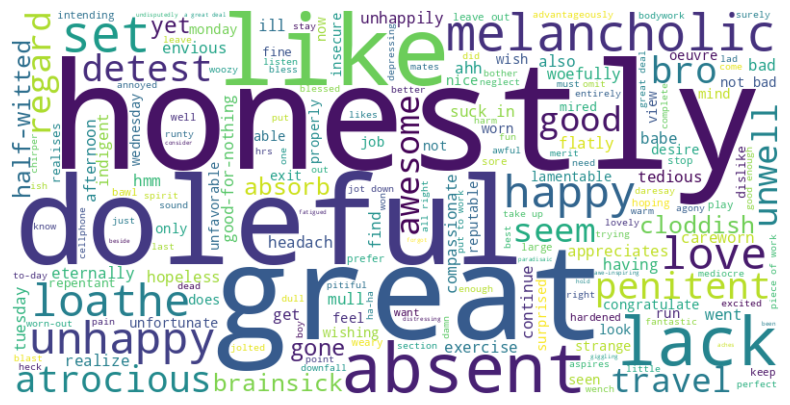

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(replacedWordFreq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

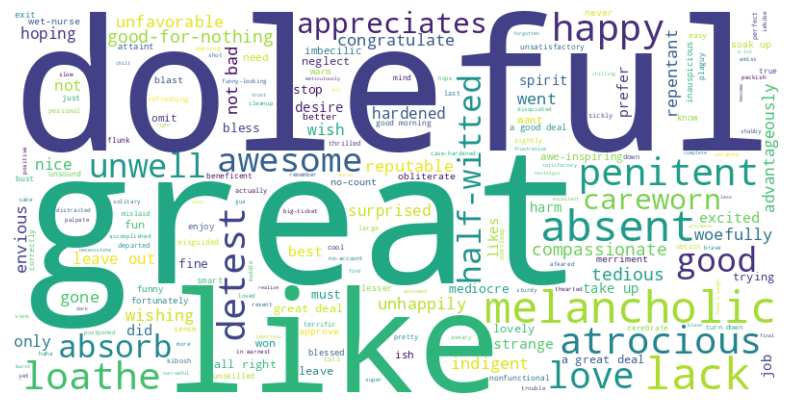

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(triggeredFreq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

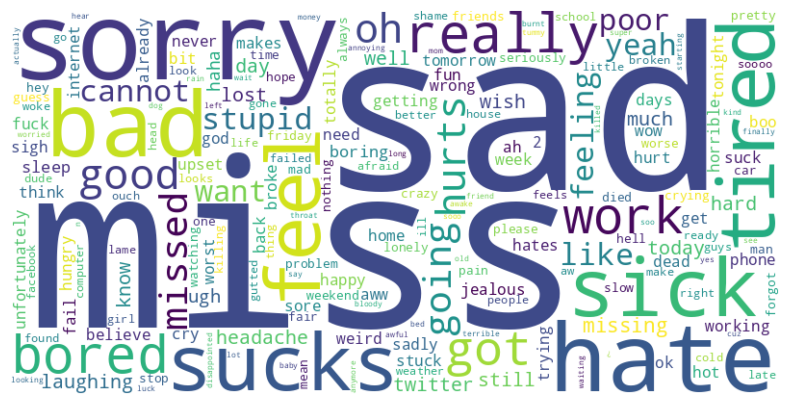

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keywordFreq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()